In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/OFTALMOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=97.7, x1=152.2, y1=110.4
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 348
Page 1, Q1, A: Yellow percentage: 0.0%


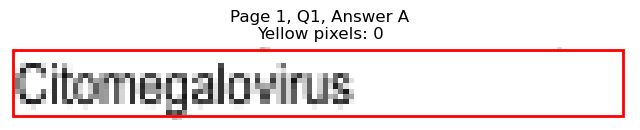

Page 1, Q1 - B: Detected box: x0=85.0, y0=110.3, x1=173.2, y1=123.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 441
Page 1, Q1, B: Yellow percentage: 0.0%


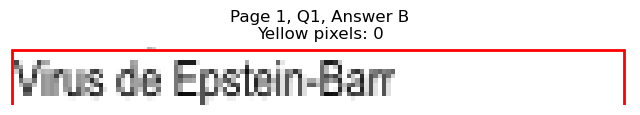

Page 1, Q1 - C: Detected box: x0=85.0, y0=122.9, x1=163.2, y1=135.6
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 395
Page 1, Q1, C: Yellow percentage: 0.0%


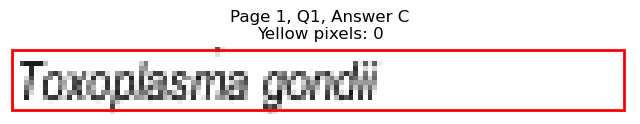

Page 1, Q1 - D: Detected box: x0=336.7, y0=97.7, x1=445.0, y1=110.4
Page 1, Q1, D: Yellow pixels: 1532
Page 1, Q1, D: Total non-white pixels: 2240
Page 1, Q1, D: Yellow percentage: 68.4%


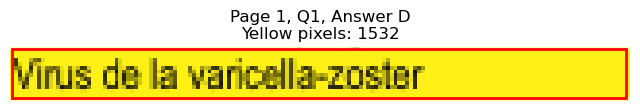

Page 1, Q1 - E: Detected box: x0=336.7, y0=110.3, x1=400.4, y1=123.0
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 412
Page 1, Q1, E: Yellow percentage: 0.0%


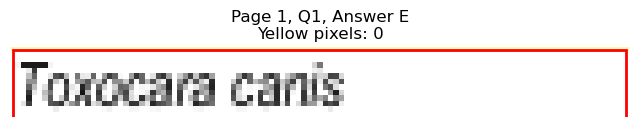


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=198.6, x1=122.1, y1=211.3
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 200
Page 1, Q2, A: Yellow percentage: 0.0%


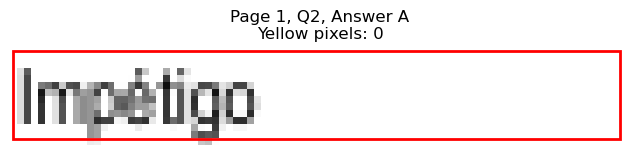

Page 1, Q2 - B: Detected box: x0=85.0, y0=211.3, x1=143.7, y1=224.0
Page 1, Q2, B: Yellow pixels: 1204
Page 1, Q2, B: Total non-white pixels: 1430
Page 1, Q2, B: Yellow percentage: 84.2%


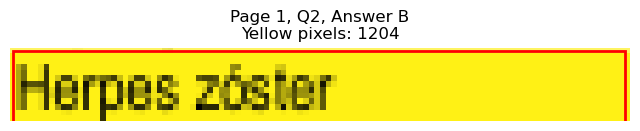

Page 1, Q2 - C: Detected box: x0=85.0, y0=223.9, x1=118.1, y1=236.6
Page 1, Q2, C: Yellow pixels: 84
Page 1, Q2, C: Total non-white pixels: 257
Page 1, Q2, C: Yellow percentage: 32.7%


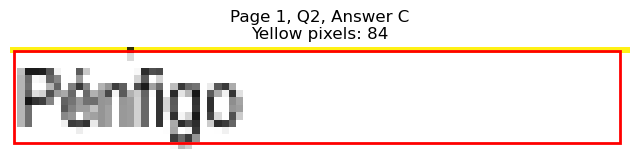

Page 1, Q2 - D: Detected box: x0=336.7, y0=198.6, x1=408.4, y1=211.3
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 338
Page 1, Q2, D: Yellow percentage: 0.0%


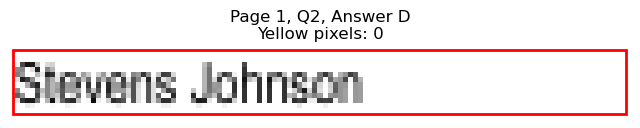

Page 1, Q2 - E: Detected box: x0=336.7, y0=211.3, x1=373.7, y1=224.0
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 206
Page 1, Q2, E: Yellow percentage: 0.0%


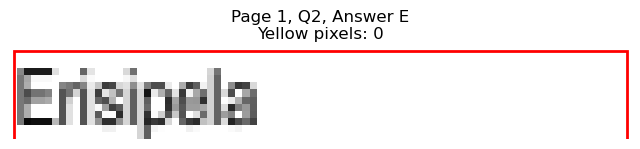


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=261.7, x1=148.2, y1=274.4
Page 1, Q3, A: Yellow pixels: 1241
Page 1, Q3, A: Total non-white pixels: 1610
Page 1, Q3, A: Yellow percentage: 77.1%


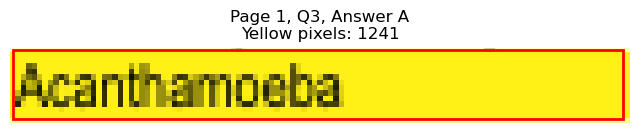

Page 1, Q3 - B: Detected box: x0=85.0, y0=274.5, x1=132.6, y1=287.1
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 231
Page 1, Q3, B: Yellow percentage: 0.0%


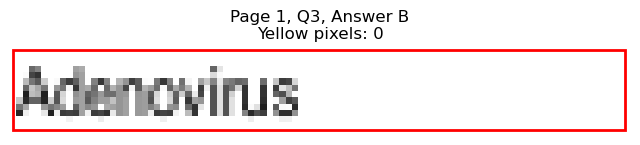

Page 1, Q3 - C: Detected box: x0=85.0, y0=287.1, x1=121.1, y1=299.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 165
Page 1, Q3, C: Yellow percentage: 0.0%


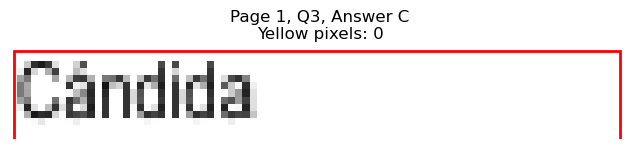

Page 1, Q3 - D: Detected box: x0=336.7, y0=261.7, x1=421.4, y1=274.4
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 416
Page 1, Q3, D: Yellow percentage: 0.0%


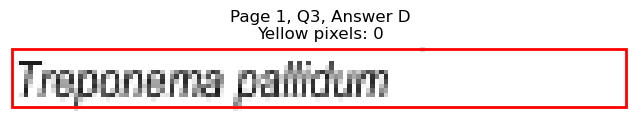

Page 1, Q3 - E: Detected box: x0=336.7, y0=274.5, x1=422.9, y1=287.1
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 416
Page 1, Q3, E: Yellow percentage: 0.0%


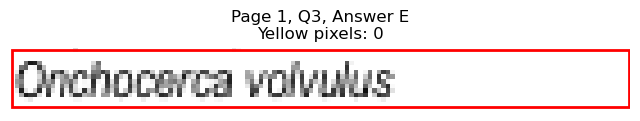


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=324.9, x1=166.7, y1=337.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 414
Page 1, Q4, A: Yellow percentage: 0.0%


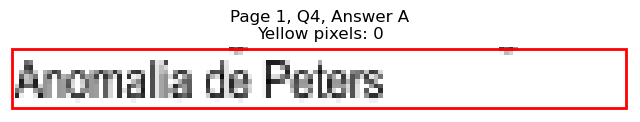

Page 1, Q4 - B: Detected box: x0=85.0, y0=337.5, x1=131.7, y1=350.1
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 227
Page 1, Q4, B: Yellow percentage: 0.0%


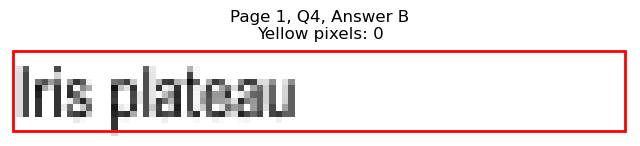

Page 1, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=117.6, y1=362.9
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 178
Page 1, Q4, C: Yellow percentage: 0.0%


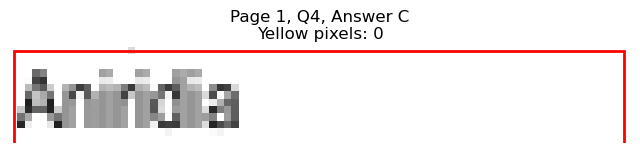

Page 1, Q4 - D: Detected box: x0=336.7, y0=324.9, x1=414.9, y1=337.5
Page 1, Q4, D: Yellow pixels: 129
Page 1, Q4, D: Total non-white pixels: 508
Page 1, Q4, D: Yellow percentage: 25.4%


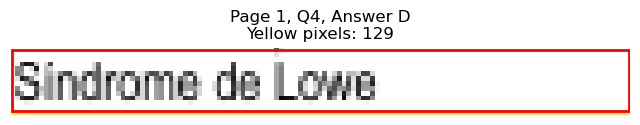

Page 1, Q4 - E: Detected box: x0=336.7, y0=337.5, x1=427.5, y1=350.1
Page 1, Q4, E: Yellow pixels: 1484
Page 1, Q4, E: Total non-white pixels: 1988
Page 1, Q4, E: Yellow percentage: 74.6%


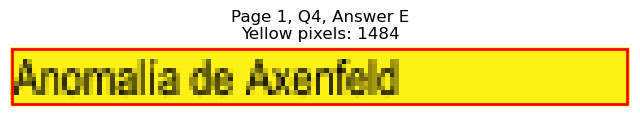


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=388.0, x1=175.7, y1=400.7
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 464
Page 1, Q5, A: Yellow percentage: 0.0%


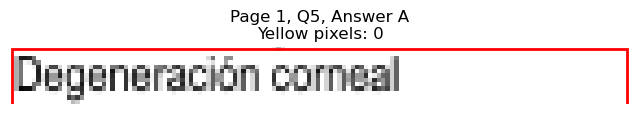

Page 1, Q5 - B: Detected box: x0=85.0, y0=400.6, x1=178.2, y1=413.3
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 475
Page 1, Q5, B: Yellow percentage: 0.0%


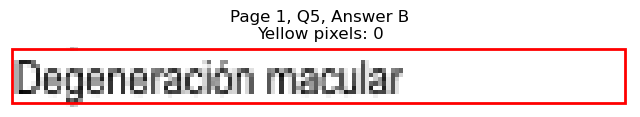

Page 1, Q5 - C: Detected box: x0=85.0, y0=413.3, x1=198.9, y1=426.0
Page 1, Q5, C: Yellow pixels: 1662
Page 1, Q5, C: Total non-white pixels: 2145
Page 1, Q5, C: Yellow percentage: 77.5%


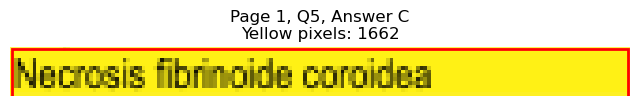

Page 1, Q5 - D: Detected box: x0=336.7, y0=388.0, x1=456.5, y1=400.7
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 605
Page 1, Q5, D: Yellow percentage: 0.0%


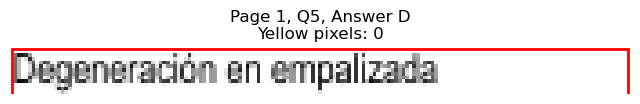

Page 1, Q5 - E: Detected box: x0=336.7, y0=400.6, x1=407.8, y1=413.3
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 370
Page 1, Q5, E: Yellow percentage: 0.0%


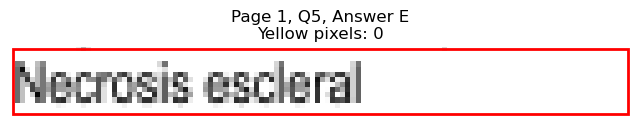


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=451.1, x1=120.1, y1=463.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 255
Page 1, Q6, A: Yellow percentage: 0.0%


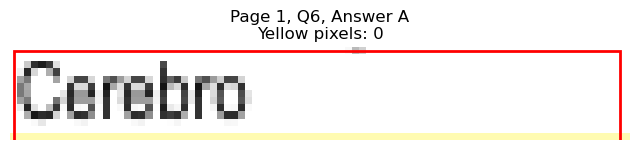

Page 1, Q6 - B: Detected box: x0=85.0, y0=463.7, x1=116.5, y1=476.4
Page 1, Q6, B: Yellow pixels: 854
Page 1, Q6, B: Total non-white pixels: 1162
Page 1, Q6, B: Yellow percentage: 73.5%


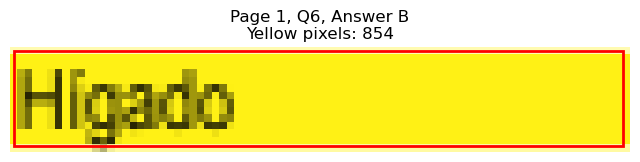

Page 1, Q6 - C: Detected box: x0=85.0, y0=476.3, x1=102.5, y1=489.0
Page 1, Q6, C: Yellow pixels: 1
Page 1, Q6, C: Total non-white pixels: 161
Page 1, Q6, C: Yellow percentage: 0.6%


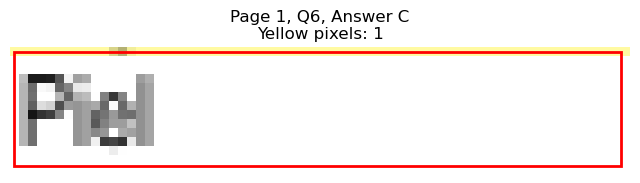

Page 1, Q6 - D: Detected box: x0=336.7, y0=451.1, x1=359.7, y1=463.8
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 113
Page 1, Q6, D: Yellow percentage: 0.0%


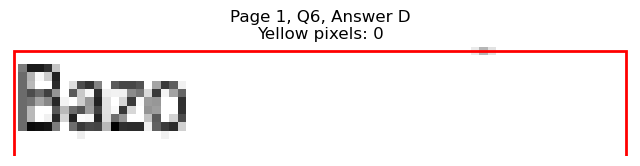

Page 1, Q6 - E: Detected box: x0=336.7, y0=463.7, x1=362.7, y1=476.4
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 140
Page 1, Q6, E: Yellow percentage: 0.0%


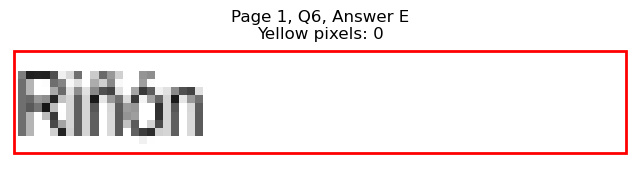


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=514.3, x1=224.9, y1=526.9
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 892
Page 1, Q7, A: Yellow percentage: 0.0%


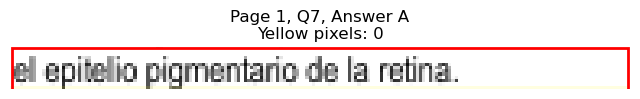

Page 1, Q7 - B: Detected box: x0=85.0, y0=526.9, x1=181.2, y1=539.5
Page 1, Q7, B: Yellow pixels: 1567
Page 1, Q7, B: Total non-white pixels: 2072
Page 1, Q7, B: Yellow percentage: 75.6%


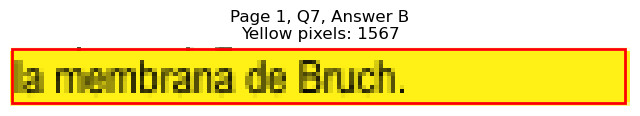

Page 1, Q7 - C: Detected box: x0=85.0, y0=539.5, x1=242.1, y1=552.1
Page 1, Q7, C: Yellow pixels: 190
Page 1, Q7, C: Total non-white pixels: 967
Page 1, Q7, C: Yellow percentage: 19.6%


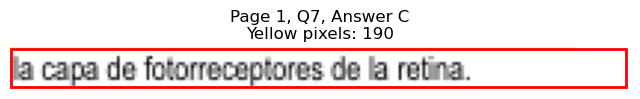

Page 1, Q7 - D: Detected box: x0=336.7, y0=514.3, x1=447.5, y1=526.9
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 539
Page 1, Q7, D: Yellow percentage: 0.0%


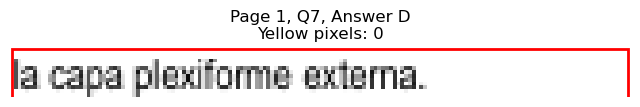

Page 1, Q7 - E: Detected box: x0=336.7, y0=526.9, x1=460.5, y1=539.5
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 623
Page 1, Q7, E: Yellow percentage: 0.0%


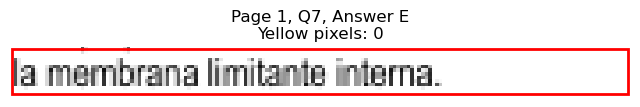


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=577.4, x1=141.6, y1=590.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 288
Page 1, Q8, A: Yellow percentage: 0.0%


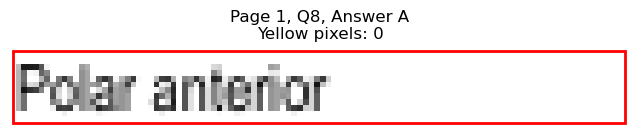

Page 1, Q8 - B: Detected box: x0=85.0, y0=590.0, x1=118.1, y1=602.6
Page 1, Q8, B: Yellow pixels: 85
Page 1, Q8, B: Total non-white pixels: 252
Page 1, Q8, B: Yellow percentage: 33.7%


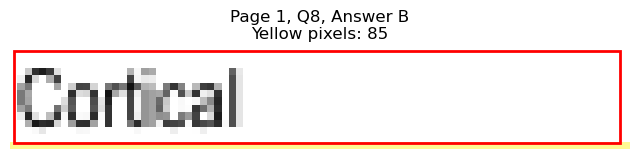

Page 1, Q8 - C: Detected box: x0=85.0, y0=602.6, x1=175.2, y1=615.2
Page 1, Q8, C: Yellow pixels: 1470
Page 1, Q8, C: Total non-white pixels: 1988
Page 1, Q8, C: Yellow percentage: 73.9%


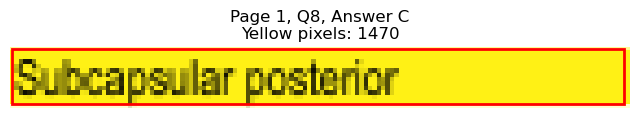

Page 1, Q8 - D: Detected box: x0=336.7, y0=577.4, x1=367.7, y1=590.0
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 167
Page 1, Q8, D: Yellow percentage: 0.0%


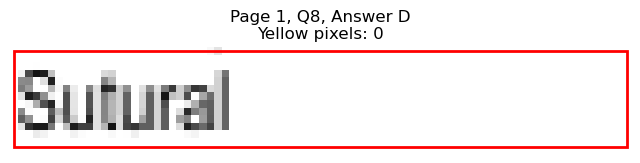

Page 1, Q8 - E: Detected box: x0=336.7, y0=590.0, x1=402.9, y1=602.6
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 321
Page 1, Q8, E: Yellow percentage: 0.0%


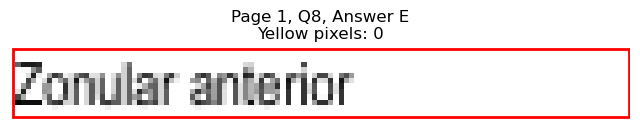


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=640.5, x1=192.3, y1=653.2
Page 1, Q9, A: Yellow pixels: 1682
Page 1, Q9, A: Total non-white pixels: 2226
Page 1, Q9, A: Yellow percentage: 75.6%


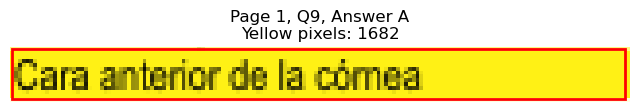

Page 1, Q9 - B: Detected box: x0=85.0, y0=653.1, x1=168.3, y1=665.8
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 418
Page 1, Q9, B: Yellow percentage: 0.0%


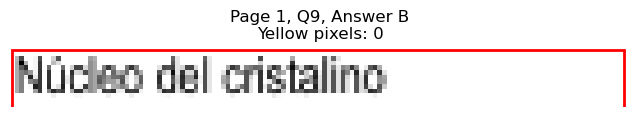

Page 1, Q9 - C: Detected box: x0=85.0, y0=665.7, x1=192.7, y1=678.4
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 536
Page 1, Q9, C: Yellow percentage: 0.0%


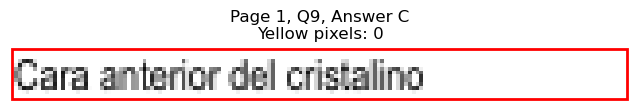

Page 1, Q9 - D: Detected box: x0=336.7, y0=640.5, x1=449.0, y1=653.2
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 537
Page 1, Q9, D: Yellow percentage: 0.0%


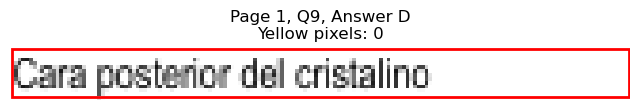

Page 1, Q9 - E: Detected box: x0=336.7, y0=653.1, x1=448.5, y1=665.8
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 545
Page 1, Q9, E: Yellow percentage: 0.0%


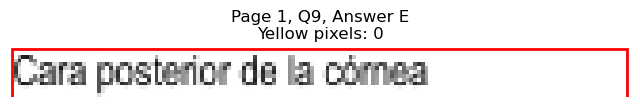


Page 1, Q9 - Selected Answer: A (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=85.0, y0=703.7, x1=162.3, y1=716.3
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 417
Page 1, Q10, A: Yellow percentage: 0.0%


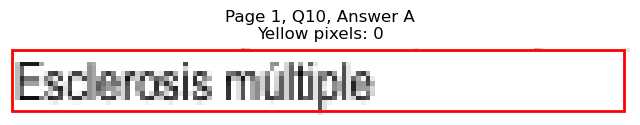

Page 1, Q10 - B: Detected box: x0=85.0, y0=716.3, x1=197.8, y1=728.9
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 593
Page 1, Q10, B: Yellow percentage: 0.0%


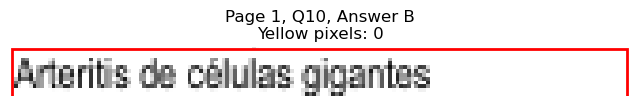

Page 1, Q10 - C: Detected box: x0=85.0, y0=728.9, x1=174.3, y1=741.5
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 504
Page 1, Q10, C: Yellow percentage: 0.0%


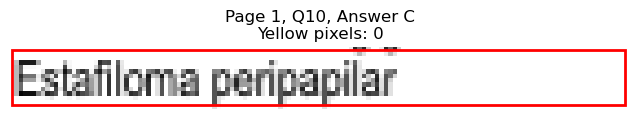

Page 1, Q10 - D: Detected box: x0=336.7, y0=703.7, x1=419.9, y1=716.3
Page 1, Q10, D: Yellow pixels: 134
Page 1, Q10, D: Total non-white pixels: 561
Page 1, Q10, D: Yellow percentage: 23.9%


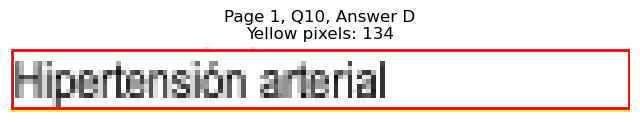

Page 1, Q10 - E: Detected box: x0=336.7, y0=716.3, x1=442.0, y1=728.9
Page 1, Q10, E: Yellow pixels: 1627
Page 1, Q10, E: Total non-white pixels: 2041
Page 1, Q10, E: Yellow percentage: 79.7%


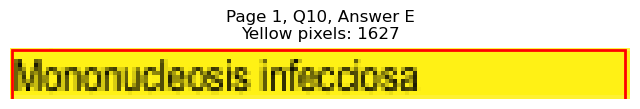


Page 1, Q10 - Selected Answer: E (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=110.3, x1=132.6, y1=123.0
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 222
Page 2, Q1, A: Yellow percentage: 0.0%


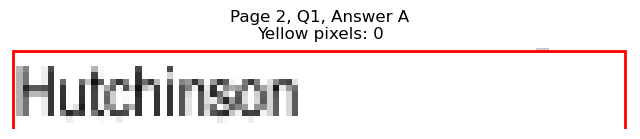

Page 2, Q1 - B: Detected box: x0=85.0, y0=122.9, x1=154.2, y1=135.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 354
Page 2, Q1, B: Yellow percentage: 0.0%


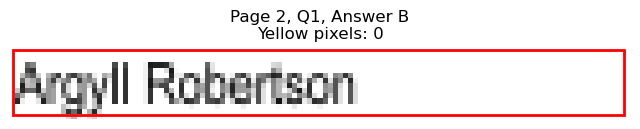

Page 2, Q1 - C: Detected box: x0=85.0, y0=135.5, x1=168.3, y1=148.2
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 425
Page 2, Q1, C: Yellow percentage: 0.0%


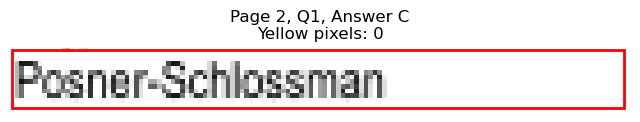

Page 2, Q1 - D: Detected box: x0=336.7, y0=110.3, x1=395.8, y1=123.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 420
Page 2, Q1, D: Yellow percentage: 0.0%


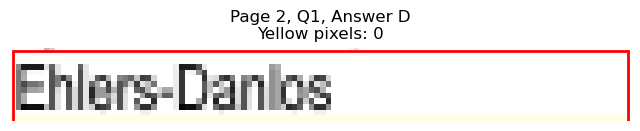

Page 2, Q1 - E: Detected box: x0=336.7, y0=122.9, x1=395.8, y1=135.6
Page 2, Q1, E: Yellow pixels: 1189
Page 2, Q1, E: Total non-white pixels: 1540
Page 2, Q1, E: Yellow percentage: 77.2%


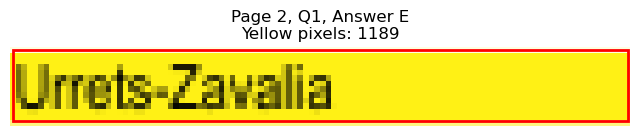


Page 2, Q1 - Selected Answer: E (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=186.0, x1=130.6, y1=198.7
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 232
Page 2, Q2, A: Yellow percentage: 0.0%


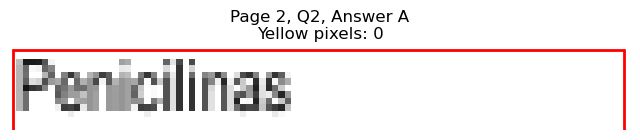

Page 2, Q2 - B: Detected box: x0=85.0, y0=198.6, x1=131.1, y1=211.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 252
Page 2, Q2, B: Yellow percentage: 0.0%


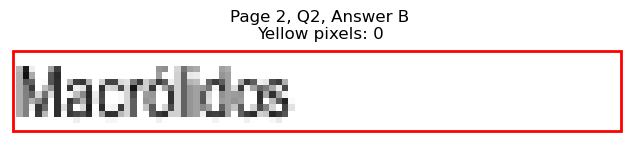

Page 2, Q2 - C: Detected box: x0=85.0, y0=211.3, x1=133.1, y1=224.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 258
Page 2, Q2, C: Yellow percentage: 0.0%


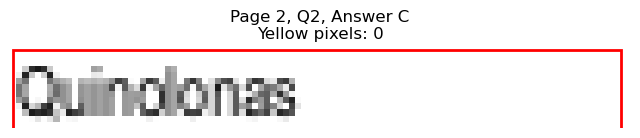

Page 2, Q2 - D: Detected box: x0=336.7, y0=186.0, x1=407.3, y1=198.7
Page 2, Q2, D: Yellow pixels: 3
Page 2, Q2, D: Total non-white pixels: 501
Page 2, Q2, D: Yellow percentage: 0.6%


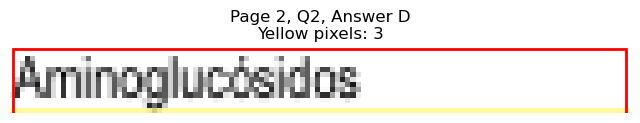

Page 2, Q2 - E: Detected box: x0=336.7, y0=198.6, x1=393.9, y1=211.3
Page 2, Q2, E: Yellow pixels: 1072
Page 2, Q2, E: Total non-white pixels: 1512
Page 2, Q2, E: Yellow percentage: 70.9%


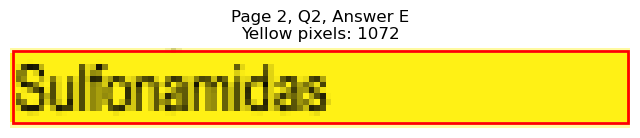


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=261.7, x1=128.7, y1=274.4
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 214
Page 2, Q3, A: Yellow percentage: 0.0%


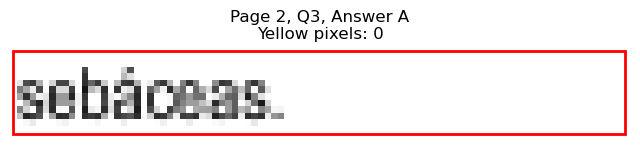

Page 2, Q3 - B: Detected box: x0=85.0, y0=274.5, x1=118.6, y1=287.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 178
Page 2, Q3, B: Yellow percentage: 0.0%


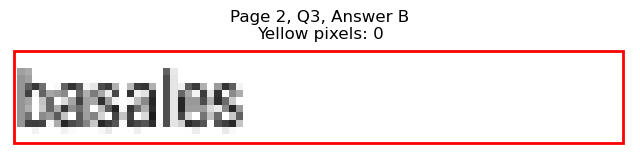

Page 2, Q3 - C: Detected box: x0=85.0, y0=287.1, x1=127.1, y1=299.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 220
Page 2, Q3, C: Yellow percentage: 0.0%


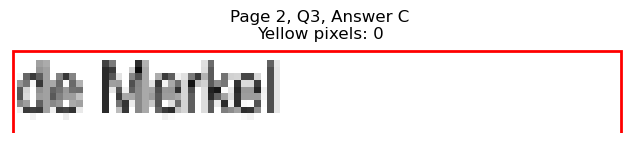

Page 2, Q3 - D: Detected box: x0=336.7, y0=261.7, x1=387.3, y1=274.4
Page 2, Q3, D: Yellow pixels: 1140
Page 2, Q3, D: Total non-white pixels: 1428
Page 2, Q3, D: Yellow percentage: 79.8%


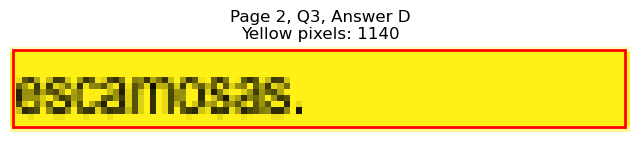

Page 2, Q3 - E: Detected box: x0=336.7, y0=274.5, x1=388.4, y1=287.1
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 269
Page 2, Q3, E: Yellow percentage: 0.0%


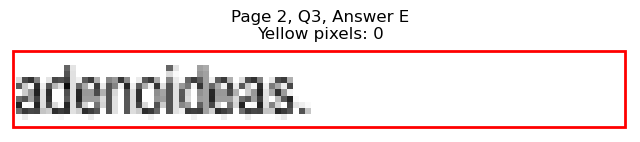


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=324.9, x1=169.2, y1=337.5
Page 2, Q4, A: Yellow pixels: 136
Page 2, Q4, A: Total non-white pixels: 556
Page 2, Q4, A: Yellow percentage: 24.5%


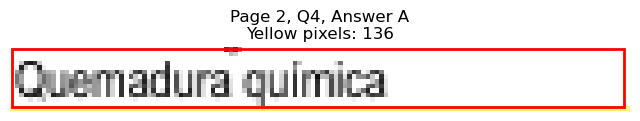

Page 2, Q4 - B: Detected box: x0=85.0, y0=337.5, x1=184.3, y1=350.1
Page 2, Q4, B: Yellow pixels: 1608
Page 2, Q4, B: Total non-white pixels: 2114
Page 2, Q4, B: Yellow percentage: 76.1%


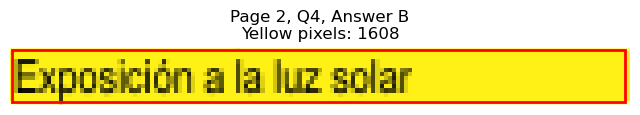

Page 2, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=165.7, y1=362.9
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 550
Page 2, Q4, C: Yellow percentage: 0.0%


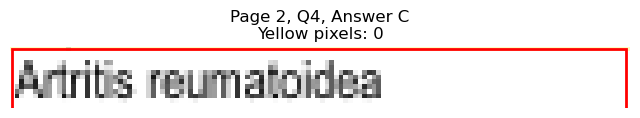

Page 2, Q4 - D: Detected box: x0=336.7, y0=324.9, x1=419.9, y1=337.5
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 448
Page 2, Q4, D: Yellow percentage: 0.0%


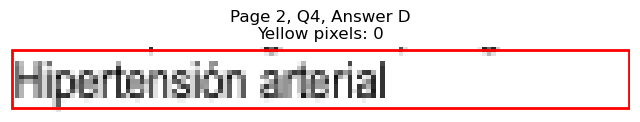

Page 2, Q4 - E: Detected box: x0=336.7, y0=337.5, x1=440.5, y1=350.1
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 518
Page 2, Q4, E: Yellow percentage: 0.0%


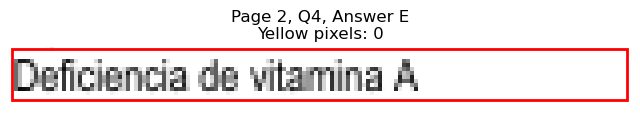


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=388.0, x1=198.9, y1=400.7
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 564
Page 2, Q5, A: Yellow percentage: 0.0%


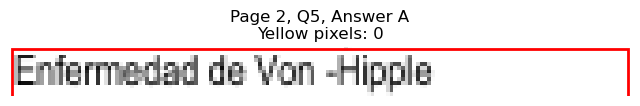

Page 2, Q5 - B: Detected box: x0=85.0, y0=400.6, x1=166.2, y1=413.3
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 427
Page 2, Q5, B: Yellow percentage: 0.0%


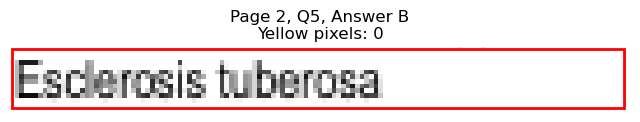

Page 2, Q5 - C: Detected box: x0=85.0, y0=413.3, x1=184.8, y1=426.0
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 518
Page 2, Q5, C: Yellow percentage: 0.0%


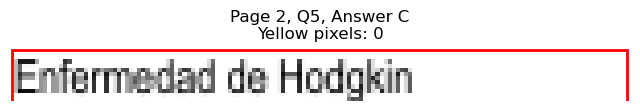

Page 2, Q5 - D: Detected box: x0=336.7, y0=388.0, x1=449.5, y1=400.7
Page 2, Q5, D: Yellow pixels: 1665
Page 2, Q5, D: Total non-white pixels: 2132
Page 2, Q5, D: Yellow percentage: 78.1%


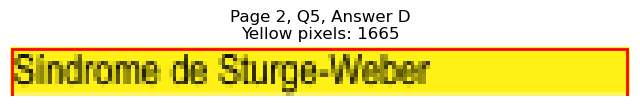

Page 2, Q5 - E: Detected box: x0=336.7, y0=400.6, x1=454.5, y1=413.3
Page 2, Q5, E: Yellow pixels: 167
Page 2, Q5, E: Total non-white pixels: 752
Page 2, Q5, E: Yellow percentage: 22.2%


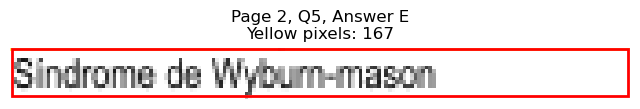


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=451.1, x1=114.6, y1=463.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 232
Page 2, Q6, A: Yellow percentage: 0.0%


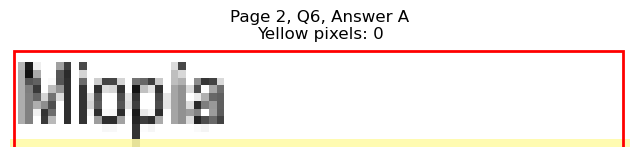

Page 2, Q6 - B: Detected box: x0=85.0, y0=463.7, x1=144.6, y1=476.4
Page 2, Q6, B: Yellow pixels: 1096
Page 2, Q6, B: Total non-white pixels: 1554
Page 2, Q6, B: Yellow percentage: 70.5%


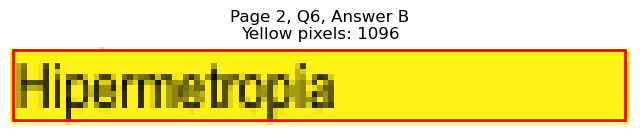

Page 2, Q6 - C: Detected box: x0=85.0, y0=476.3, x1=203.8, y1=489.0
Page 2, Q6, C: Yellow pixels: 2
Page 2, Q6, C: Total non-white pixels: 805
Page 2, Q6, C: Yellow percentage: 0.2%


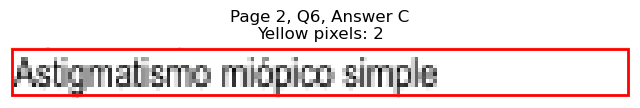

Page 2, Q6 - D: Detected box: x0=336.7, y0=451.1, x1=473.6, y1=463.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 714
Page 2, Q6, D: Yellow percentage: 0.0%


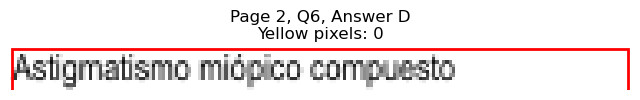

Page 2, Q6 - E: Detected box: x0=336.7, y0=463.7, x1=417.4, y1=476.4
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 421
Page 2, Q6, E: Yellow percentage: 0.0%


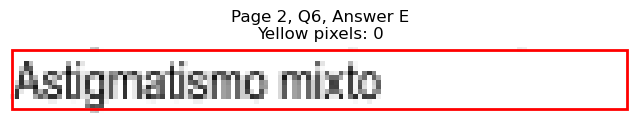


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=514.3, x1=174.3, y1=526.9
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 477
Page 2, Q7, A: Yellow percentage: 0.0%


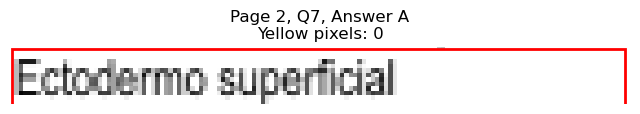

Page 2, Q7 - B: Detected box: x0=85.0, y0=526.9, x1=154.7, y1=539.5
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 344
Page 2, Q7, B: Yellow percentage: 0.0%


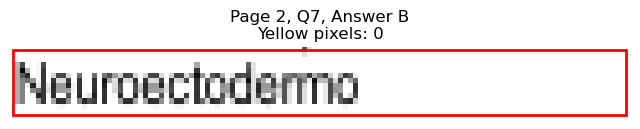

Page 2, Q7 - C: Detected box: x0=85.0, y0=539.5, x1=135.1, y1=552.1
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 260
Page 2, Q7, C: Yellow percentage: 0.0%


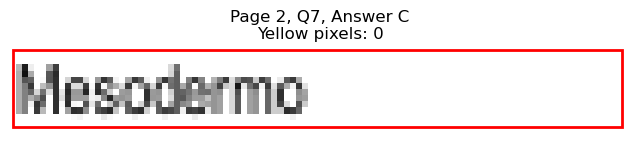

Page 2, Q7 - D: Detected box: x0=336.7, y0=514.3, x1=385.9, y1=526.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 346
Page 2, Q7, D: Yellow percentage: 0.0%


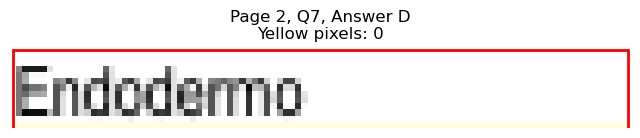

Page 2, Q7 - E: Detected box: x0=336.7, y0=526.9, x1=393.3, y1=539.5
Page 2, Q7, E: Yellow pixels: 1179
Page 2, Q7, E: Total non-white pixels: 1512
Page 2, Q7, E: Yellow percentage: 78.0%


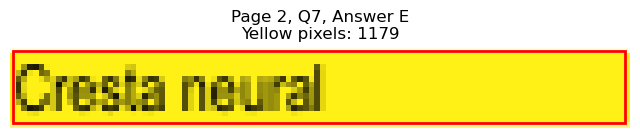


Page 2, Q7 - Selected Answer: E (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=577.4, x1=98.5, y1=590.0
Page 2, Q8, A: Yellow pixels: 797
Page 2, Q8, A: Total non-white pixels: 845
Page 2, Q8, A: Yellow percentage: 94.3%


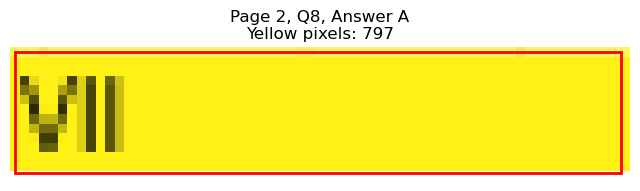

Page 2, Q8 - B: Detected box: x0=85.0, y0=590.0, x1=95.1, y1=602.6
Page 2, Q8, B: Yellow pixels: 62
Page 2, Q8, B: Total non-white pixels: 110
Page 2, Q8, B: Yellow percentage: 56.4%


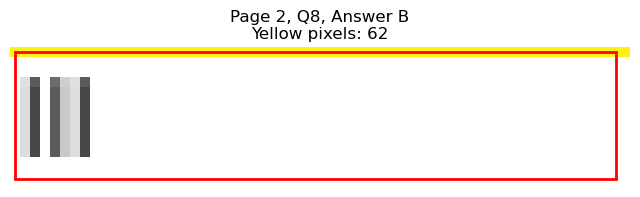

Page 2, Q8 - C: Detected box: x0=85.0, y0=602.6, x1=96.0, y1=615.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 45
Page 2, Q8, C: Yellow percentage: 0.0%


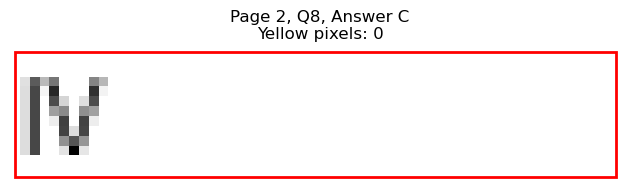

Page 2, Q8 - D: Detected box: x0=322.5, y0=577.4, x1=331.5, y1=590.0
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 68
Page 2, Q8, D: Yellow percentage: 0.0%


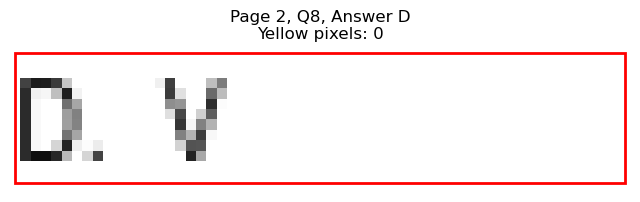

Page 2, Q8 - E: Detected box: x0=336.7, y0=590.0, x1=347.7, y1=602.6
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 44
Page 2, Q8, E: Yellow percentage: 0.0%


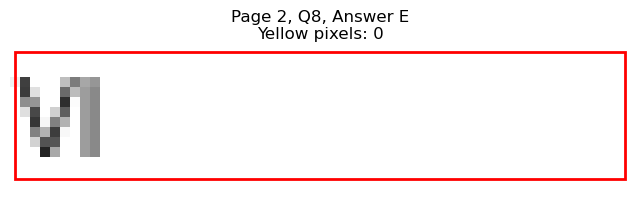


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=85.0, y0=640.5, x1=97.6, y1=653.2
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 72
Page 2, Q9, A: Yellow percentage: 0.0%


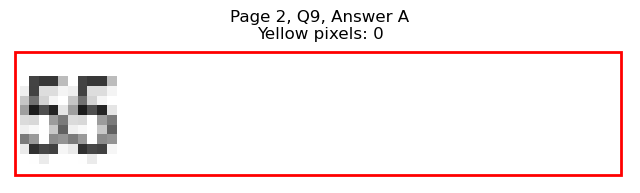

Page 2, Q9 - B: Detected box: x0=85.0, y0=653.1, x1=97.6, y1=665.8
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 57
Page 2, Q9, B: Yellow percentage: 0.0%


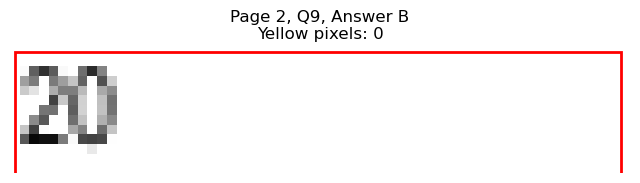

Page 2, Q9 - C: Detected box: x0=85.0, y0=665.7, x1=97.6, y1=678.4
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 52
Page 2, Q9, C: Yellow percentage: 0.0%


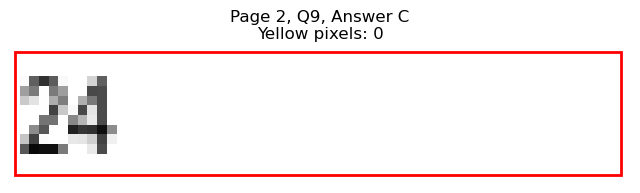

Page 2, Q9 - D: Detected box: x0=336.7, y0=640.5, x1=349.3, y1=653.2
Page 2, Q9, D: Yellow pixels: 788
Page 2, Q9, D: Total non-white pixels: 896
Page 2, Q9, D: Yellow percentage: 87.9%


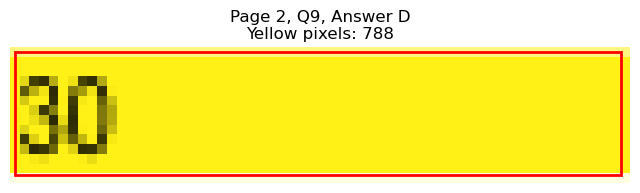

Page 2, Q9 - E: Detected box: x0=336.7, y0=653.1, x1=349.3, y1=665.8
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 59
Page 2, Q9, E: Yellow percentage: 0.0%


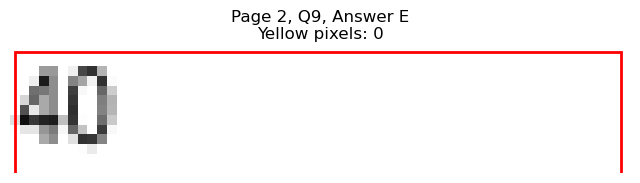


Page 2, Q9 - Selected Answer: D (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=85.0, y0=703.7, x1=197.3, y1=716.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 587
Page 2, Q10, A: Yellow percentage: 0.0%


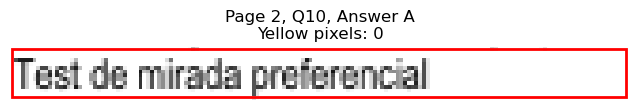

Page 2, Q10 - B: Detected box: x0=85.0, y0=716.3, x1=156.1, y1=728.9
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 349
Page 2, Q10, B: Yellow percentage: 0.0%


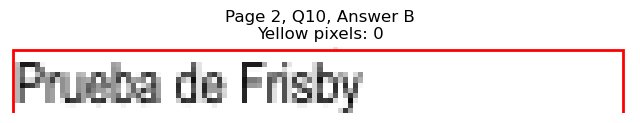

Page 2, Q10 - C: Detected box: x0=85.0, y0=728.9, x1=156.3, y1=741.5
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 332
Page 2, Q10, C: Yellow percentage: 0.0%


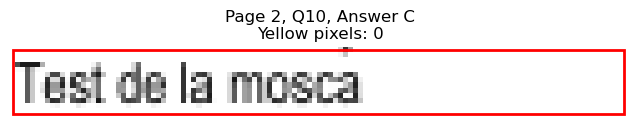

Page 2, Q10 - D: Detected box: x0=336.7, y0=703.7, x1=409.4, y1=716.3
Page 2, Q10, D: Yellow pixels: 1206
Page 2, Q10, D: Total non-white pixels: 1736
Page 2, Q10, D: Yellow percentage: 69.5%


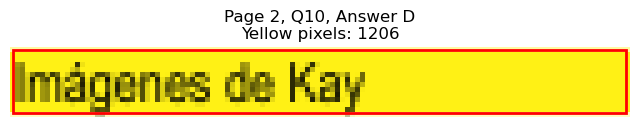

Page 2, Q10 - E: Detected box: x0=336.7, y0=716.3, x1=403.4, y1=728.9
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 443
Page 2, Q10, E: Yellow percentage: 0.0%


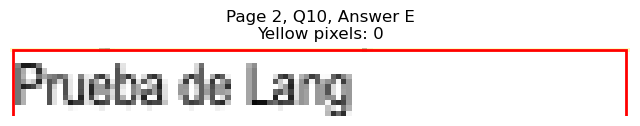


Page 2, Q10 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=97.7, x1=156.7, y1=110.4
Page 3, Q1, A: Yellow pixels: 123
Page 3, Q1, A: Total non-white pixels: 493
Page 3, Q1, A: Yellow percentage: 24.9%


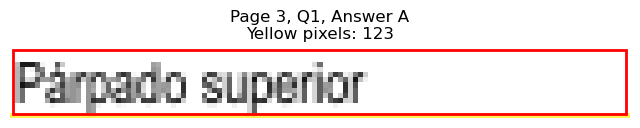

Page 3, Q1 - B: Detected box: x0=85.0, y0=110.3, x1=151.7, y1=123.0
Page 3, Q1, B: Yellow pixels: 1242
Page 3, Q1, B: Total non-white pixels: 1534
Page 3, Q1, B: Yellow percentage: 81.0%


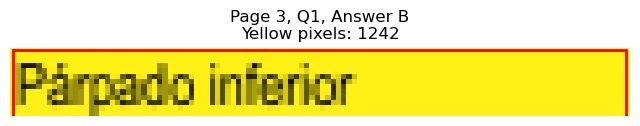

Page 3, Q1 - C: Detected box: x0=85.0, y0=122.9, x1=144.1, y1=135.6
Page 3, Q1, C: Yellow pixels: 109
Page 3, Q1, C: Total non-white pixels: 387
Page 3, Q1, C: Yellow percentage: 28.2%


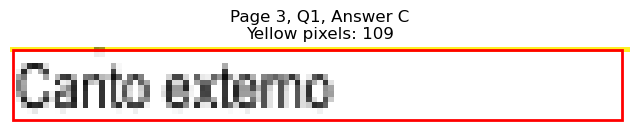

Page 3, Q1 - D: Detected box: x0=336.7, y0=97.7, x1=393.3, y1=110.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 277
Page 3, Q1, D: Yellow percentage: 0.0%


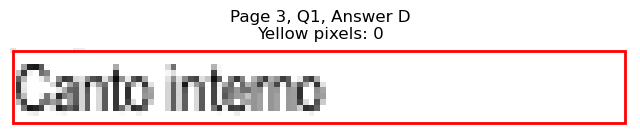

Page 3, Q1 - E: Detected box: x0=336.7, y0=110.3, x1=380.3, y1=123.0
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 222
Page 3, Q1, E: Yellow percentage: 0.0%


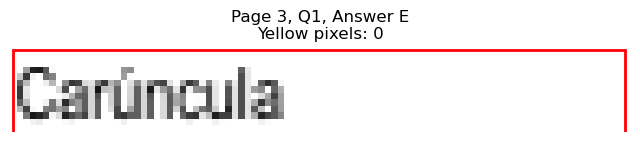


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=186.0, x1=180.7, y1=198.7
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 499
Page 3, Q2, A: Yellow percentage: 0.0%


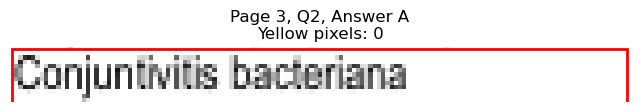

Page 3, Q2 - B: Detected box: x0=85.0, y0=198.6, x1=217.5, y1=211.3
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 673
Page 3, Q2, B: Yellow percentage: 0.0%


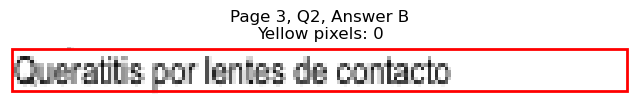

Page 3, Q2 - C: Detected box: x0=85.0, y0=211.3, x1=188.3, y1=224.0
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 540
Page 3, Q2, C: Yellow percentage: 0.0%


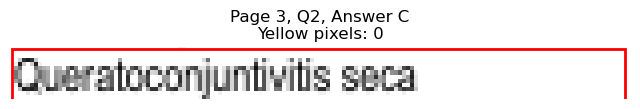

Page 3, Q2 - D: Detected box: x0=336.7, y0=186.0, x1=406.9, y1=198.7
Page 3, Q2, D: Yellow pixels: 1
Page 3, Q2, D: Total non-white pixels: 490
Page 3, Q2, D: Yellow percentage: 0.2%


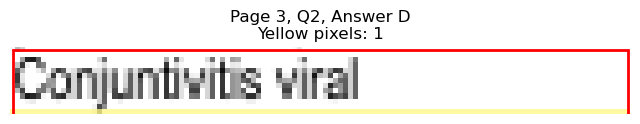

Page 3, Q2 - E: Detected box: x0=336.7, y0=198.6, x1=414.9, y1=211.3
Page 3, Q2, E: Yellow pixels: 1253
Page 3, Q2, E: Total non-white pixels: 1806
Page 3, Q2, E: Yellow percentage: 69.4%


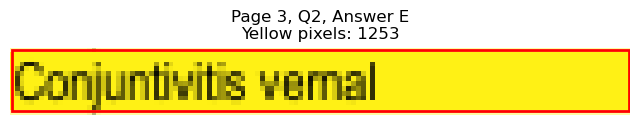


Page 3, Q2 - Selected Answer: E (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=249.1, x1=127.6, y1=261.8
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 230
Page 3, Q3, A: Yellow percentage: 0.0%


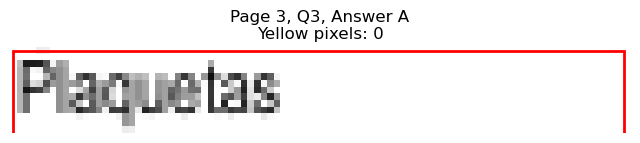

Page 3, Q3 - B: Detected box: x0=85.0, y0=261.7, x1=109.6, y1=274.4
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 107
Page 3, Q3, B: Yellow percentage: 0.0%


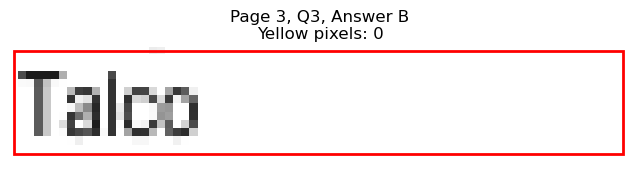

Page 3, Q3 - C: Detected box: x0=85.0, y0=274.5, x1=160.2, y1=287.1
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 392
Page 3, Q3, C: Yellow percentage: 0.0%


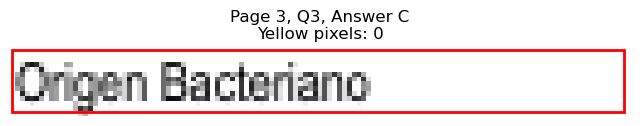

Page 3, Q3 - D: Detected box: x0=336.7, y0=249.1, x1=401.8, y1=261.8
Page 3, Q3, D: Yellow pixels: 1
Page 3, Q3, D: Total non-white pixels: 455
Page 3, Q3, D: Yellow percentage: 0.2%


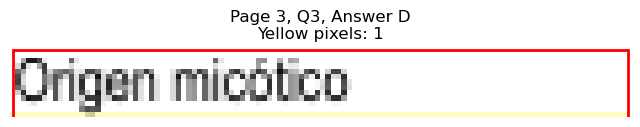

Page 3, Q3 - E: Detected box: x0=336.7, y0=261.7, x1=379.7, y1=274.4
Page 3, Q3, E: Yellow pixels: 1038
Page 3, Q3, E: Total non-white pixels: 1316
Page 3, Q3, E: Yellow percentage: 78.9%


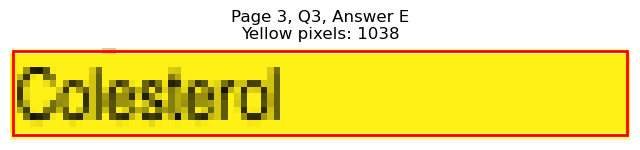


Page 3, Q3 - Selected Answer: E (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=337.5, x1=207.9, y1=350.1
Page 3, Q4, A: Yellow pixels: 1815
Page 3, Q4, A: Total non-white pixels: 2436
Page 3, Q4, A: Yellow percentage: 74.5%


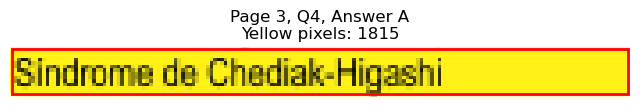

Page 3, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=180.3, y1=362.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 636
Page 3, Q4, B: Yellow percentage: 0.0%


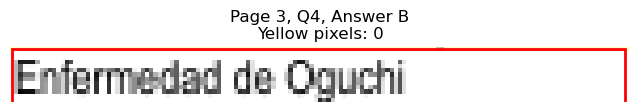

Page 3, Q4 - C: Detected box: x0=85.0, y0=362.8, x1=217.8, y1=375.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 673
Page 3, Q4, C: Yellow percentage: 0.0%


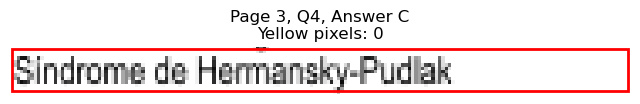

Page 3, Q4 - D: Detected box: x0=336.7, y0=337.5, x1=463.0, y1=350.1
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 620
Page 3, Q4, D: Yellow percentage: 0.0%


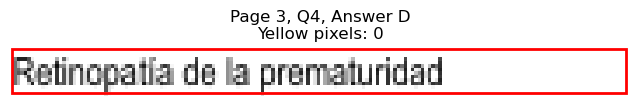

Page 3, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=440.5, y1=362.9
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 538
Page 3, Q4, E: Yellow percentage: 0.0%


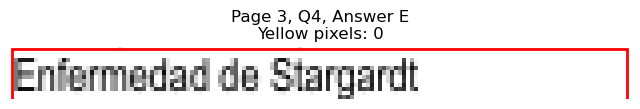


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=400.6, x1=147.1, y1=413.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 328
Page 3, Q5, A: Yellow percentage: 0.0%


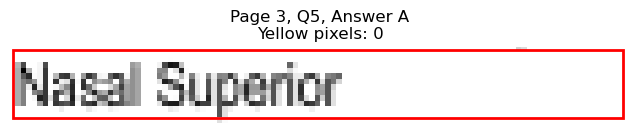

Page 3, Q5 - B: Detected box: x0=85.0, y0=413.3, x1=150.1, y1=426.0
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 428
Page 3, Q5, B: Yellow percentage: 0.0%


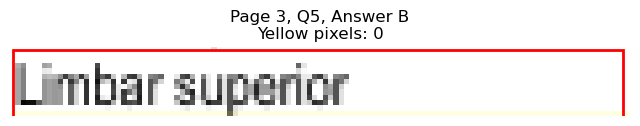

Page 3, Q5 - C: Detected box: x0=85.0, y0=425.9, x1=140.7, y1=438.6
Page 3, Q5, C: Yellow pixels: 1162
Page 3, Q5, C: Total non-white pixels: 1498
Page 3, Q5, C: Yellow percentage: 77.6%


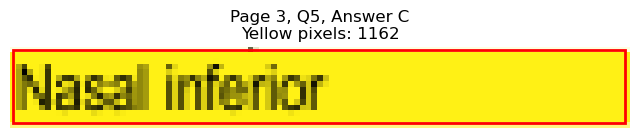

Page 3, Q5 - D: Detected box: x0=336.7, y0=400.6, x1=407.3, y1=413.3
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 345
Page 3, Q5, D: Yellow percentage: 0.0%


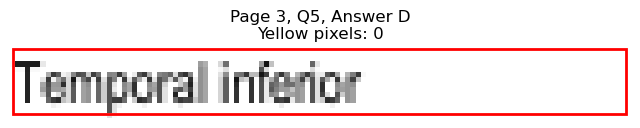

Page 3, Q5 - E: Detected box: x0=336.7, y0=413.3, x1=412.4, y1=426.0
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 381
Page 3, Q5, E: Yellow percentage: 0.0%


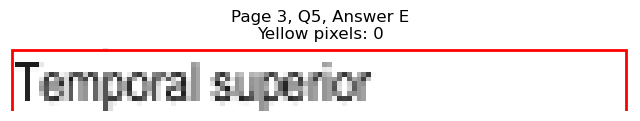


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=463.7, x1=195.3, y1=476.4
Page 3, Q6, A: Yellow pixels: 1524
Page 3, Q6, A: Total non-white pixels: 2268
Page 3, Q6, A: Yellow percentage: 67.2%


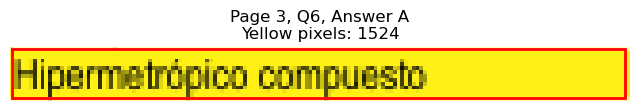

Page 3, Q6 - B: Detected box: x0=85.0, y0=476.3, x1=109.1, y1=489.0
Page 3, Q6, B: Yellow pixels: 2
Page 3, Q6, B: Total non-white pixels: 188
Page 3, Q6, B: Yellow percentage: 1.1%


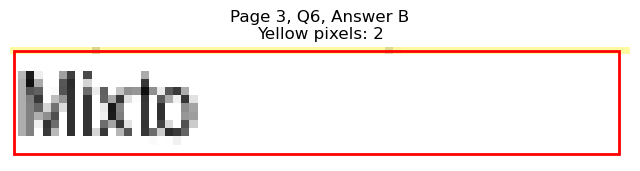

Page 3, Q6 - C: Detected box: x0=85.0, y0=489.1, x1=177.3, y1=501.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 468
Page 3, Q6, C: Yellow percentage: 0.0%


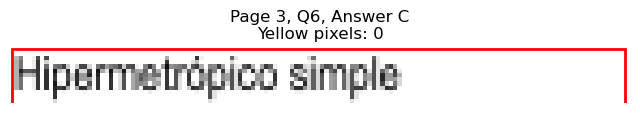

Page 3, Q6 - D: Detected box: x0=336.7, y0=463.7, x1=416.9, y1=476.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 411
Page 3, Q6, D: Yellow percentage: 0.0%


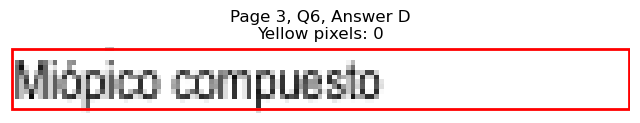

Page 3, Q6 - E: Detected box: x0=336.7, y0=476.3, x1=398.8, y1=489.0
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 333
Page 3, Q6, E: Yellow percentage: 0.0%


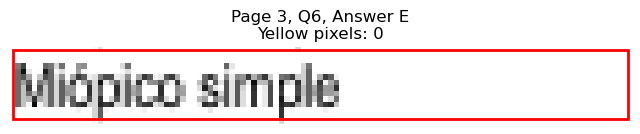


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=526.9, x1=138.1, y1=539.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 271
Page 3, Q7, A: Yellow percentage: 0.0%


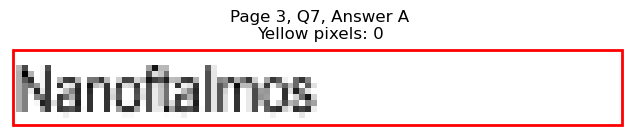

Page 3, Q7 - B: Detected box: x0=85.0, y0=539.5, x1=197.8, y1=552.1
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 560
Page 3, Q7, B: Yellow percentage: 0.0%


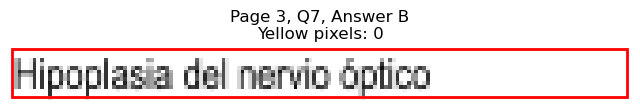

Page 3, Q7 - C: Detected box: x0=85.0, y0=552.2, x1=220.8, y1=564.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 682
Page 3, Q7, C: Yellow percentage: 0.0%


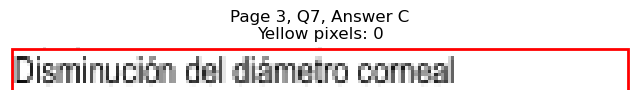

Page 3, Q7 - D: Detected box: x0=336.7, y0=526.9, x1=452.6, y1=539.5
Page 3, Q7, D: Yellow pixels: 1722
Page 3, Q7, D: Total non-white pixels: 2338
Page 3, Q7, D: Yellow percentage: 73.7%


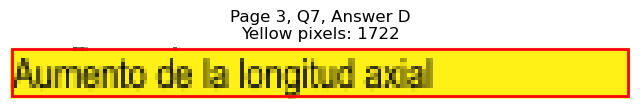

Page 3, Q7 - E: Detected box: x0=336.7, y0=539.5, x1=437.0, y1=552.1
Page 3, Q7, E: Yellow pixels: 149
Page 3, Q7, E: Total non-white pixels: 664
Page 3, Q7, E: Yellow percentage: 22.4%


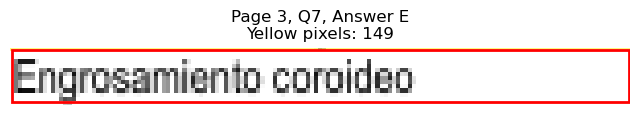


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=590.0, x1=169.7, y1=602.6
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 442
Page 3, Q8, A: Yellow percentage: 0.0%


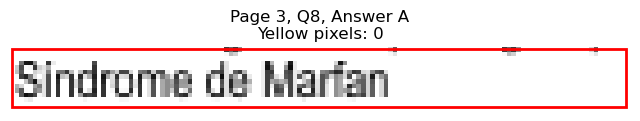

Page 3, Q8 - B: Detected box: x0=85.0, y0=602.6, x1=209.9, y1=615.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 612
Page 3, Q8, B: Yellow percentage: 0.0%


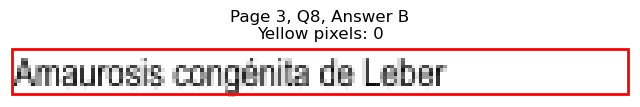

Page 3, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=197.3, y1=627.8
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 580
Page 3, Q8, C: Yellow percentage: 0.0%


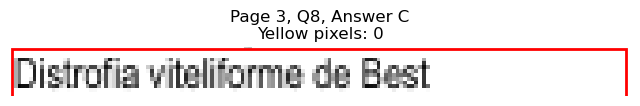

Page 3, Q8 - D: Detected box: x0=336.7, y0=590.0, x1=440.5, y1=602.6
Page 3, Q8, D: Yellow pixels: 155
Page 3, Q8, D: Total non-white pixels: 699
Page 3, Q8, D: Yellow percentage: 22.2%


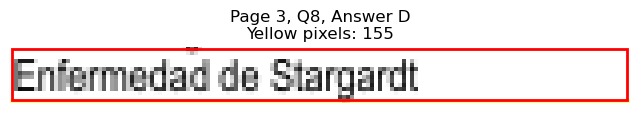

Page 3, Q8 - E: Detected box: x0=336.7, y0=602.6, x1=420.9, y1=615.2
Page 3, Q8, E: Yellow pixels: 1424
Page 3, Q8, E: Total non-white pixels: 1890
Page 3, Q8, E: Yellow percentage: 75.3%


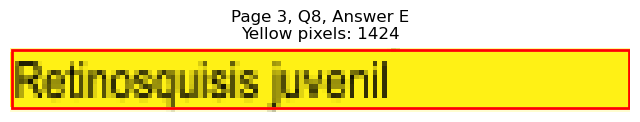


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=665.7, x1=136.7, y1=678.4
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 243
Page 3, Q9, A: Yellow percentage: 0.0%


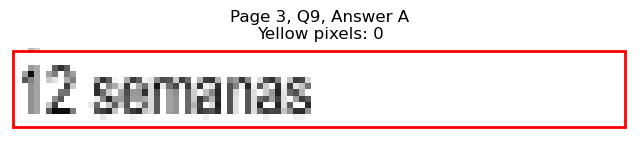

Page 3, Q9 - B: Detected box: x0=85.0, y0=678.3, x1=114.6, y1=691.0
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 133
Page 3, Q9, B: Yellow percentage: 0.0%


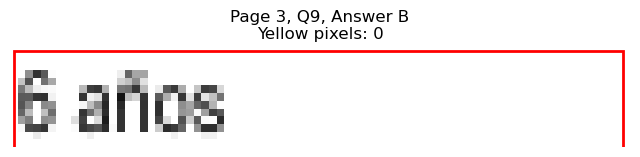

Page 3, Q9 - C: Detected box: x0=85.0, y0=691.1, x1=131.7, y1=703.7
Page 3, Q9, C: Yellow pixels: 1107
Page 3, Q9, C: Total non-white pixels: 1274
Page 3, Q9, C: Yellow percentage: 86.9%


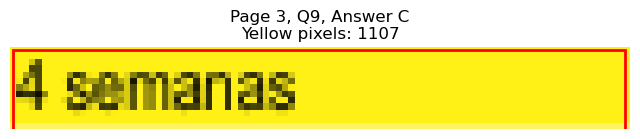

Page 3, Q9 - D: Detected box: x0=336.7, y0=665.7, x1=373.3, y1=678.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 178
Page 3, Q9, D: Yellow percentage: 0.0%


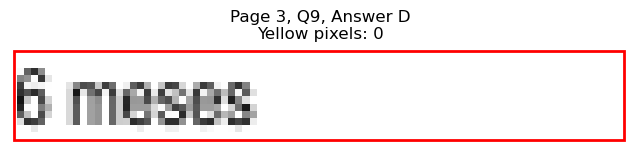

Page 3, Q9 - E: Detected box: x0=336.7, y0=678.3, x1=366.3, y1=691.0
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 138
Page 3, Q9, E: Yellow percentage: 0.0%


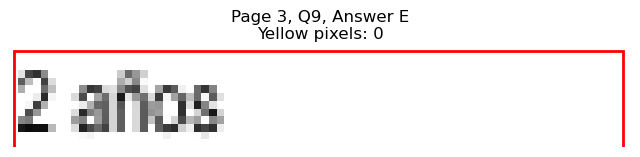


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=85.0, y0=741.4, x1=127.6, y1=754.1
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 246
Page 3, Q10, A: Yellow percentage: 0.0%


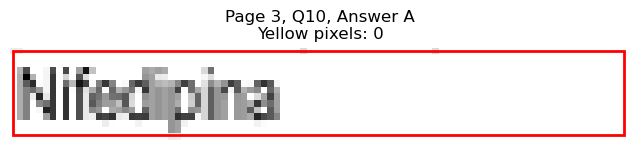

Page 3, Q10 - B: Detected box: x0=85.0, y0=754.0, x1=134.7, y1=766.7
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 252
Page 3, Q10, B: Yellow percentage: 0.0%


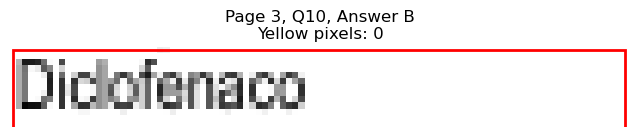

Page 3, Q10 - C: Detected box: x0=85.0, y0=766.8, x1=122.5, y1=779.4
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 210
Page 3, Q10, C: Yellow percentage: 0.0%


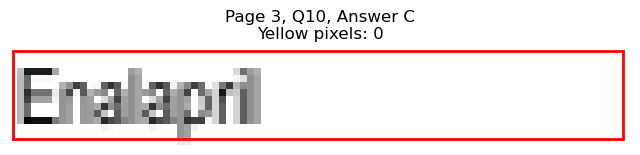

Page 3, Q10 - D: Detected box: x0=336.7, y0=741.4, x1=379.7, y1=754.1
Page 3, Q10, D: Yellow pixels: 94
Page 3, Q10, D: Total non-white pixels: 330
Page 3, Q10, D: Yellow percentage: 28.5%


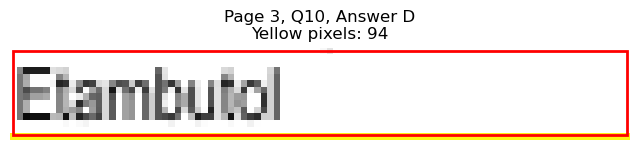

Page 3, Q10 - E: Detected box: x0=336.7, y0=754.0, x1=387.9, y1=766.7
Page 3, Q10, E: Yellow pixels: 1128
Page 3, Q10, E: Total non-white pixels: 1326
Page 3, Q10, E: Yellow percentage: 85.1%


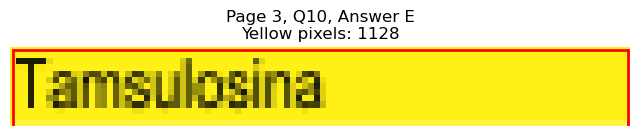


Page 3, Q10 - Selected Answer: E (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=97.7, x1=139.7, y1=110.4
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 299
Page 4, Q1, A: Yellow percentage: 0.0%


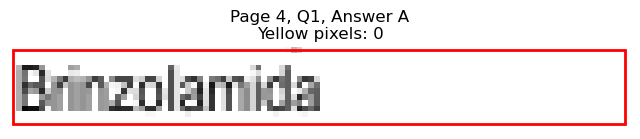

Page 4, Q1 - B: Detected box: x0=85.0, y0=110.3, x1=132.1, y1=123.0
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 237
Page 4, Q1, B: Yellow percentage: 0.0%


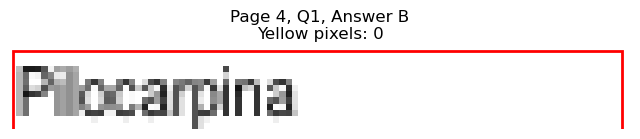

Page 4, Q1 - C: Detected box: x0=85.0, y0=122.9, x1=138.1, y1=135.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 267
Page 4, Q1, C: Yellow percentage: 0.0%


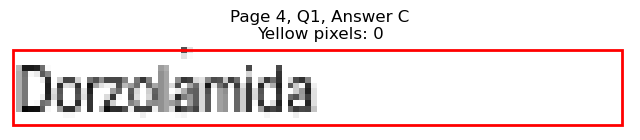

Page 4, Q1 - D: Detected box: x0=336.7, y0=97.7, x1=386.8, y1=110.4
Page 4, Q1, D: Yellow pixels: 101
Page 4, Q1, D: Total non-white pixels: 353
Page 4, Q1, D: Yellow percentage: 28.6%


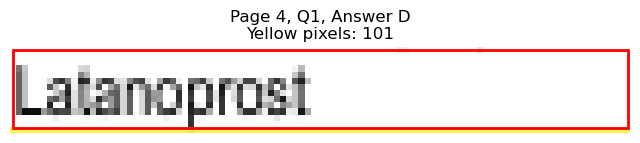

Page 4, Q1 - E: Detected box: x0=336.7, y0=110.3, x1=386.8, y1=123.0
Page 4, Q1, E: Yellow pixels: 1106
Page 4, Q1, E: Total non-white pixels: 1313
Page 4, Q1, E: Yellow percentage: 84.2%


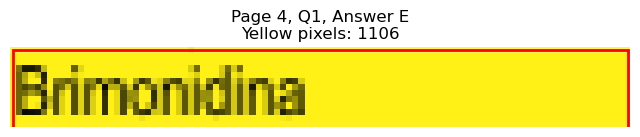


Page 4, Q1 - Selected Answer: E (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=173.4, x1=121.6, y1=186.1
Page 4, Q2, A: Yellow pixels: 88
Page 4, Q2, A: Total non-white pixels: 278
Page 4, Q2, A: Yellow percentage: 31.7%


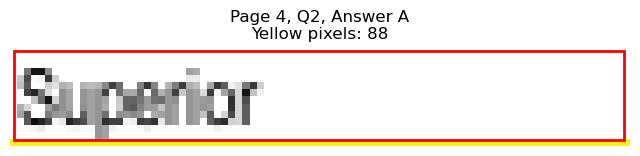

Page 4, Q2 - B: Detected box: x0=85.0, y0=186.0, x1=125.7, y1=198.7
Page 4, Q2, B: Yellow pixels: 1031
Page 4, Q2, B: Total non-white pixels: 1196
Page 4, Q2, B: Yellow percentage: 86.2%


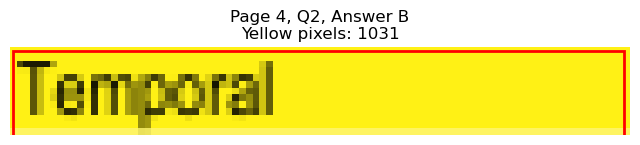

Page 4, Q2 - C: Detected box: x0=85.0, y0=198.6, x1=110.5, y1=211.3
Page 4, Q2, C: Yellow pixels: 77
Page 4, Q2, C: Total non-white pixels: 213
Page 4, Q2, C: Yellow percentage: 36.2%


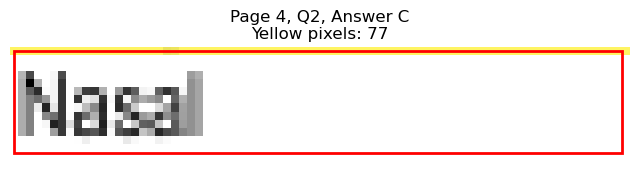

Page 4, Q2 - D: Detected box: x0=336.7, y0=173.4, x1=367.3, y1=186.1
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 151
Page 4, Q2, D: Yellow percentage: 0.0%


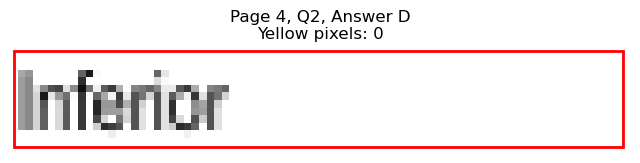

Page 4, Q2 - E: Detected box: x0=336.7, y0=186.0, x1=371.2, y1=198.7
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 182
Page 4, Q2, E: Yellow percentage: 0.0%


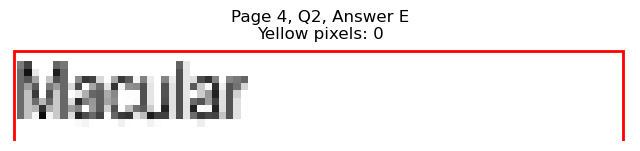


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=236.5, x1=139.7, y1=249.2
Page 4, Q3, A: Yellow pixels: 106
Page 4, Q3, A: Total non-white pixels: 382
Page 4, Q3, A: Yellow percentage: 27.7%


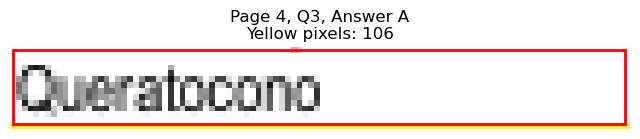

Page 4, Q3 - B: Detected box: x0=85.0, y0=249.1, x1=123.1, y1=261.8
Page 4, Q3, B: Yellow pixels: 1020
Page 4, Q3, B: Total non-white pixels: 1170
Page 4, Q3, B: Yellow percentage: 87.2%


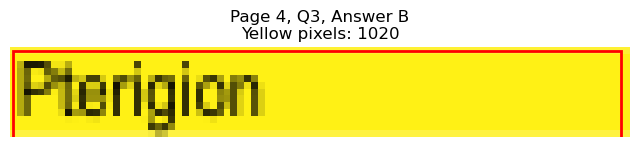

Page 4, Q3 - C: Detected box: x0=85.0, y0=261.7, x1=164.2, y1=274.4
Page 4, Q3, C: Yellow pixels: 129
Page 4, Q3, C: Total non-white pixels: 551
Page 4, Q3, C: Yellow percentage: 23.4%


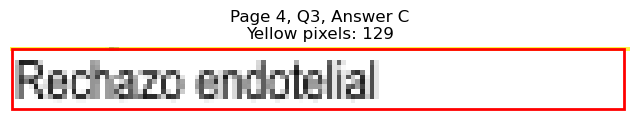

Page 4, Q3 - D: Detected box: x0=336.7, y0=236.5, x1=360.3, y1=249.2
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 115
Page 4, Q3, D: Yellow percentage: 0.0%


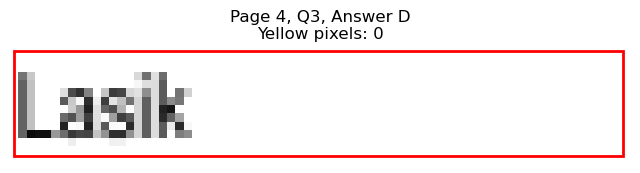

Page 4, Q3 - E: Detected box: x0=336.7, y0=249.1, x1=411.9, y1=261.8
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 375
Page 4, Q3, E: Yellow percentage: 0.0%


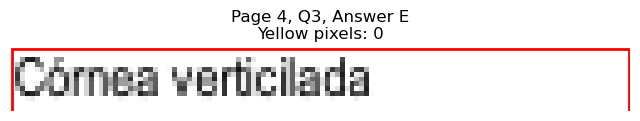


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=299.7, x1=126.6, y1=312.3
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 220
Page 4, Q4, A: Yellow percentage: 0.0%


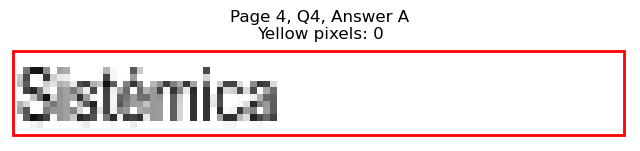

Page 4, Q4 - B: Detected box: x0=85.0, y0=312.3, x1=134.7, y1=324.9
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 276
Page 4, Q4, B: Yellow percentage: 0.0%


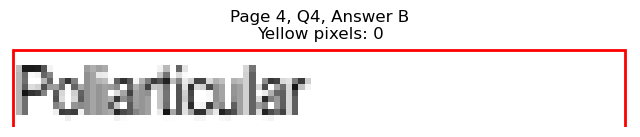

Page 4, Q4 - C: Detected box: x0=85.0, y0=324.9, x1=129.1, y1=337.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 225
Page 4, Q4, C: Yellow percentage: 0.0%


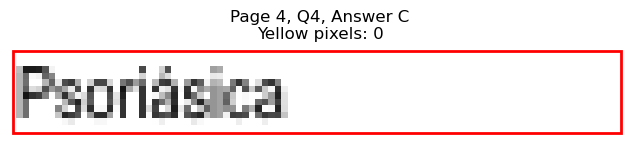

Page 4, Q4 - D: Detected box: x0=336.7, y0=299.7, x1=374.2, y1=312.3
Page 4, Q4, D: Yellow pixels: 89
Page 4, Q4, D: Total non-white pixels: 292
Page 4, Q4, D: Yellow percentage: 30.5%


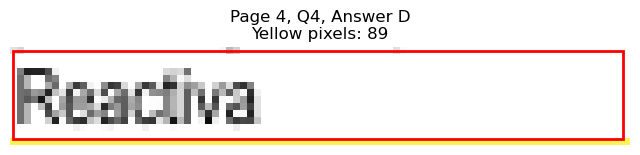

Page 4, Q4 - E: Detected box: x0=336.7, y0=312.3, x1=392.3, y1=324.9
Page 4, Q4, E: Yellow pixels: 1173
Page 4, Q4, E: Total non-white pixels: 1391
Page 4, Q4, E: Yellow percentage: 84.3%


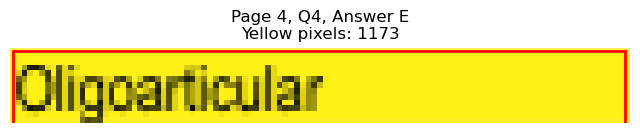


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=362.8, x1=149.2, y1=375.5
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 343
Page 4, Q5, A: Yellow percentage: 0.0%


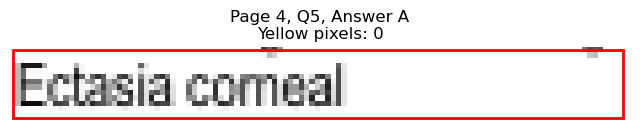

Page 4, Q5 - B: Detected box: x0=85.0, y0=375.4, x1=159.7, y1=388.1
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 365
Page 4, Q5, B: Yellow percentage: 0.0%


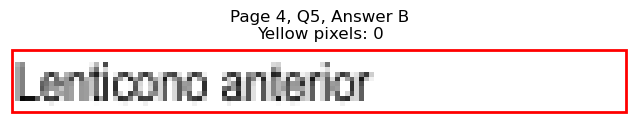

Page 4, Q5 - C: Detected box: x0=85.0, y0=388.0, x1=144.6, y1=400.7
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 300
Page 4, Q5, C: Yellow percentage: 0.0%


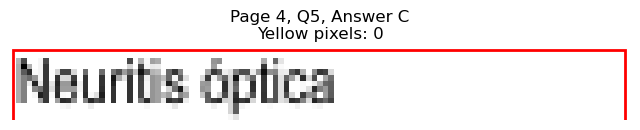

Page 4, Q5 - D: Detected box: x0=336.7, y0=362.8, x1=392.8, y1=375.5
Page 4, Q5, D: Yellow pixels: 107
Page 4, Q5, D: Total non-white pixels: 418
Page 4, Q5, D: Yellow percentage: 25.6%


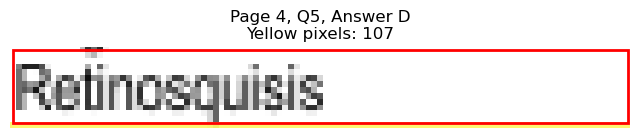

Page 4, Q5 - E: Detected box: x0=336.7, y0=375.4, x1=407.9, y1=388.1
Page 4, Q5, E: Yellow pixels: 1291
Page 4, Q5, E: Total non-white pixels: 1708
Page 4, Q5, E: Yellow percentage: 75.6%


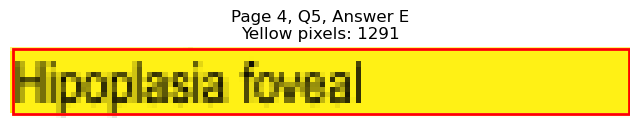


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=425.9, x1=189.3, y1=438.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 528
Page 4, Q6, A: Yellow percentage: 0.0%


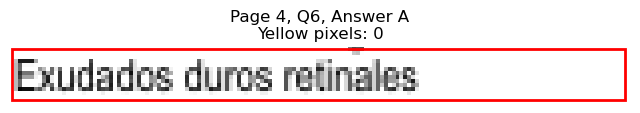

Page 4, Q6 - B: Detected box: x0=85.0, y0=438.5, x1=232.8, y1=451.2
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 734
Page 4, Q6, B: Yellow percentage: 0.0%


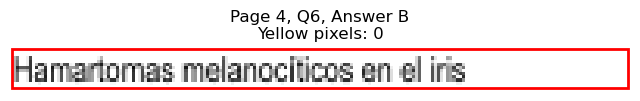

Page 4, Q6 - C: Detected box: x0=85.0, y0=451.1, x1=209.4, y1=463.8
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 620
Page 4, Q6, C: Yellow percentage: 0.0%


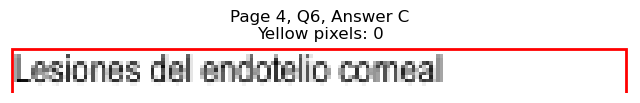

Page 4, Q6 - D: Detected box: x0=336.7, y0=425.9, x1=437.9, y1=438.6
Page 4, Q6, D: Yellow pixels: 152
Page 4, Q6, D: Total non-white pixels: 642
Page 4, Q6, D: Yellow percentage: 23.7%


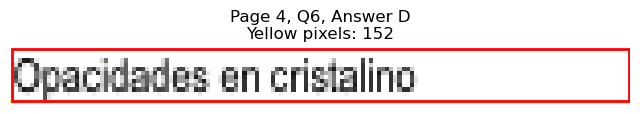

Page 4, Q6 - E: Detected box: x0=336.7, y0=438.5, x1=442.0, y1=451.2
Page 4, Q6, E: Yellow pixels: 1614
Page 4, Q6, E: Total non-white pixels: 2198
Page 4, Q6, E: Yellow percentage: 73.4%


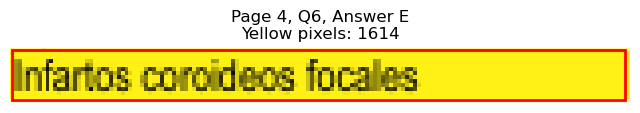


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=526.9, x1=162.3, y1=539.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 435
Page 4, Q7, A: Yellow percentage: 0.0%


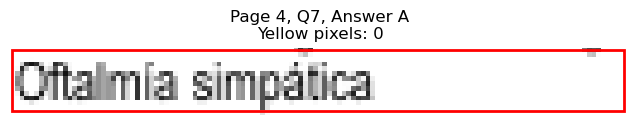

Page 4, Q7 - B: Detected box: x0=85.0, y0=539.5, x1=211.4, y1=552.1
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 666
Page 4, Q7, B: Yellow percentage: 0.0%


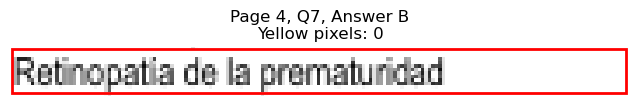

Page 4, Q7 - C: Detected box: x0=85.0, y0=552.2, x1=174.3, y1=564.8
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 462
Page 4, Q7, C: Yellow percentage: 0.0%


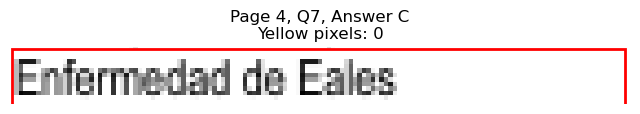

Page 4, Q7 - D: Detected box: x0=336.7, y0=526.9, x1=439.0, y1=539.5
Page 4, Q7, D: Yellow pixels: 154
Page 4, Q7, D: Total non-white pixels: 670
Page 4, Q7, D: Yellow percentage: 23.0%


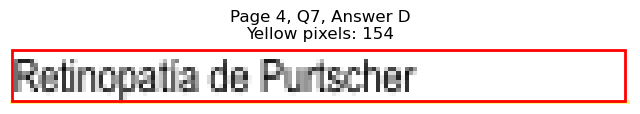

Page 4, Q7 - E: Detected box: x0=336.7, y0=539.5, x1=426.9, y1=552.1
Page 4, Q7, E: Yellow pixels: 1480
Page 4, Q7, E: Total non-white pixels: 1974
Page 4, Q7, E: Yellow percentage: 75.0%


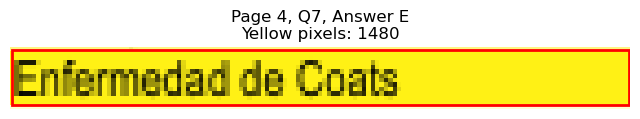


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=590.0, x1=120.0, y1=602.6
Page 4, Q8, A: Yellow pixels: 87
Page 4, Q8, A: Total non-white pixels: 243
Page 4, Q8, A: Yellow percentage: 35.8%


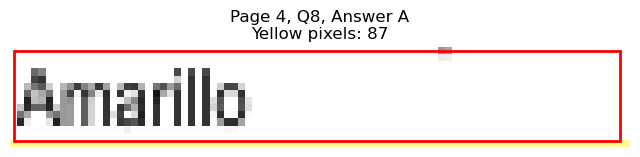

Page 4, Q8 - B: Detected box: x0=85.0, y0=602.6, x1=106.1, y1=615.2
Page 4, Q8, B: Yellow pixels: 870
Page 4, Q8, B: Total non-white pixels: 1022
Page 4, Q8, B: Yellow percentage: 85.1%


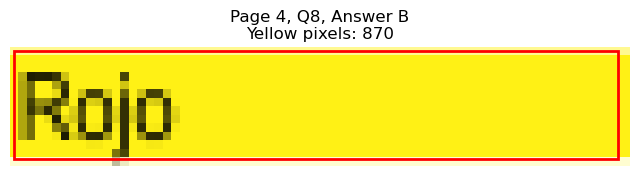

Page 4, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=111.6, y1=627.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 204
Page 4, Q8, C: Yellow percentage: 0.0%


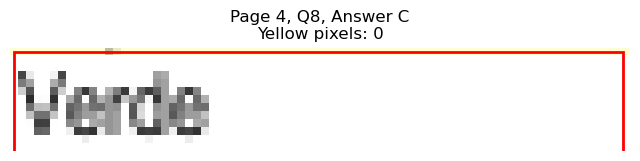

Page 4, Q8 - D: Detected box: x0=336.7, y0=590.0, x1=356.7, y1=602.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 92
Page 4, Q8, D: Yellow percentage: 0.0%


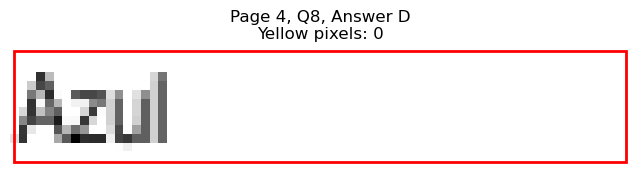

Page 4, Q8 - E: Detected box: x0=336.7, y0=602.6, x1=377.3, y1=615.2
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 197
Page 4, Q8, E: Yellow percentage: 0.0%


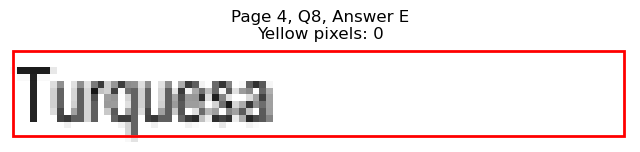


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=653.1, x1=146.7, y1=665.8
Page 4, Q9, A: Yellow pixels: 1233
Page 4, Q9, A: Total non-white pixels: 1469
Page 4, Q9, A: Yellow percentage: 83.9%


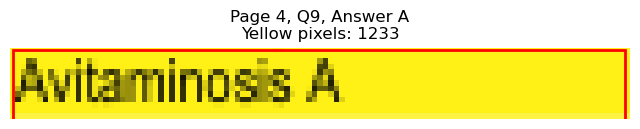

Page 4, Q9 - B: Detected box: x0=85.0, y0=665.7, x1=147.6, y1=678.4
Page 4, Q9, B: Yellow pixels: 114
Page 4, Q9, B: Total non-white pixels: 442
Page 4, Q9, B: Yellow percentage: 25.8%


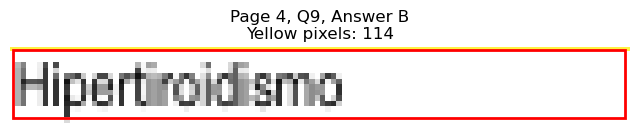

Page 4, Q9 - C: Detected box: x0=85.0, y0=678.3, x1=163.2, y1=691.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 381
Page 4, Q9, C: Yellow percentage: 0.0%


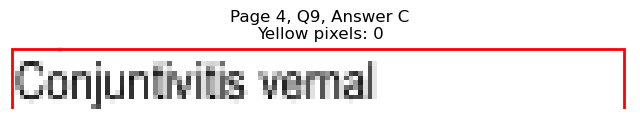

Page 4, Q9 - D: Detected box: x0=336.7, y0=653.1, x1=379.3, y1=665.8
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 230
Page 4, Q9, D: Yellow percentage: 0.0%


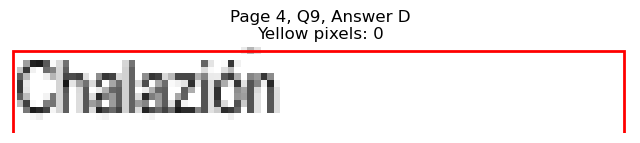

Page 4, Q9 - E: Detected box: x0=336.7, y0=665.7, x1=387.3, y1=678.4
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 287
Page 4, Q9, E: Yellow percentage: 0.0%


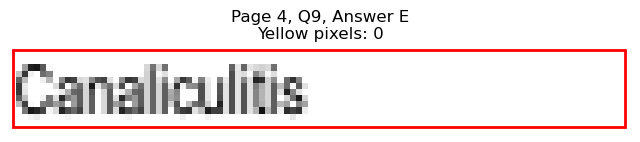


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=85.0, y0=716.3, x1=148.7, y1=728.9
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 311
Page 4, Q10, A: Yellow percentage: 0.0%


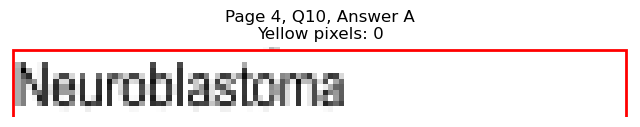

Page 4, Q10 - B: Detected box: x0=85.0, y0=728.9, x1=163.2, y1=741.5
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 394
Page 4, Q10, B: Yellow percentage: 0.0%


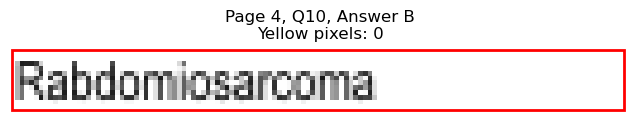

Page 4, Q10 - C: Detected box: x0=85.0, y0=741.4, x1=163.7, y1=754.1
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 402
Page 4, Q10, C: Yellow percentage: 0.0%


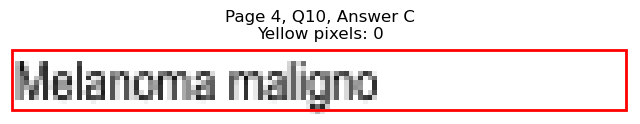

Page 4, Q10 - D: Detected box: x0=336.7, y0=716.3, x1=404.8, y1=728.9
Page 4, Q10, D: Yellow pixels: 1295
Page 4, Q10, D: Total non-white pixels: 1547
Page 4, Q10, D: Yellow percentage: 83.7%


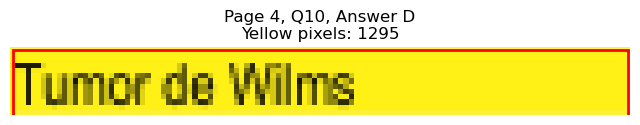

Page 4, Q10 - E: Detected box: x0=336.7, y0=728.9, x1=417.9, y1=741.5
Page 4, Q10, E: Yellow pixels: 132
Page 4, Q10, E: Total non-white pixels: 516
Page 4, Q10, E: Yellow percentage: 25.6%


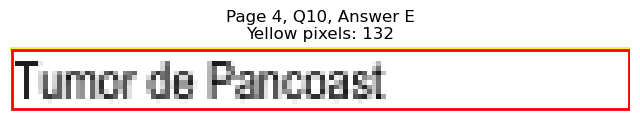


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=97.7, x1=134.7, y1=110.4
Page 5, Q1, A: Yellow pixels: 1009
Page 5, Q1, A: Total non-white pixels: 1414
Page 5, Q1, A: Yellow percentage: 71.4%


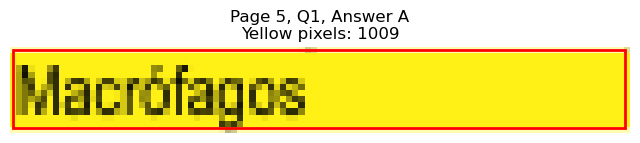

Page 5, Q1 - B: Detected box: x0=85.0, y0=110.3, x1=127.6, y1=123.0
Page 5, Q1, B: Yellow pixels: 1
Page 5, Q1, B: Total non-white pixels: 313
Page 5, Q1, B: Yellow percentage: 0.3%


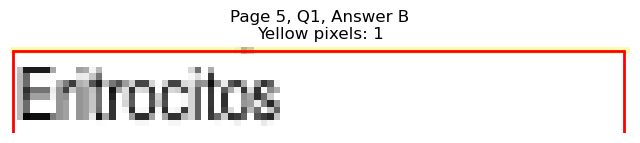

Page 5, Q1 - C: Detected box: x0=85.0, y0=122.9, x1=127.6, y1=135.6
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 218
Page 5, Q1, C: Yellow percentage: 0.0%


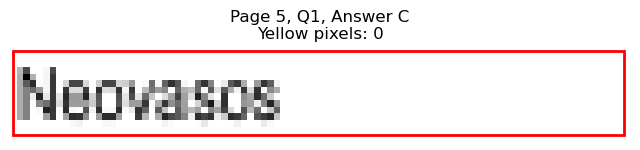

Page 5, Q1 - D: Detected box: x0=336.7, y0=97.7, x1=387.3, y1=110.4
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 280
Page 5, Q1, D: Yellow percentage: 0.0%


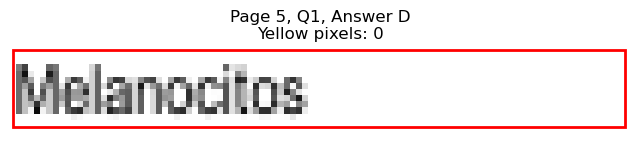

Page 5, Q1 - E: Detected box: x0=336.7, y0=110.3, x1=388.3, y1=123.0
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 280
Page 5, Q1, E: Yellow percentage: 0.0%


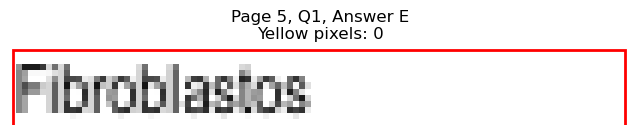


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=160.8, x1=137.2, y1=173.5
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 281
Page 5, Q2, A: Yellow percentage: 0.0%


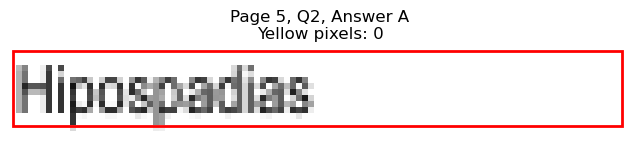

Page 5, Q2 - B: Detected box: x0=85.0, y0=173.4, x1=176.3, y1=186.1
Page 5, Q2, B: Yellow pixels: 143
Page 5, Q2, B: Total non-white pixels: 587
Page 5, Q2, B: Yellow percentage: 24.4%


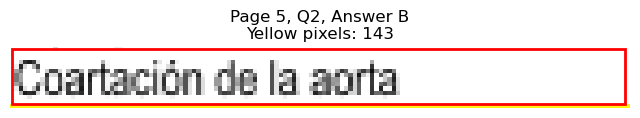

Page 5, Q2 - C: Detected box: x0=85.0, y0=186.0, x1=180.3, y1=198.7
Page 5, Q2, C: Yellow pixels: 1548
Page 5, Q2, C: Total non-white pixels: 1911
Page 5, Q2, C: Yellow percentage: 81.0%


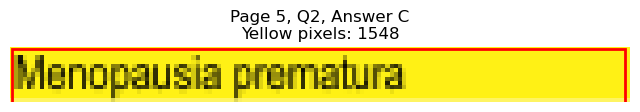

Page 5, Q2 - D: Detected box: x0=336.7, y0=160.8, x1=412.4, y1=173.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 399
Page 5, Q2, D: Yellow percentage: 0.0%


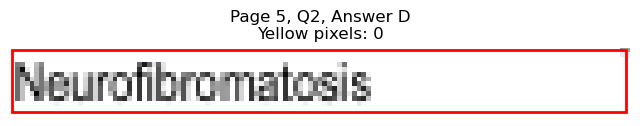

Page 5, Q2 - E: Detected box: x0=336.7, y0=173.4, x1=443.5, y1=186.1
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 536
Page 5, Q2, E: Yellow percentage: 0.0%


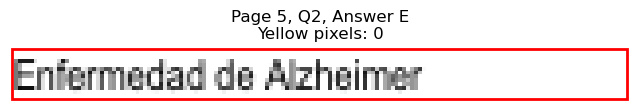


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=223.9, x1=249.5, y1=236.6
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 818
Page 5, Q3, A: Yellow percentage: 0.0%


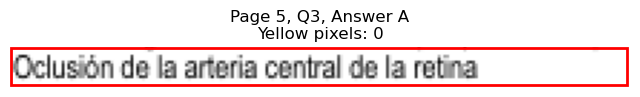

Page 5, Q3 - B: Detected box: x0=85.0, y0=236.5, x1=193.8, y1=249.2
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 545
Page 5, Q3, B: Yellow percentage: 0.0%


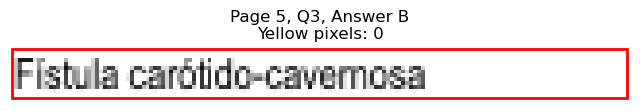

Page 5, Q3 - C: Detected box: x0=85.0, y0=249.1, x1=245.4, y1=261.8
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 838
Page 5, Q3, C: Yellow percentage: 0.0%


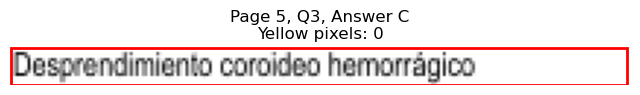

Page 5, Q3 - D: Detected box: x0=336.7, y0=223.9, x1=508.3, y1=236.6
Page 5, Q3, D: Yellow pixels: 189
Page 5, Q3, D: Total non-white pixels: 1052
Page 5, Q3, D: Yellow percentage: 18.0%


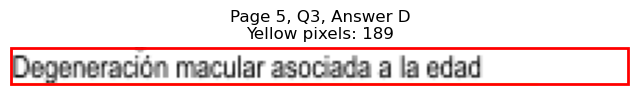

Page 5, Q3 - E: Detected box: x0=336.7, y0=236.5, x1=495.1, y1=249.2
Page 5, Q3, E: Yellow pixels: 1871
Page 5, Q3, E: Total non-white pixels: 2660
Page 5, Q3, E: Yellow percentage: 70.3%


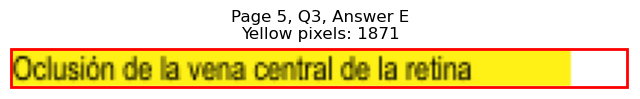


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=287.1, x1=233.4, y1=299.7
Page 5, Q4, A: Yellow pixels: 1866
Page 5, Q4, A: Total non-white pixels: 2483
Page 5, Q4, A: Yellow percentage: 75.2%


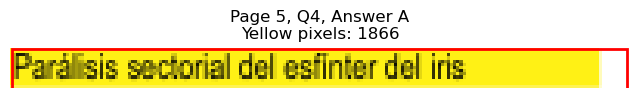

Page 5, Q4 - B: Detected box: x0=85.0, y0=299.7, x1=151.7, y1=312.3
Page 5, Q4, B: Yellow pixels: 118
Page 5, Q4, B: Total non-white pixels: 490
Page 5, Q4, B: Yellow percentage: 24.1%


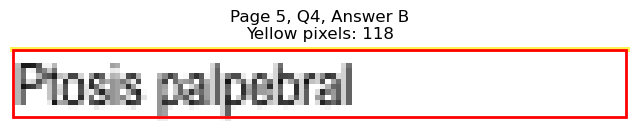

Page 5, Q4 - C: Detected box: x0=85.0, y0=312.3, x1=170.8, y1=324.9
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 432
Page 5, Q4, C: Yellow percentage: 0.0%


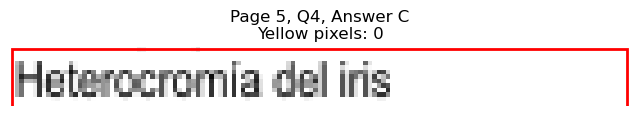

Page 5, Q4 - D: Detected box: x0=336.7, y0=287.1, x1=507.7, y1=299.7
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 861
Page 5, Q4, D: Yellow percentage: 0.0%


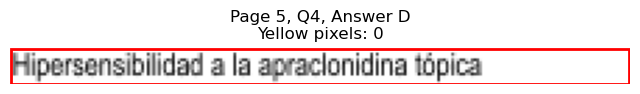

Page 5, Q4 - E: Detected box: x0=336.7, y0=299.7, x1=408.9, y1=312.3
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 362
Page 5, Q4, E: Yellow percentage: 0.0%


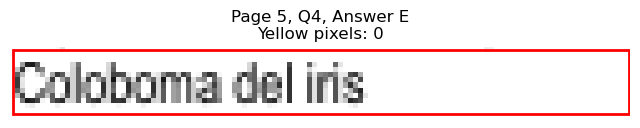


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=350.2, x1=116.1, y1=362.9
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 143
Page 5, Q5, A: Yellow percentage: 0.0%


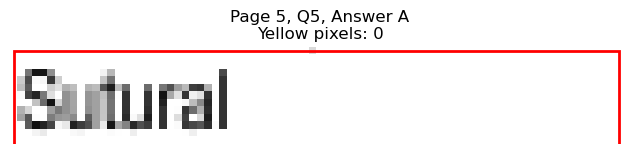

Page 5, Q5 - B: Detected box: x0=85.0, y0=362.8, x1=146.2, y1=375.5
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 300
Page 5, Q5, B: Yellow percentage: 0.0%


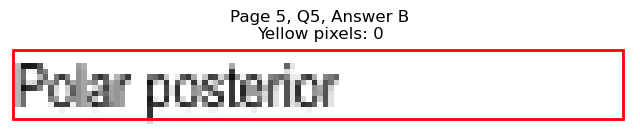

Page 5, Q5 - C: Detected box: x0=85.0, y0=375.4, x1=141.6, y1=388.1
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 289
Page 5, Q5, C: Yellow percentage: 0.0%


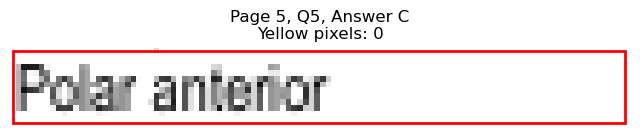

Page 5, Q5 - D: Detected box: x0=336.7, y0=350.2, x1=371.8, y1=362.9
Page 5, Q5, D: Yellow pixels: 985
Page 5, Q5, D: Total non-white pixels: 1118
Page 5, Q5, D: Yellow percentage: 88.1%


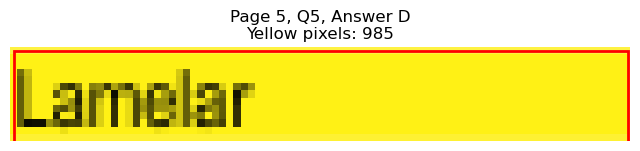

Page 5, Q5 - E: Detected box: x0=336.7, y0=362.8, x1=375.3, y1=375.5
Page 5, Q5, E: Yellow pixels: 90
Page 5, Q5, E: Total non-white pixels: 295
Page 5, Q5, E: Yellow percentage: 30.5%


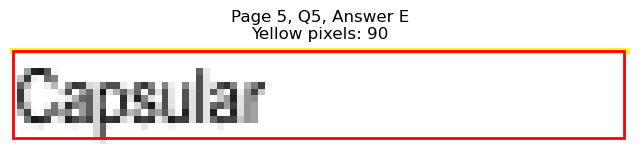


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=451.1, x1=243.0, y1=463.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 988
Page 5, Q6, A: Yellow percentage: 0.0%


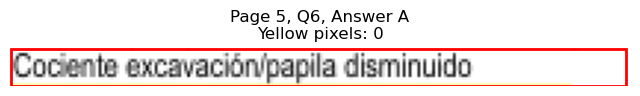

Page 5, Q6 - B: Detected box: x0=85.0, y0=463.7, x1=227.9, y1=476.4
Page 5, Q6, B: Yellow pixels: 1724
Page 5, Q6, B: Total non-white pixels: 2674
Page 5, Q6, B: Yellow percentage: 64.5%


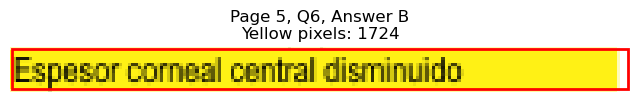

Page 5, Q6 - C: Detected box: x0=85.0, y0=476.3, x1=137.7, y1=489.0
Page 5, Q6, C: Yellow pixels: 1
Page 5, Q6, C: Total non-white pixels: 350
Page 5, Q6, C: Yellow percentage: 0.3%


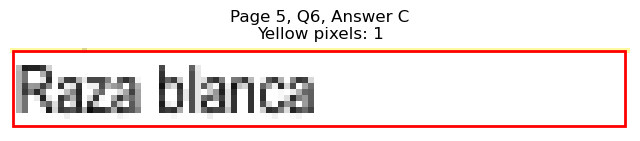

Page 5, Q6 - D: Detected box: x0=336.7, y0=463.7, x1=396.3, y1=476.4
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 323
Page 5, Q6, D: Yellow percentage: 0.0%


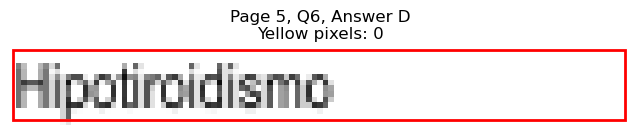

Page 5, Q6 - E: Detected box: x0=336.7, y0=476.3, x1=439.5, y1=489.0
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 523
Page 5, Q6, E: Yellow percentage: 0.0%


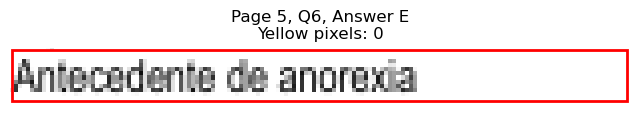


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=514.3, x1=115.1, y1=526.9
Page 5, Q7, A: Yellow pixels: 952
Page 5, Q7, A: Total non-white pixels: 1066
Page 5, Q7, A: Yellow percentage: 89.3%


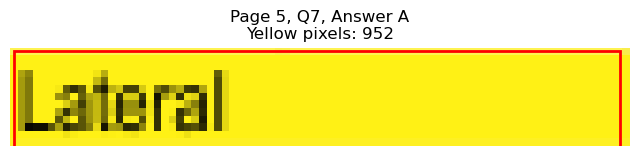

Page 5, Q7 - B: Detected box: x0=85.0, y0=526.9, x1=115.6, y1=539.5
Page 5, Q7, B: Yellow pixels: 82
Page 5, Q7, B: Total non-white pixels: 229
Page 5, Q7, B: Yellow percentage: 35.8%


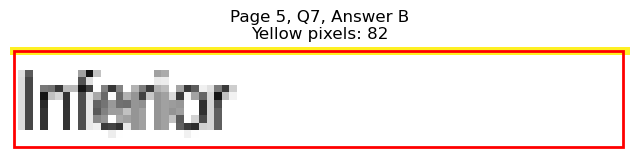

Page 5, Q7 - C: Detected box: x0=85.0, y0=539.5, x1=114.0, y1=552.1
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 143
Page 5, Q7, C: Yellow percentage: 0.0%


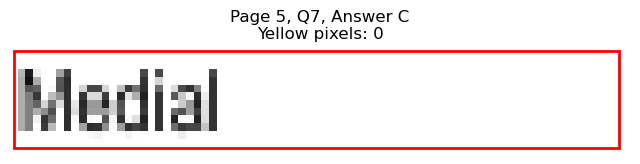

Page 5, Q7 - D: Detected box: x0=336.7, y0=514.3, x1=373.3, y1=526.9
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 189
Page 5, Q7, D: Yellow percentage: 0.0%


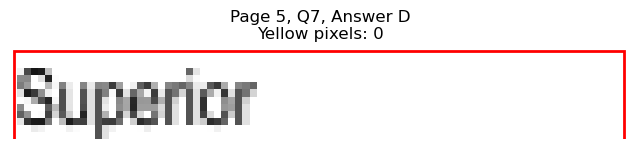

Page 5, Q7 - E: Detected box: x0=336.7, y0=526.9, x1=375.3, y1=539.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 191
Page 5, Q7, E: Yellow percentage: 0.0%


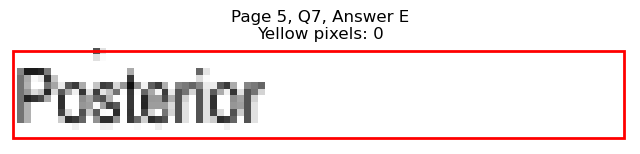


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=577.4, x1=160.1, y1=590.0
Page 5, Q8, A: Yellow pixels: 127
Page 5, Q8, A: Total non-white pixels: 564
Page 5, Q8, A: Yellow percentage: 22.5%


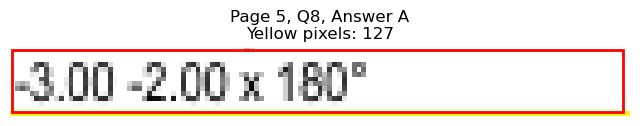

Page 5, Q8 - B: Detected box: x0=85.0, y0=590.0, x1=155.1, y1=602.6
Page 5, Q8, B: Yellow pixels: 1367
Page 5, Q8, B: Total non-white pixels: 1708
Page 5, Q8, B: Yellow percentage: 80.0%


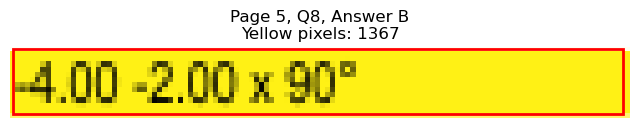

Page 5, Q8 - C: Detected box: x0=85.0, y0=602.6, x1=157.3, y1=615.2
Page 5, Q8, C: Yellow pixels: 124
Page 5, Q8, C: Total non-white pixels: 434
Page 5, Q8, C: Yellow percentage: 28.6%


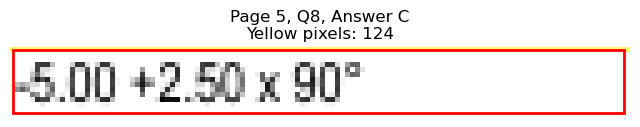

Page 5, Q8 - D: Detected box: x0=336.7, y0=577.4, x1=406.7, y1=590.0
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 301
Page 5, Q8, D: Yellow percentage: 0.0%


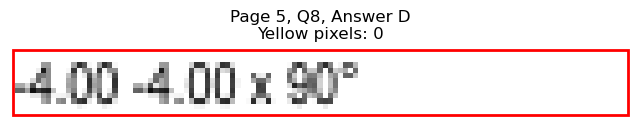

Page 5, Q8 - E: Detected box: x0=336.7, y0=590.0, x1=411.8, y1=602.6
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 319
Page 5, Q8, E: Yellow percentage: 0.0%


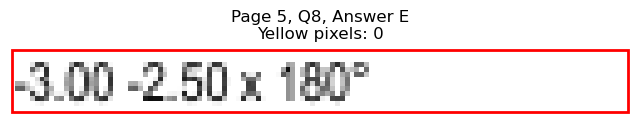


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=653.1, x1=119.5, y1=665.8
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 257
Page 5, Q9, A: Yellow percentage: 0.0%


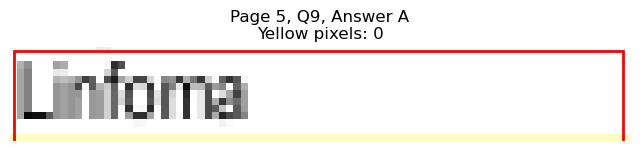

Page 5, Q9 - B: Detected box: x0=85.0, y0=665.7, x1=134.2, y1=678.4
Page 5, Q9, B: Yellow pixels: 1014
Page 5, Q9, B: Total non-white pixels: 1414
Page 5, Q9, B: Yellow percentage: 71.7%


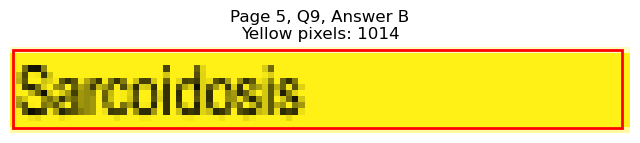

Page 5, Q9 - C: Detected box: x0=85.0, y0=678.3, x1=145.1, y1=691.0
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 431
Page 5, Q9, C: Yellow percentage: 0.0%


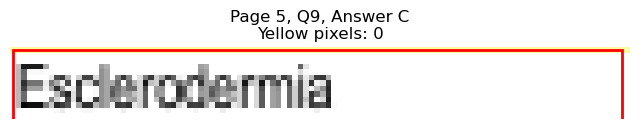

Page 5, Q9 - D: Detected box: x0=336.7, y0=653.1, x1=415.9, y1=665.8
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 420
Page 5, Q9, D: Yellow percentage: 0.0%


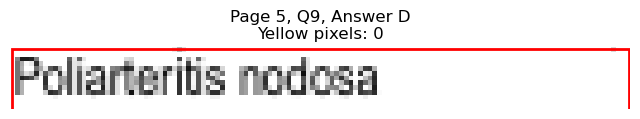

Page 5, Q9 - E: Detected box: x0=336.7, y0=665.7, x1=403.9, y1=678.4
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 360
Page 5, Q9, E: Yellow percentage: 0.0%


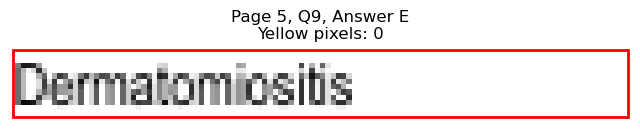


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=85.0, y0=716.3, x1=223.5, y1=728.9
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 763
Page 5, Q10, A: Yellow percentage: 0.0%


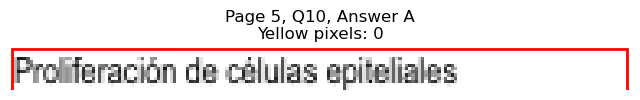

Page 5, Q10 - B: Detected box: x0=85.0, y0=728.9, x1=242.9, y1=741.5
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 782
Page 5, Q10, B: Yellow percentage: 0.0%


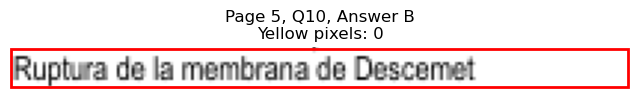

Page 5, Q10 - C: Detected box: x0=85.0, y0=741.4, x1=179.3, y1=754.1
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 482
Page 5, Q10, C: Yellow percentage: 0.0%


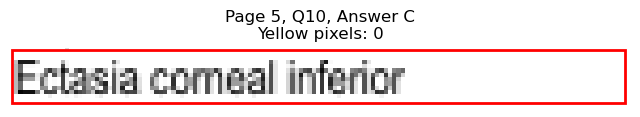

Page 5, Q10 - D: Detected box: x0=336.7, y0=716.3, x1=438.4, y1=728.9
Page 5, Q10, D: Yellow pixels: 1583
Page 5, Q10, D: Total non-white pixels: 1989
Page 5, Q10, D: Yellow percentage: 79.6%


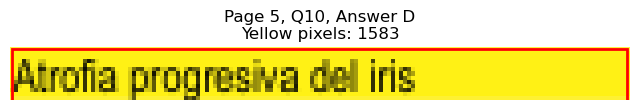

Page 5, Q10 - E: Detected box: x0=336.7, y0=728.9, x1=436.6, y1=741.5
Page 5, Q10, E: Yellow pixels: 146
Page 5, Q10, E: Total non-white pixels: 660
Page 5, Q10, E: Yellow percentage: 22.1%


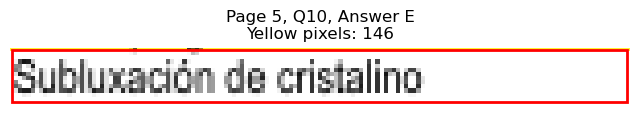


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=97.7, x1=153.7, y1=110.4
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 377
Page 6, Q1, A: Yellow percentage: 0.0%


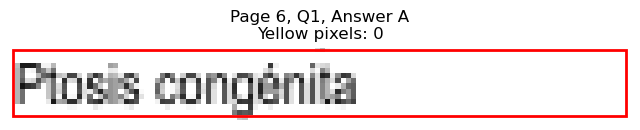

Page 6, Q1 - B: Detected box: x0=85.0, y0=110.3, x1=152.7, y1=123.0
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 478
Page 6, Q1, B: Yellow percentage: 0.0%


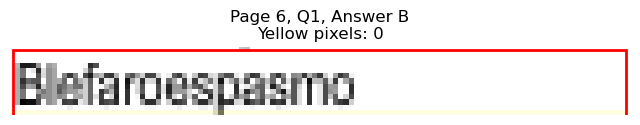

Page 6, Q1 - C: Detected box: x0=85.0, y0=122.9, x1=169.2, y1=135.6
Page 6, Q1, C: Yellow pixels: 1476
Page 6, Q1, C: Total non-white pixels: 1904
Page 6, Q1, C: Yellow percentage: 77.5%


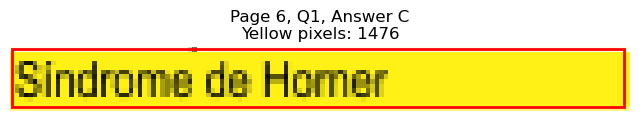

Page 6, Q1 - D: Detected box: x0=336.7, y0=97.7, x1=404.3, y1=110.4
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 368
Page 6, Q1, D: Yellow percentage: 0.0%


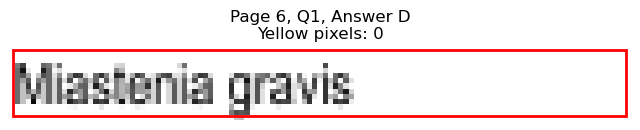

Page 6, Q1 - E: Detected box: x0=336.7, y0=110.3, x1=432.4, y1=123.0
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 498
Page 6, Q1, E: Yellow percentage: 0.0%


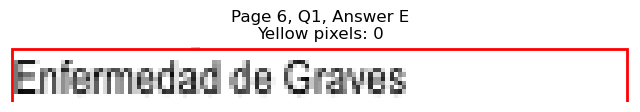


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=160.8, x1=139.7, y1=173.5
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 280
Page 6, Q2, A: Yellow percentage: 0.0%


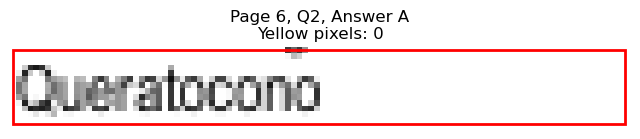

Page 6, Q2 - B: Detected box: x0=85.0, y0=173.4, x1=168.3, y1=186.1
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 454
Page 6, Q2, B: Yellow percentage: 0.0%


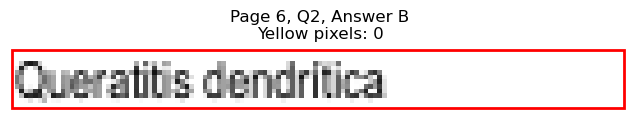

Page 6, Q2 - C: Detected box: x0=85.0, y0=186.0, x1=157.2, y1=198.7
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 364
Page 6, Q2, C: Yellow percentage: 0.0%


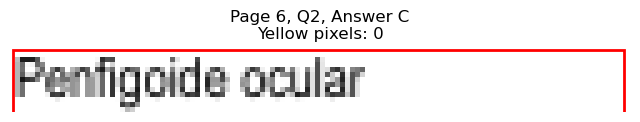

Page 6, Q2 - D: Detected box: x0=336.7, y0=160.8, x1=374.8, y1=173.5
Page 6, Q2, D: Yellow pixels: 1028
Page 6, Q2, D: Total non-white pixels: 1246
Page 6, Q2, D: Yellow percentage: 82.5%


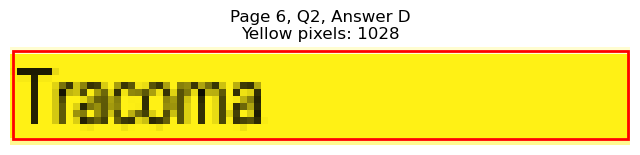

Page 6, Q2 - E: Detected box: x0=336.7, y0=173.4, x1=422.0, y1=186.1
Page 6, Q2, E: Yellow pixels: 136
Page 6, Q2, E: Total non-white pixels: 587
Page 6, Q2, E: Yellow percentage: 23.2%


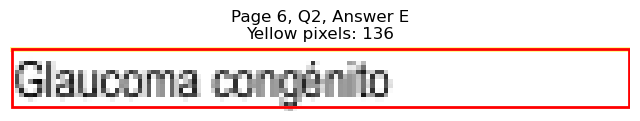


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=249.1, x1=170.2, y1=261.8
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 455
Page 6, Q3, A: Yellow percentage: 0.0%


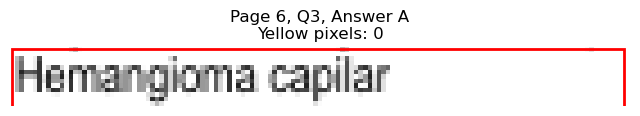

Page 6, Q3 - B: Detected box: x0=85.0, y0=261.7, x1=167.8, y1=274.4
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 417
Page 6, Q3, B: Yellow percentage: 0.0%


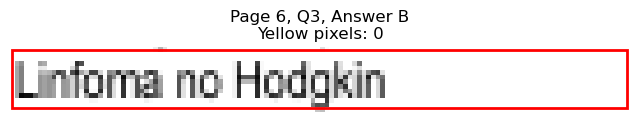

Page 6, Q3 - C: Detected box: x0=85.0, y0=274.5, x1=193.8, y1=287.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 547
Page 6, Q3, C: Yellow percentage: 0.0%


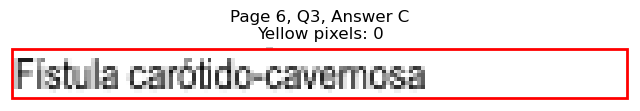

Page 6, Q3 - D: Detected box: x0=336.7, y0=249.1, x1=437.0, y1=261.8
Page 6, Q3, D: Yellow pixels: 1571
Page 6, Q3, D: Total non-white pixels: 1963
Page 6, Q3, D: Yellow percentage: 80.0%


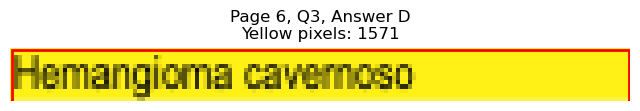

Page 6, Q3 - E: Detected box: x0=336.7, y0=261.7, x1=414.9, y1=274.4
Page 6, Q3, E: Yellow pixels: 127
Page 6, Q3, E: Total non-white pixels: 527
Page 6, Q3, E: Yellow percentage: 24.1%


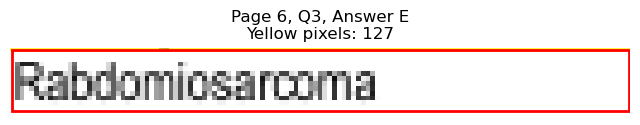


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=312.3, x1=135.1, y1=324.9
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 260
Page 6, Q4, A: Yellow percentage: 0.0%


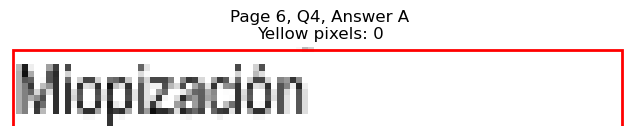

Page 6, Q4 - B: Detected box: x0=85.0, y0=324.9, x1=176.3, y1=337.5
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 475
Page 6, Q4, B: Yellow percentage: 0.0%


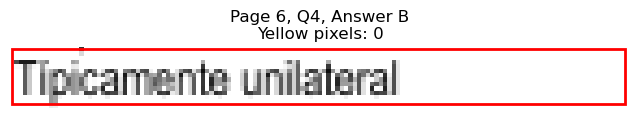

Page 6, Q4 - C: Detected box: x0=85.0, y0=337.5, x1=180.3, y1=350.1
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 470
Page 6, Q4, C: Yellow percentage: 0.0%


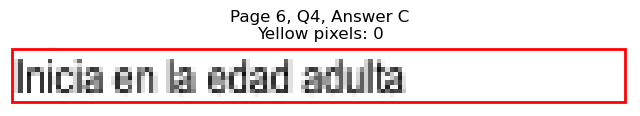

Page 6, Q4 - D: Detected box: x0=336.7, y0=312.3, x1=450.5, y1=324.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 745
Page 6, Q4, D: Yellow percentage: 0.0%


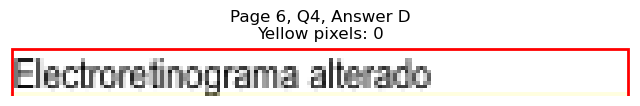

Page 6, Q4 - E: Detected box: x0=336.7, y0=324.9, x1=449.5, y1=337.5
Page 6, Q4, E: Yellow pixels: 1665
Page 6, Q4, E: Total non-white pixels: 2296
Page 6, Q4, E: Yellow percentage: 72.5%


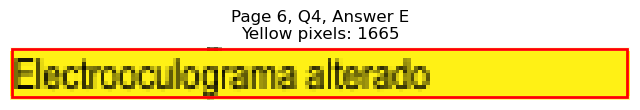


Page 6, Q4 - Selected Answer: E (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=375.4, x1=184.2, y1=388.1
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 516
Page 6, Q5, A: Yellow percentage: 0.0%


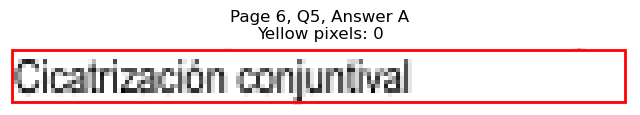

Page 6, Q5 - B: Detected box: x0=85.0, y0=388.0, x1=129.6, y1=400.7
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 321
Page 6, Q5, B: Yellow percentage: 0.0%


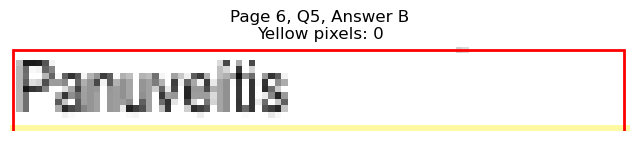

Page 6, Q5 - C: Detected box: x0=85.0, y0=400.6, x1=186.7, y1=413.3
Page 6, Q5, C: Yellow pixels: 1415
Page 6, Q5, C: Total non-white pixels: 2142
Page 6, Q5, C: Yellow percentage: 66.1%


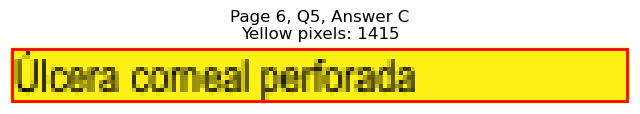

Page 6, Q5 - D: Detected box: x0=336.7, y0=375.4, x1=439.0, y1=388.1
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 522
Page 6, Q5, D: Yellow percentage: 0.0%


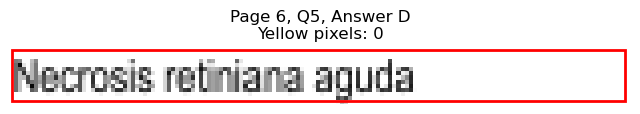

Page 6, Q5 - E: Detected box: x0=336.7, y0=388.0, x1=425.9, y1=400.7
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 410
Page 6, Q5, E: Yellow percentage: 0.0%


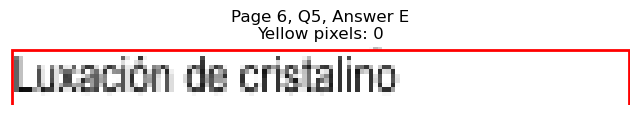


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=451.1, x1=137.2, y1=463.8
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 249
Page 6, Q6, A: Yellow percentage: 0.0%


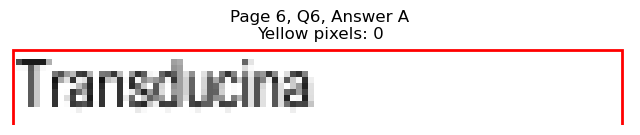

Page 6, Q6 - B: Detected box: x0=85.0, y0=463.7, x1=130.6, y1=476.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 239
Page 6, Q6, B: Yellow percentage: 0.0%


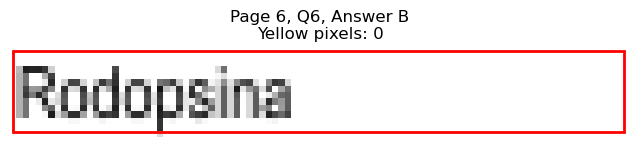

Page 6, Q6 - C: Detected box: x0=85.0, y0=476.3, x1=117.6, y1=489.0
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 165
Page 6, Q6, C: Yellow percentage: 0.0%


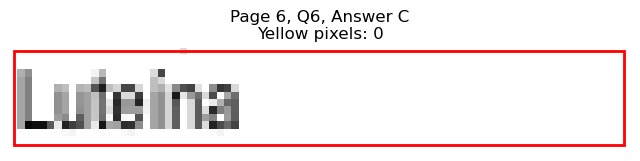

Page 6, Q6 - D: Detected box: x0=336.7, y0=451.1, x1=383.8, y1=463.8
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 342
Page 6, Q6, D: Yellow percentage: 0.0%


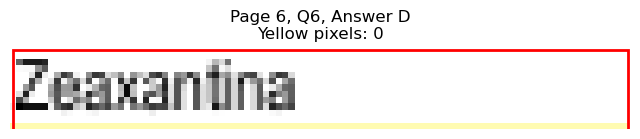

Page 6, Q6 - E: Detected box: x0=336.7, y0=463.7, x1=384.8, y1=476.4
Page 6, Q6, E: Yellow pixels: 996
Page 6, Q6, E: Total non-white pixels: 1386
Page 6, Q6, E: Yellow percentage: 71.9%


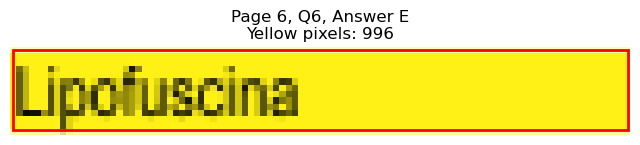


Page 6, Q6 - Selected Answer: E (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=539.5, x1=183.7, y1=552.1
Page 6, Q7, A: Yellow pixels: 1540
Page 6, Q7, A: Total non-white pixels: 2100
Page 6, Q7, A: Yellow percentage: 73.3%


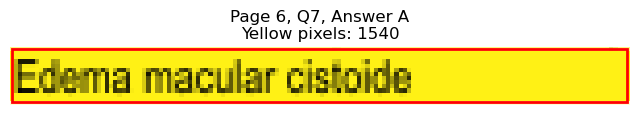

Page 6, Q7 - B: Detected box: x0=85.0, y0=552.2, x1=256.6, y1=564.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 1030
Page 6, Q7, B: Yellow percentage: 0.0%


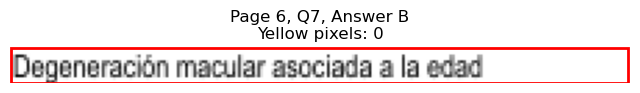

Page 6, Q7 - C: Detected box: x0=85.0, y0=564.8, x1=213.9, y1=577.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 661
Page 6, Q7, C: Yellow percentage: 0.0%


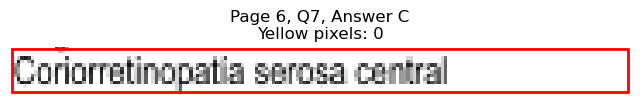

Page 6, Q7 - D: Detected box: x0=336.7, y0=539.5, x1=450.4, y1=552.1
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 580
Page 6, Q7, D: Yellow percentage: 0.0%


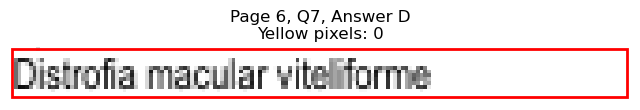

Page 6, Q7 - E: Detected box: x0=336.7, y0=552.2, x1=431.5, y1=564.8
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 509
Page 6, Q7, E: Yellow percentage: 0.0%


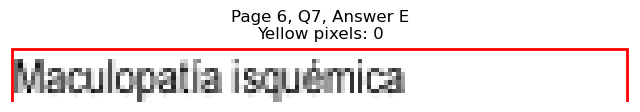


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=124.6, y1=627.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 174
Page 6, Q8, A: Yellow percentage: 0.0%


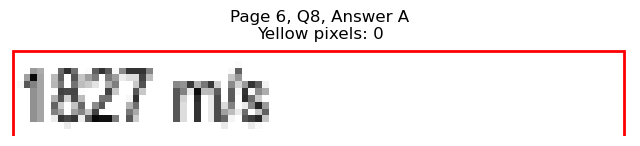

Page 6, Q8 - B: Detected box: x0=85.0, y0=627.9, x1=124.6, y1=640.6
Page 6, Q8, B: Yellow pixels: 91
Page 6, Q8, B: Total non-white pixels: 276
Page 6, Q8, B: Yellow percentage: 33.0%


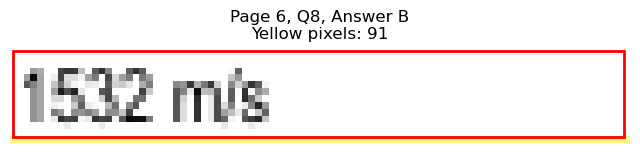

Page 6, Q8 - C: Detected box: x0=85.0, y0=640.5, x1=119.5, y1=653.2
Page 6, Q8, C: Yellow pixels: 971
Page 6, Q8, C: Total non-white pixels: 1204
Page 6, Q8, C: Yellow percentage: 80.6%


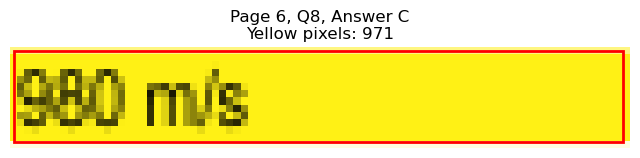

Page 6, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=371.2, y1=627.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 164
Page 6, Q8, D: Yellow percentage: 0.0%


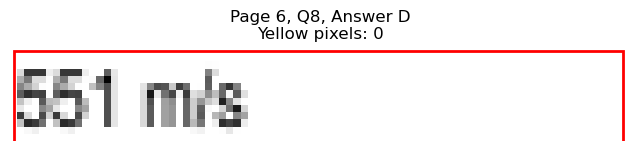

Page 6, Q8 - E: Detected box: x0=336.7, y0=627.9, x1=371.2, y1=640.6
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 165
Page 6, Q8, E: Yellow percentage: 0.0%


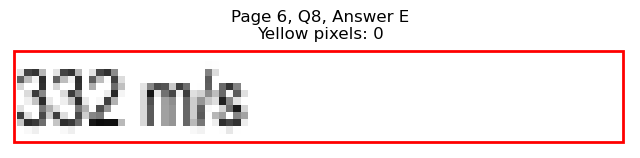


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=678.3, x1=123.6, y1=691.0
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 204
Page 6, Q9, A: Yellow percentage: 0.0%


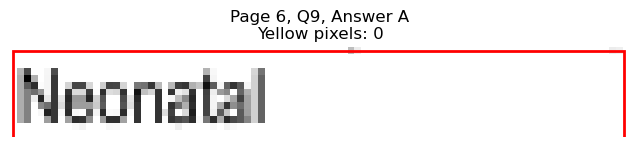

Page 6, Q9 - B: Detected box: x0=85.0, y0=691.1, x1=113.5, y1=703.7
Page 6, Q9, B: Yellow pixels: 914
Page 6, Q9, B: Total non-white pixels: 1040
Page 6, Q9, B: Yellow percentage: 87.9%


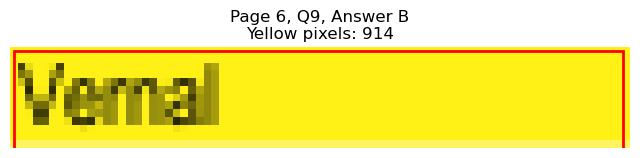

Page 6, Q9 - C: Detected box: x0=85.0, y0=703.7, x1=118.6, y1=716.3
Page 6, Q9, C: Yellow pixels: 85
Page 6, Q9, C: Total non-white pixels: 266
Page 6, Q9, C: Yellow percentage: 32.0%


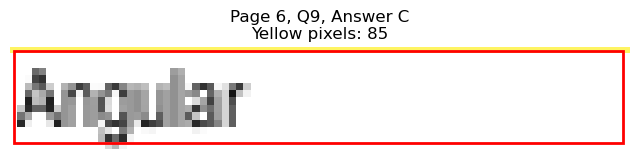

Page 6, Q9 - D: Detected box: x0=336.7, y0=678.3, x1=373.3, y1=691.0
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 190
Page 6, Q9, D: Yellow percentage: 0.0%


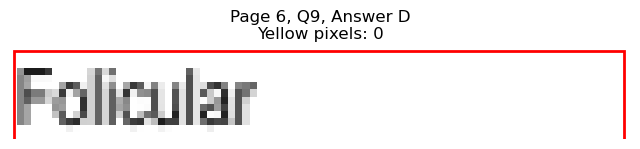

Page 6, Q9 - E: Detected box: x0=336.7, y0=691.1, x1=373.7, y1=703.7
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 214
Page 6, Q9, E: Yellow percentage: 0.0%


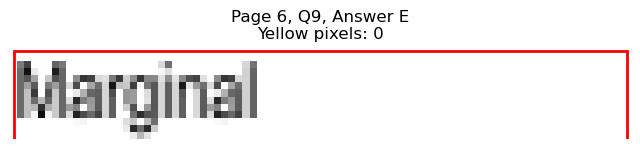


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=110.3, x1=196.8, y1=123.0
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 594
Page 7, Q1, A: Yellow percentage: 0.0%


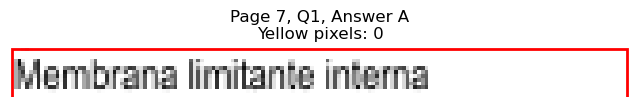

Page 7, Q1 - B: Detected box: x0=85.0, y0=122.9, x1=199.4, y1=135.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 590
Page 7, Q1, B: Yellow percentage: 0.0%


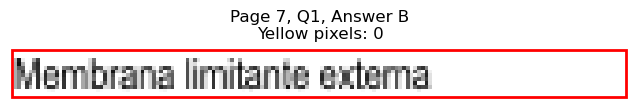

Page 7, Q1 - C: Detected box: x0=85.0, y0=135.5, x1=185.8, y1=148.2
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 514
Page 7, Q1, C: Yellow percentage: 0.0%


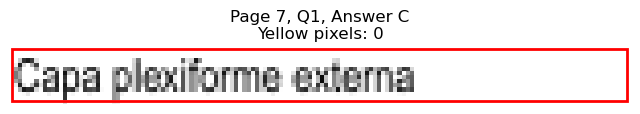

Page 7, Q1 - D: Detected box: x0=336.7, y0=110.3, x1=425.5, y1=123.0
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 570
Page 7, Q1, D: Yellow percentage: 0.0%


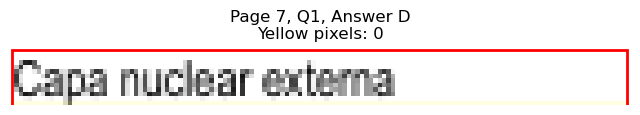

Page 7, Q1 - E: Detected box: x0=336.7, y0=122.9, x1=434.9, y1=135.6
Page 7, Q1, E: Yellow pixels: 1548
Page 7, Q1, E: Total non-white pixels: 2086
Page 7, Q1, E: Yellow percentage: 74.2%


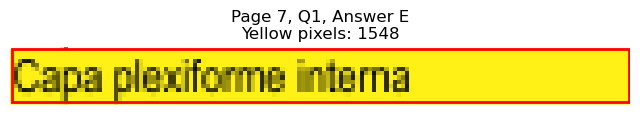


Page 7, Q1 - Selected Answer: E (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=198.6, x1=177.7, y1=211.3
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 474
Page 7, Q2, A: Yellow percentage: 0.0%


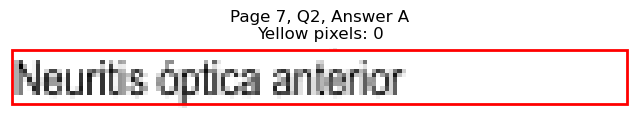

Page 7, Q2 - B: Detected box: x0=85.0, y0=211.3, x1=174.3, y1=224.0
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 482
Page 7, Q2, B: Yellow percentage: 0.0%


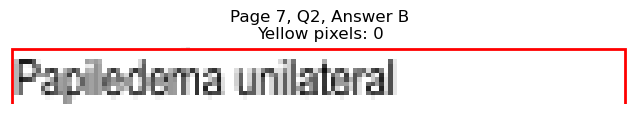

Page 7, Q2 - C: Detected box: x0=85.0, y0=223.9, x1=190.8, y1=236.6
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 548
Page 7, Q2, C: Yellow percentage: 0.0%


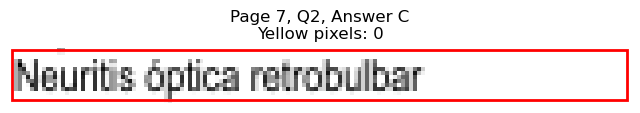

Page 7, Q2 - D: Detected box: x0=336.7, y0=198.6, x1=422.9, y1=211.3
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 406
Page 7, Q2, D: Yellow percentage: 0.0%


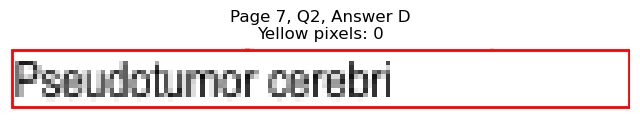

Page 7, Q2 - E: Detected box: x0=336.7, y0=211.3, x1=486.7, y1=224.0
Page 7, Q2, E: Yellow pixels: 1840
Page 7, Q2, E: Total non-white pixels: 2470
Page 7, Q2, E: Yellow percentage: 74.5%


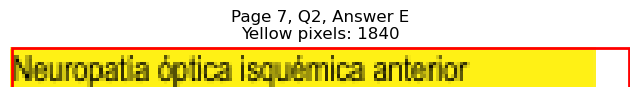


Page 7, Q2 - Selected Answer: E (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=261.7, x1=162.7, y1=274.4
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 380
Page 7, Q3, A: Yellow percentage: 0.0%


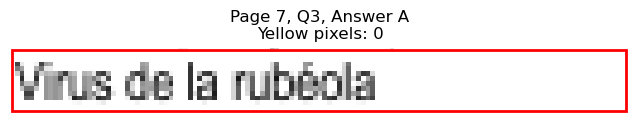

Page 7, Q3 - B: Detected box: x0=85.0, y0=274.5, x1=163.2, y1=287.1
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 392
Page 7, Q3, B: Yellow percentage: 0.0%


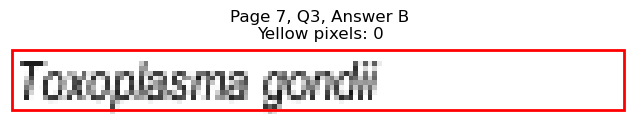

Page 7, Q3 - C: Detected box: x0=85.0, y0=287.1, x1=169.7, y1=299.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 432
Page 7, Q3, C: Yellow percentage: 0.0%


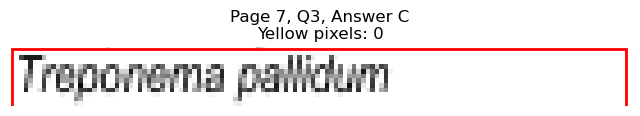

Page 7, Q3 - D: Detected box: x0=336.7, y0=261.7, x1=419.0, y1=274.4
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 427
Page 7, Q3, D: Yellow percentage: 0.0%


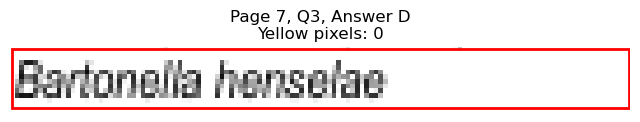

Page 7, Q3 - E: Detected box: x0=336.7, y0=274.5, x1=403.9, y1=287.1
Page 7, Q3, E: Yellow pixels: 1256
Page 7, Q3, E: Total non-white pixels: 1652
Page 7, Q3, E: Yellow percentage: 76.0%


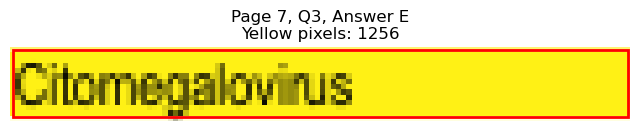


Page 7, Q3 - Selected Answer: E (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=324.9, x1=194.8, y1=337.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 571
Page 7, Q4, A: Yellow percentage: 0.0%


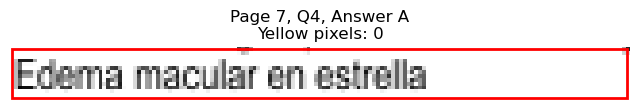

Page 7, Q4 - B: Detected box: x0=85.0, y0=337.5, x1=184.2, y1=350.1
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 505
Page 7, Q4, B: Yellow percentage: 0.0%


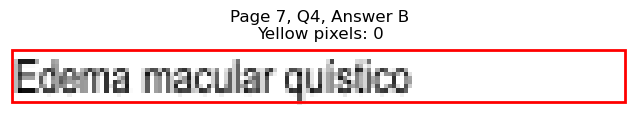

Page 7, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=193.8, y1=362.9
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 568
Page 7, Q4, C: Yellow percentage: 0.0%


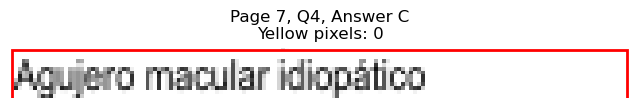

Page 7, Q4 - D: Detected box: x0=336.7, y0=324.9, x1=418.4, y1=337.5
Page 7, Q4, D: Yellow pixels: 1424
Page 7, Q4, D: Total non-white pixels: 1862
Page 7, Q4, D: Yellow percentage: 76.5%


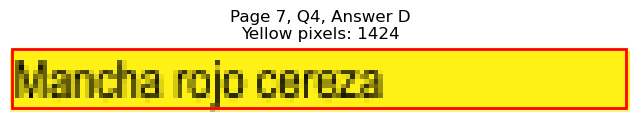

Page 7, Q4 - E: Detected box: x0=336.7, y0=337.5, x1=464.1, y1=350.1
Page 7, Q4, E: Yellow pixels: 178
Page 7, Q4, E: Total non-white pixels: 862
Page 7, Q4, E: Yellow percentage: 20.6%


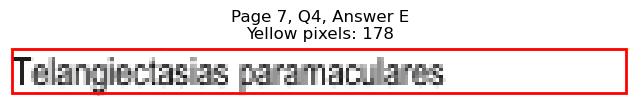


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=388.0, x1=180.3, y1=400.7
Page 7, Q5, A: Yellow pixels: 4
Page 7, Q5, A: Total non-white pixels: 650
Page 7, Q5, A: Yellow percentage: 0.6%


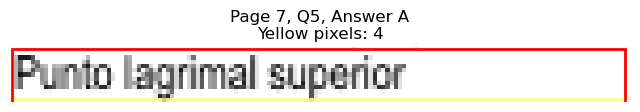

Page 7, Q5 - B: Detected box: x0=85.0, y0=400.6, x1=182.8, y1=413.3
Page 7, Q5, B: Yellow pixels: 1387
Page 7, Q5, B: Total non-white pixels: 2086
Page 7, Q5, B: Yellow percentage: 66.5%


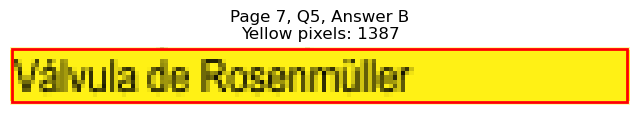

Page 7, Q5 - C: Detected box: x0=85.0, y0=413.3, x1=161.2, y1=426.0
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 500
Page 7, Q5, C: Yellow percentage: 0.0%


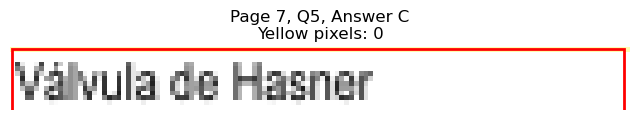

Page 7, Q5 - D: Detected box: x0=336.7, y0=388.0, x1=426.9, y1=400.7
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 453
Page 7, Q5, D: Yellow percentage: 0.0%


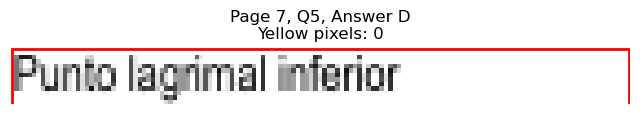

Page 7, Q5 - E: Detected box: x0=336.7, y0=400.6, x1=411.5, y1=413.3
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 369
Page 7, Q5, E: Yellow percentage: 0.0%


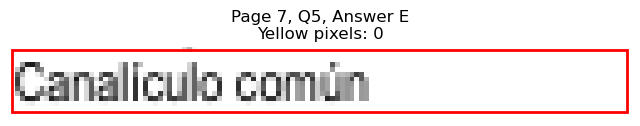


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=451.1, x1=153.7, y1=463.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 463
Page 7, Q6, A: Yellow percentage: 0.0%


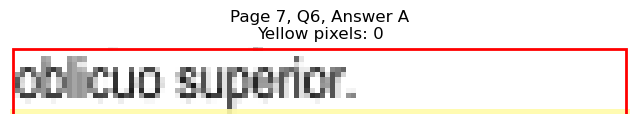

Page 7, Q6 - B: Detected box: x0=85.0, y0=463.7, x1=148.7, y1=476.4
Page 7, Q6, B: Yellow pixels: 1139
Page 7, Q6, B: Total non-white pixels: 1610
Page 7, Q6, B: Yellow percentage: 70.7%


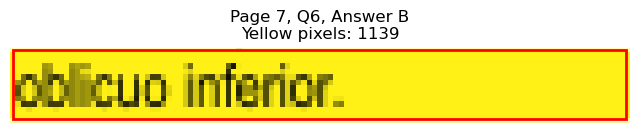

Page 7, Q6 - C: Detected box: x0=85.0, y0=476.3, x1=145.2, y1=489.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 404
Page 7, Q6, C: Yellow percentage: 0.0%


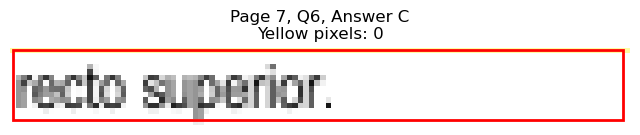

Page 7, Q6 - D: Detected box: x0=336.7, y0=451.1, x1=391.9, y1=463.8
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 255
Page 7, Q6, D: Yellow percentage: 0.0%


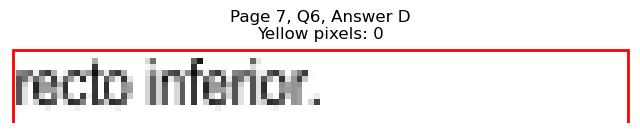

Page 7, Q6 - E: Detected box: x0=336.7, y0=463.7, x1=388.9, y1=476.4
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 242
Page 7, Q6, E: Yellow percentage: 0.0%


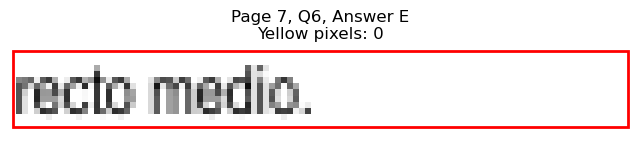


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=526.9, x1=173.8, y1=539.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 464
Page 7, Q7, A: Yellow percentage: 0.0%


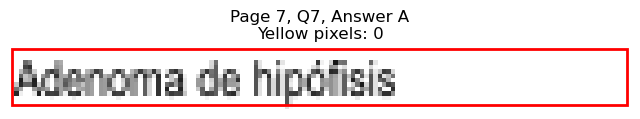

Page 7, Q7 - B: Detected box: x0=85.0, y0=539.5, x1=184.3, y1=552.1
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 500
Page 7, Q7, B: Yellow percentage: 0.0%


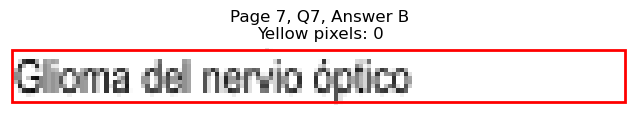

Page 7, Q7 - C: Detected box: x0=85.0, y0=552.2, x1=201.9, y1=564.8
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 594
Page 7, Q7, C: Yellow percentage: 0.0%


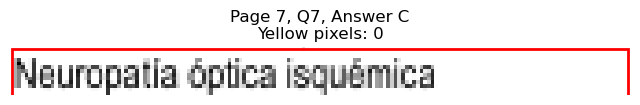

Page 7, Q7 - D: Detected box: x0=336.7, y0=526.9, x1=410.8, y1=539.5
Page 7, Q7, D: Yellow pixels: 1321
Page 7, Q7, D: Total non-white pixels: 1750
Page 7, Q7, D: Yellow percentage: 75.5%


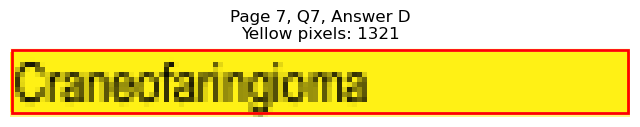

Page 7, Q7 - E: Detected box: x0=336.7, y0=539.5, x1=386.8, y1=552.1
Page 7, Q7, E: Yellow pixels: 100
Page 7, Q7, E: Total non-white pixels: 371
Page 7, Q7, E: Yellow percentage: 27.0%


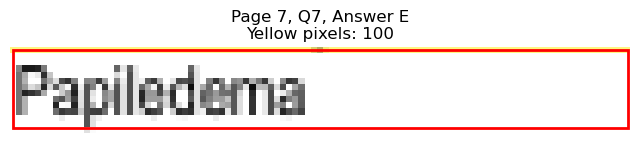


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=162.3, y1=627.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 424
Page 7, Q8, A: Yellow percentage: 0.0%


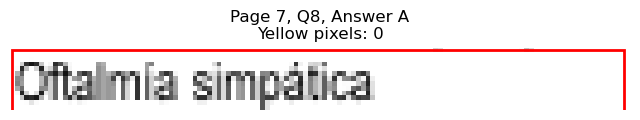

Page 7, Q8 - B: Detected box: x0=85.0, y0=627.9, x1=202.4, y1=640.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 617
Page 7, Q8, B: Yellow percentage: 0.0%


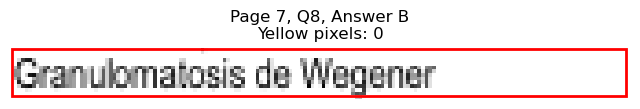

Page 7, Q8 - C: Detected box: x0=85.0, y0=640.5, x1=184.3, y1=653.2
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 528
Page 7, Q8, C: Yellow percentage: 0.0%


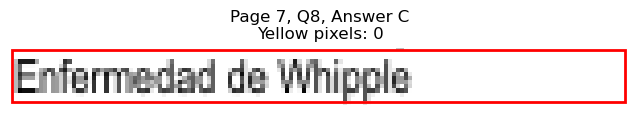

Page 7, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=515.3, y1=627.8
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 958
Page 7, Q8, D: Yellow percentage: 0.0%


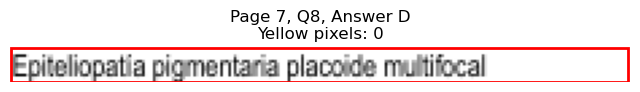

Page 7, Q8 - E: Detected box: x0=336.7, y0=627.9, x1=495.1, y1=640.6
Page 7, Q8, E: Yellow pixels: 1820
Page 7, Q8, E: Total non-white pixels: 2660
Page 7, Q8, E: Yellow percentage: 68.4%


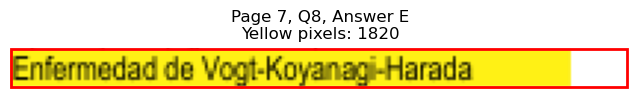


Page 7, Q8 - Selected Answer: E (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=678.3, x1=155.7, y1=691.0
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 352
Page 7, Q9, A: Yellow percentage: 0.0%


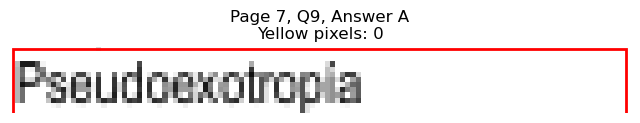

Page 7, Q9 - B: Detected box: x0=85.0, y0=691.1, x1=154.2, y1=703.7
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 379
Page 7, Q9, B: Yellow percentage: 0.0%


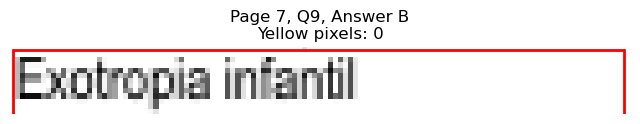

Page 7, Q9 - C: Detected box: x0=85.0, y0=703.7, x1=138.6, y1=716.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 240
Page 7, Q9, C: Yellow percentage: 0.0%


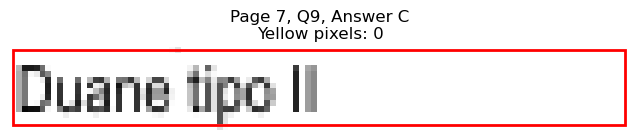

Page 7, Q9 - D: Detected box: x0=336.7, y0=678.3, x1=426.9, y1=691.0
Page 7, Q9, D: Yellow pixels: 1461
Page 7, Q9, D: Total non-white pixels: 1833
Page 7, Q9, D: Yellow percentage: 79.7%


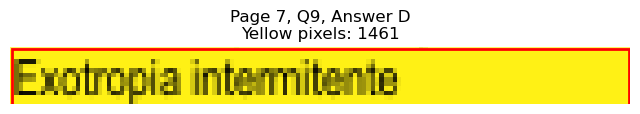

Page 7, Q9 - E: Detected box: x0=336.7, y0=691.1, x1=392.8, y1=703.7
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 378
Page 7, Q9, E: Yellow percentage: 0.0%


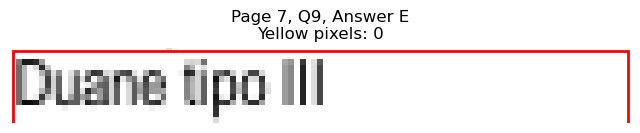


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=85.0, y0=741.4, x1=120.1, y1=754.1
Page 7, Q10, A: Yellow pixels: 87
Page 7, Q10, A: Total non-white pixels: 268
Page 7, Q10, A: Yellow percentage: 32.5%


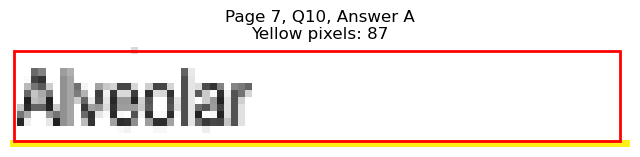

Page 7, Q10 - B: Detected box: x0=85.0, y0=754.0, x1=136.1, y1=766.7
Page 7, Q10, B: Yellow pixels: 1153
Page 7, Q10, B: Total non-white pixels: 1339
Page 7, Q10, B: Yellow percentage: 86.1%


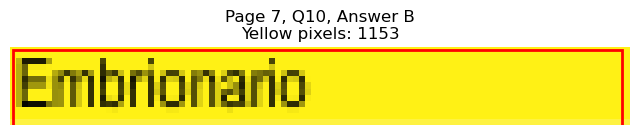

Page 7, Q10 - C: Detected box: x0=85.0, y0=766.8, x1=123.1, y1=779.4
Page 7, Q10, C: Yellow pixels: 90
Page 7, Q10, C: Total non-white pixels: 286
Page 7, Q10, C: Yellow percentage: 31.5%


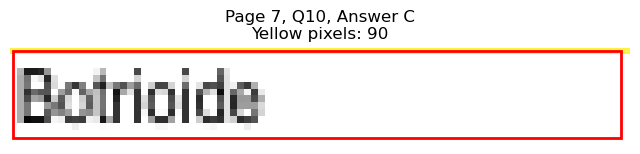

Page 7, Q10 - D: Detected box: x0=336.7, y0=741.4, x1=380.3, y1=754.1
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 210
Page 7, Q10, D: Yellow percentage: 0.0%


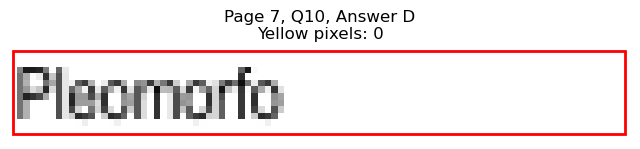

Page 7, Q10 - E: Detected box: x0=336.7, y0=754.0, x1=381.8, y1=766.7
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 227
Page 7, Q10, E: Yellow percentage: 0.0%


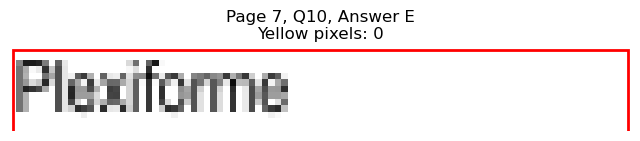


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=97.7, x1=216.5, y1=110.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 656
Page 8, Q1, A: Yellow percentage: 0.0%


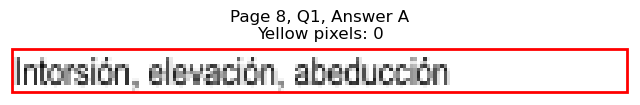

Page 8, Q1 - B: Detected box: x0=85.0, y0=110.3, x1=209.4, y1=123.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 786
Page 8, Q1, B: Yellow percentage: 0.0%


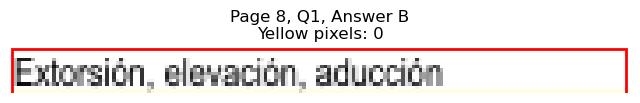

Page 8, Q1 - C: Detected box: x0=85.0, y0=122.9, x1=211.4, y1=135.6
Page 8, Q1, C: Yellow pixels: 1856
Page 8, Q1, C: Total non-white pixels: 2492
Page 8, Q1, C: Yellow percentage: 74.5%


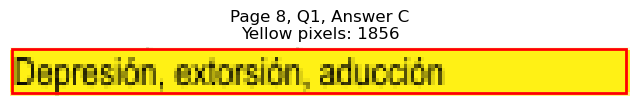

Page 8, Q1 - D: Detected box: x0=336.7, y0=97.7, x1=460.5, y1=110.4
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 644
Page 8, Q1, D: Yellow percentage: 0.0%


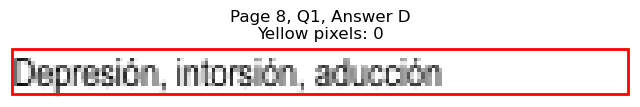

Page 8, Q1 - E: Detected box: x0=336.7, y0=110.3, x1=472.5, y1=123.0
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 689
Page 8, Q1, E: Yellow percentage: 0.0%


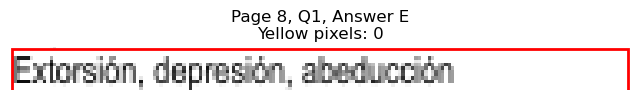


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=160.8, x1=111.6, y1=173.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 144
Page 8, Q2, A: Yellow percentage: 0.0%


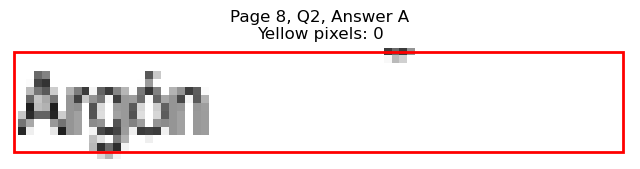

Page 8, Q2 - B: Detected box: x0=85.0, y0=173.4, x1=120.6, y1=186.1
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 172
Page 8, Q2, B: Yellow percentage: 0.0%


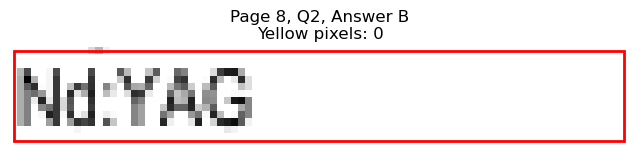

Page 8, Q2 - C: Detected box: x0=85.0, y0=186.0, x1=111.0, y1=198.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 122
Page 8, Q2, C: Yellow percentage: 0.0%


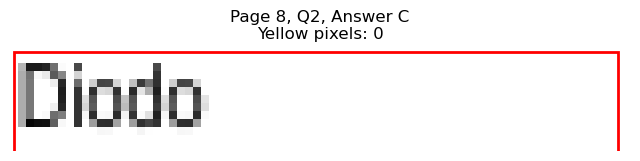

Page 8, Q2 - D: Detected box: x0=336.7, y0=160.8, x1=372.3, y1=173.5
Page 8, Q2, D: Yellow pixels: 991
Page 8, Q2, D: Total non-white pixels: 1218
Page 8, Q2, D: Yellow percentage: 81.4%


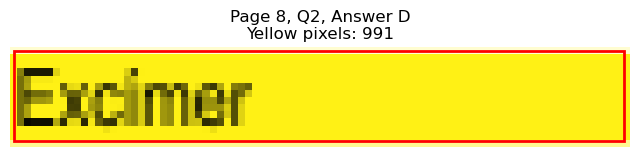

Page 8, Q2 - E: Detected box: x0=336.7, y0=173.4, x1=367.7, y1=186.1
Page 8, Q2, E: Yellow pixels: 82
Page 8, Q2, E: Total non-white pixels: 249
Page 8, Q2, E: Yellow percentage: 32.9%


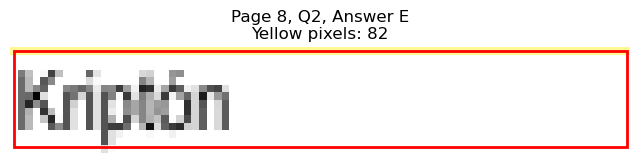


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=223.9, x1=128.7, y1=236.6
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 215
Page 8, Q3, A: Yellow percentage: 0.0%


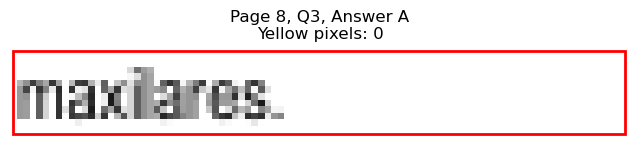

Page 8, Q3 - B: Detected box: x0=85.0, y0=236.5, x1=140.7, y1=249.2
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 299
Page 8, Q3, B: Yellow percentage: 0.0%


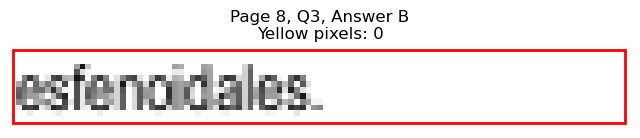

Page 8, Q3 - C: Detected box: x0=85.0, y0=249.1, x1=124.6, y1=261.8
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 193
Page 8, Q3, C: Yellow percentage: 0.0%


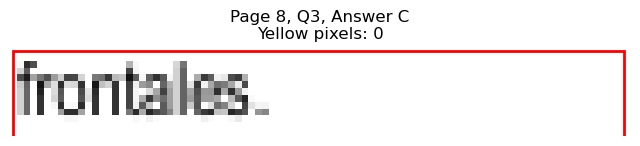

Page 8, Q3 - D: Detected box: x0=336.7, y0=223.9, x1=385.3, y1=236.6
Page 8, Q3, D: Yellow pixels: 1116
Page 8, Q3, D: Total non-white pixels: 1400
Page 8, Q3, D: Yellow percentage: 79.7%


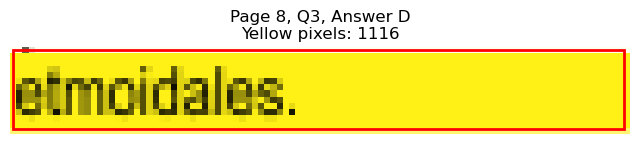

Page 8, Q3 - E: Detected box: x0=336.7, y0=236.5, x1=373.7, y1=249.2
Page 8, Q3, E: Yellow pixels: 88
Page 8, Q3, E: Total non-white pixels: 268
Page 8, Q3, E: Yellow percentage: 32.8%


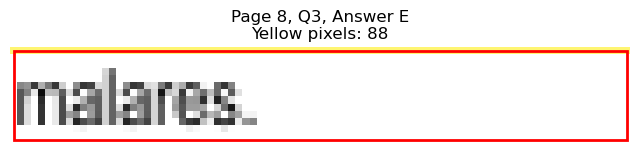


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=312.3, x1=240.0, y1=324.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 731
Page 8, Q4, A: Yellow percentage: 0.0%


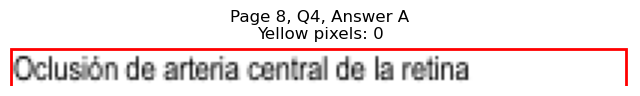

Page 8, Q4 - B: Detected box: x0=85.0, y0=324.9, x1=219.9, y1=337.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 688
Page 8, Q4, B: Yellow percentage: 0.0%


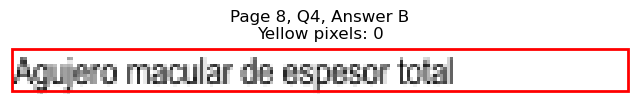

Page 8, Q4 - C: Detected box: x0=85.0, y0=337.5, x1=218.0, y1=350.1
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 694
Page 8, Q4, C: Yellow percentage: 0.0%


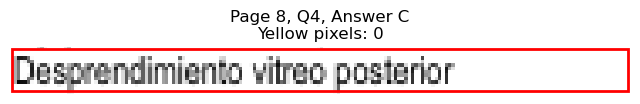

Page 8, Q4 - D: Detected box: x0=336.7, y0=312.3, x1=443.5, y1=324.9
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 730
Page 8, Q4, D: Yellow percentage: 0.0%


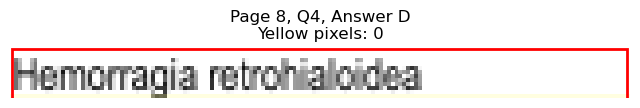

Page 8, Q4 - E: Detected box: x0=336.7, y0=324.9, x1=486.2, y1=337.5
Page 8, Q4, E: Yellow pixels: 1881
Page 8, Q4, E: Total non-white pixels: 2660
Page 8, Q4, E: Yellow percentage: 70.7%


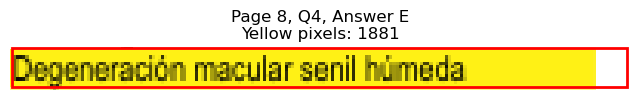


Page 8, Q4 - Selected Answer: E (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=375.4, x1=123.1, y1=388.1
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 202
Page 8, Q5, A: Yellow percentage: 0.0%


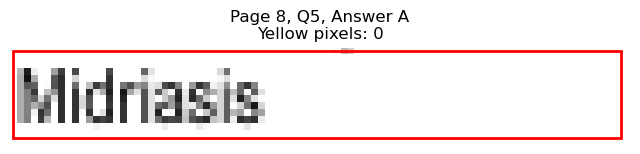

Page 8, Q5 - B: Detected box: x0=85.0, y0=388.0, x1=136.7, y1=400.7
Page 8, Q5, B: Yellow pixels: 2
Page 8, Q5, B: Total non-white pixels: 373
Page 8, Q5, B: Yellow percentage: 0.5%


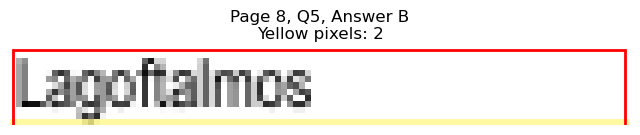

Page 8, Q5 - C: Detected box: x0=85.0, y0=400.6, x1=112.1, y1=413.3
Page 8, Q5, C: Yellow pixels: 836
Page 8, Q5, C: Total non-white pixels: 1106
Page 8, Q5, C: Yellow percentage: 75.6%


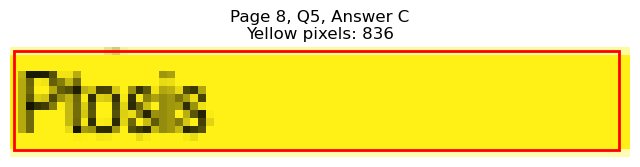

Page 8, Q5 - D: Detected box: x0=336.7, y0=375.4, x1=376.7, y1=388.1
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 214
Page 8, Q5, D: Yellow percentage: 0.0%


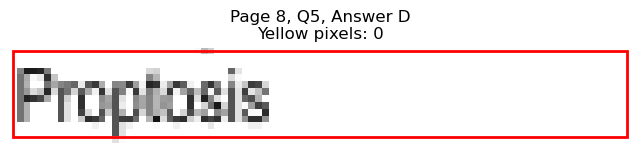

Page 8, Q5 - E: Detected box: x0=336.7, y0=388.0, x1=364.7, y1=400.7
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 155
Page 8, Q5, E: Yellow percentage: 0.0%


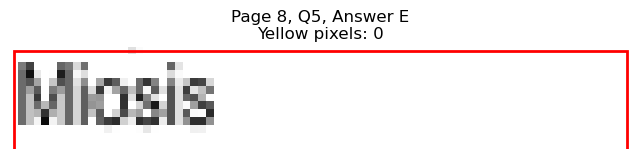


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=451.1, x1=181.2, y1=463.8
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 647
Page 8, Q6, A: Yellow percentage: 0.0%


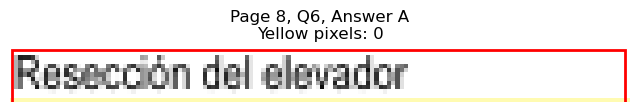

Page 8, Q6 - B: Detected box: x0=85.0, y0=463.7, x1=162.3, y1=476.4
Page 8, Q6, B: Yellow pixels: 1238
Page 8, Q6, B: Total non-white pixels: 1806
Page 8, Q6, B: Yellow percentage: 68.5%


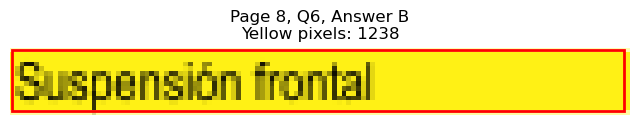

Page 8, Q6 - C: Detected box: x0=85.0, y0=476.3, x1=144.1, y1=489.0
Page 8, Q6, C: Yellow pixels: 1
Page 8, Q6, C: Total non-white pixels: 402
Page 8, Q6, C: Yellow percentage: 0.2%


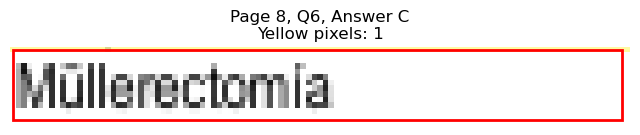

Page 8, Q6 - D: Detected box: x0=336.7, y0=451.1, x1=464.1, y1=463.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 627
Page 8, Q6, D: Yellow percentage: 0.0%


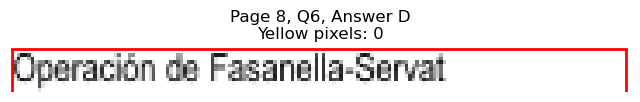

Page 8, Q6 - E: Detected box: x0=336.7, y0=463.7, x1=443.0, y1=476.4
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 534
Page 8, Q6, E: Yellow percentage: 0.0%


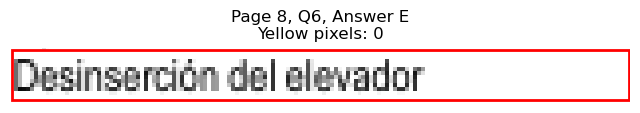


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=526.9, x1=163.2, y1=539.5
Page 8, Q7, A: Yellow pixels: 1370
Page 8, Q7, A: Total non-white pixels: 1820
Page 8, Q7, A: Yellow percentage: 75.3%


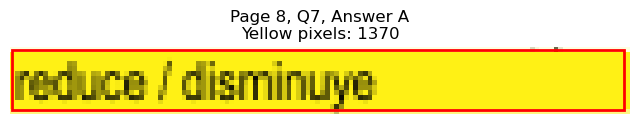

Page 8, Q7 - B: Detected box: x0=85.0, y0=539.5, x1=157.7, y1=552.1
Page 8, Q7, B: Yellow pixels: 123
Page 8, Q7, B: Total non-white pixels: 482
Page 8, Q7, B: Yellow percentage: 25.5%


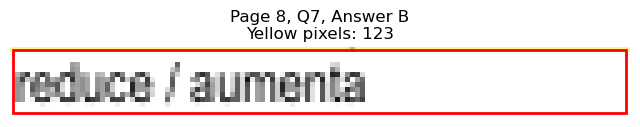

Page 8, Q7 - C: Detected box: x0=85.0, y0=552.2, x1=174.7, y1=564.8
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 436
Page 8, Q7, C: Yellow percentage: 0.0%


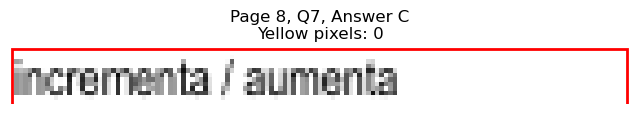

Page 8, Q7 - D: Detected box: x0=336.7, y0=526.9, x1=431.9, y1=539.5
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 492
Page 8, Q7, D: Yellow percentage: 0.0%


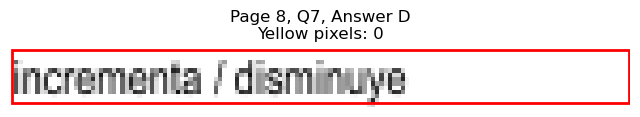

Page 8, Q7 - E: Detected box: x0=336.7, y0=539.5, x1=428.5, y1=552.1
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 450
Page 8, Q7, E: Yellow percentage: 0.0%


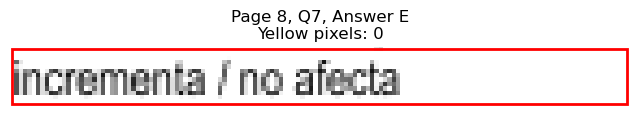


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=590.0, x1=129.6, y1=602.6
Page 8, Q8, A: Yellow pixels: 1045
Page 8, Q8, A: Total non-white pixels: 1344
Page 8, Q8, A: Yellow percentage: 77.8%


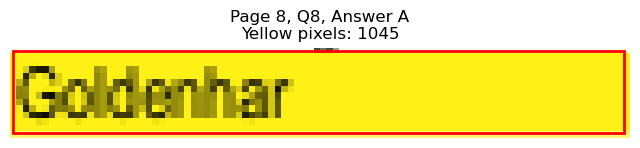

Page 8, Q8 - B: Detected box: x0=85.0, y0=602.6, x1=137.7, y1=615.2
Page 8, Q8, B: Yellow pixels: 104
Page 8, Q8, B: Total non-white pixels: 373
Page 8, Q8, B: Yellow percentage: 27.9%


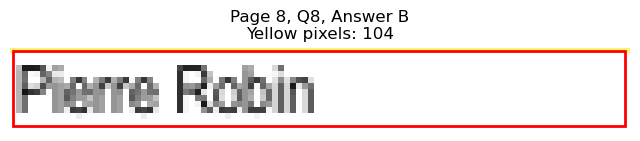

Page 8, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=128.1, y1=627.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 208
Page 8, Q8, C: Yellow percentage: 0.0%


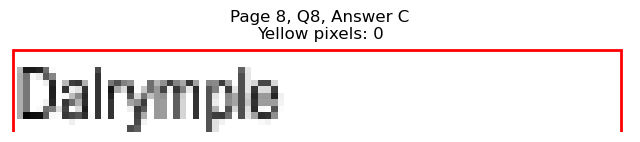

Page 8, Q8 - D: Detected box: x0=336.7, y0=590.0, x1=368.7, y1=602.6
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 183
Page 8, Q8, D: Yellow percentage: 0.0%


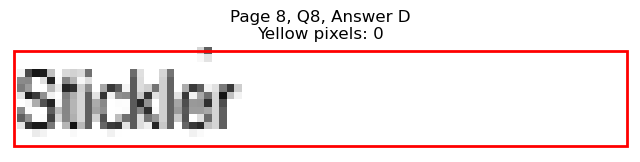

Page 8, Q8 - E: Detected box: x0=336.7, y0=602.6, x1=370.7, y1=615.2
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 184
Page 8, Q8, E: Yellow percentage: 0.0%


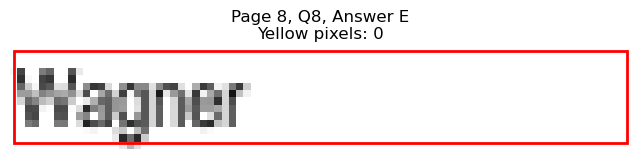


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=85.0, y0=653.1, x1=145.1, y1=665.8
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 302
Page 8, Q9, A: Yellow percentage: 0.0%


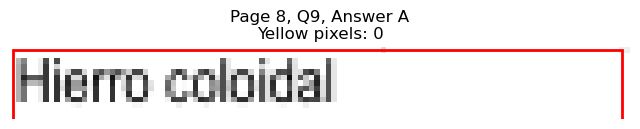

Page 8, Q9 - B: Detected box: x0=85.0, y0=665.7, x1=105.5, y1=678.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 99
Page 8, Q9, B: Yellow percentage: 0.0%


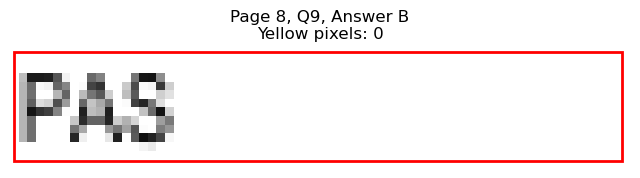

Page 8, Q9 - C: Detected box: x0=85.0, y0=678.3, x1=131.2, y1=691.0
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 207
Page 8, Q9, C: Yellow percentage: 0.0%


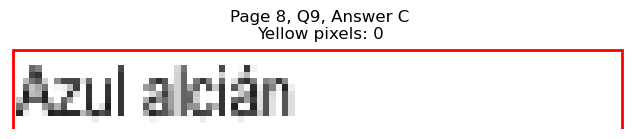

Page 8, Q9 - D: Detected box: x0=336.7, y0=653.1, x1=392.3, y1=665.8
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 398
Page 8, Q9, D: Yellow percentage: 0.0%


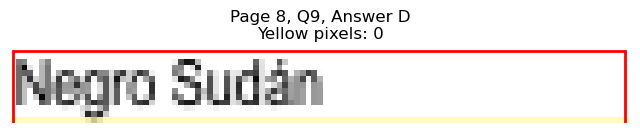

Page 8, Q9 - E: Detected box: x0=336.7, y0=665.7, x1=427.9, y1=678.4
Page 8, Q9, E: Yellow pixels: 1368
Page 8, Q9, E: Total non-white pixels: 1988
Page 8, Q9, E: Yellow percentage: 68.8%


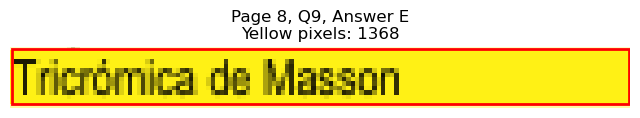


Page 8, Q9 - Selected Answer: E (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=85.0, y0=728.9, x1=256.6, y1=741.5
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 854
Page 8, Q10, A: Yellow percentage: 0.0%


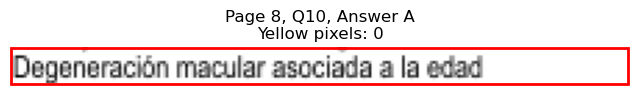

Page 8, Q10 - B: Detected box: x0=85.0, y0=741.4, x1=155.2, y1=754.1
Page 8, Q10, B: Yellow pixels: 122
Page 8, Q10, B: Total non-white pixels: 486
Page 8, Q10, B: Yellow percentage: 25.1%


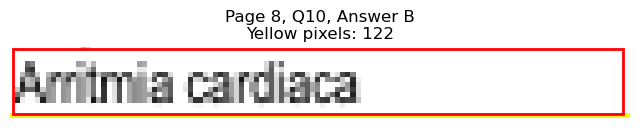

Page 8, Q10 - C: Detected box: x0=85.0, y0=754.0, x1=209.3, y1=766.7
Page 8, Q10, C: Yellow pixels: 1811
Page 8, Q10, C: Total non-white pixels: 2288
Page 8, Q10, C: Yellow percentage: 79.2%


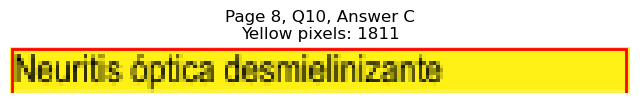

Page 8, Q10 - D: Detected box: x0=336.7, y0=728.9, x1=483.1, y1=741.5
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 698
Page 8, Q10, D: Yellow percentage: 0.0%


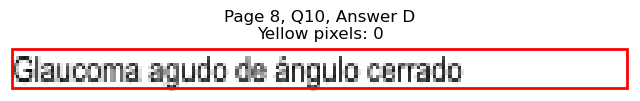

Page 8, Q10 - E: Detected box: x0=336.7, y0=741.4, x1=463.0, y1=754.1
Page 8, Q10, E: Yellow pixels: 0
Page 8, Q10, E: Total non-white pixels: 664
Page 8, Q10, E: Yellow percentage: 0.0%


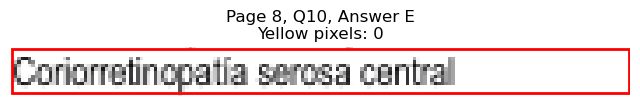


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=135.5, x1=231.4, y1=148.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 748
Page 9, Q1, A: Yellow percentage: 0.0%


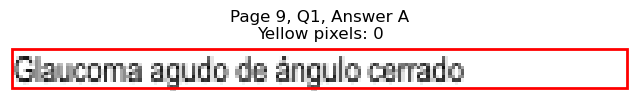

Page 9, Q1 - B: Detected box: x0=85.0, y0=148.2, x1=263.6, y1=160.9
Page 9, Q1, B: Yellow pixels: 1800
Page 9, Q1, B: Total non-white pixels: 2483
Page 9, Q1, B: Yellow percentage: 72.5%


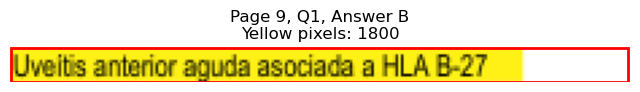

Page 9, Q1 - C: Detected box: x0=85.0, y0=160.8, x1=233.0, y1=173.5
Page 9, Q1, C: Yellow pixels: 186
Page 9, Q1, C: Total non-white pixels: 974
Page 9, Q1, C: Yellow percentage: 19.1%


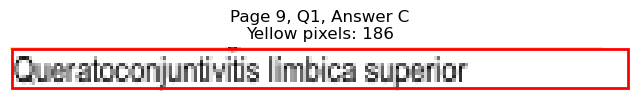

Page 9, Q1 - D: Detected box: x0=336.7, y0=135.5, x1=450.5, y1=148.2
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 568
Page 9, Q1, D: Yellow percentage: 0.0%


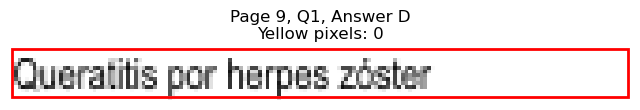

Page 9, Q1 - E: Detected box: x0=336.7, y0=148.2, x1=486.7, y1=160.9
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 769
Page 9, Q1, E: Yellow percentage: 0.0%


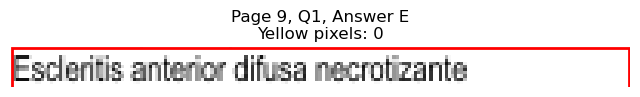


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=198.6, x1=129.1, y1=211.3
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 220
Page 9, Q2, A: Yellow percentage: 0.0%


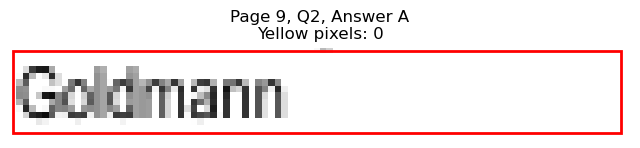

Page 9, Q2 - B: Detected box: x0=85.0, y0=211.3, x1=109.1, y1=224.0
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 118
Page 9, Q2, B: Yellow percentage: 0.0%


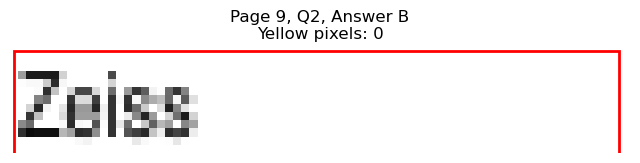

Page 9, Q2 - C: Detected box: x0=85.0, y0=223.9, x1=125.1, y1=236.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 192
Page 9, Q2, C: Yellow percentage: 0.0%


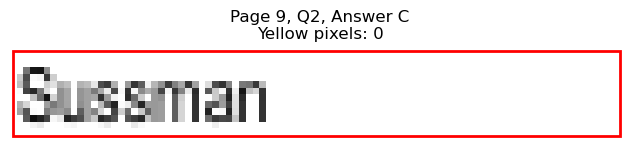

Page 9, Q2 - D: Detected box: x0=336.7, y0=198.6, x1=367.7, y1=211.3
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 151
Page 9, Q2, D: Yellow percentage: 0.0%


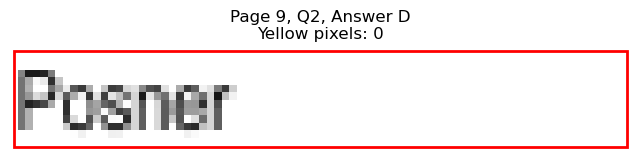

Page 9, Q2 - E: Detected box: x0=336.7, y0=211.3, x1=370.3, y1=224.0
Page 9, Q2, E: Yellow pixels: 963
Page 9, Q2, E: Total non-white pixels: 1105
Page 9, Q2, E: Yellow percentage: 87.1%


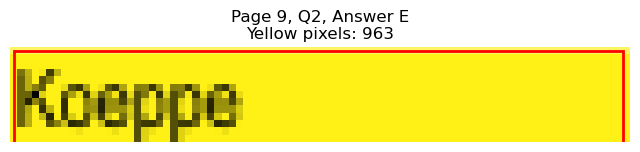


Page 9, Q2 - Selected Answer: E (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=261.7, x1=165.7, y1=274.4
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 407
Page 9, Q3, A: Yellow percentage: 0.0%


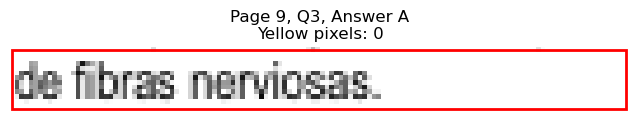

Page 9, Q3 - B: Detected box: x0=85.0, y0=274.5, x1=152.2, y1=287.1
Page 9, Q3, B: Yellow pixels: 119
Page 9, Q3, B: Total non-white pixels: 438
Page 9, Q3, B: Yellow percentage: 27.2%


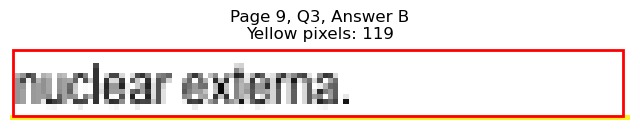

Page 9, Q3 - C: Detected box: x0=85.0, y0=287.1, x1=164.2, y1=299.7
Page 9, Q3, C: Yellow pixels: 1369
Page 9, Q3, C: Total non-white pixels: 1703
Page 9, Q3, C: Yellow percentage: 80.4%


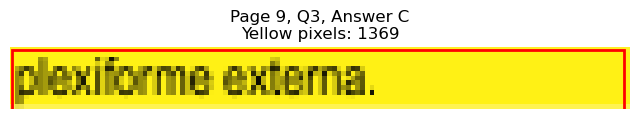

Page 9, Q3 - D: Detected box: x0=336.7, y0=261.7, x1=401.3, y1=274.4
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 305
Page 9, Q3, D: Yellow percentage: 0.0%


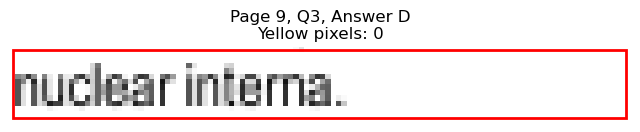

Page 9, Q3 - E: Detected box: x0=336.7, y0=274.5, x1=413.3, y1=287.1
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 373
Page 9, Q3, E: Yellow percentage: 0.0%


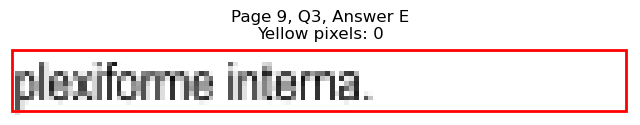


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=337.5, x1=113.1, y1=350.1
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 134
Page 9, Q4, A: Yellow percentage: 0.0%


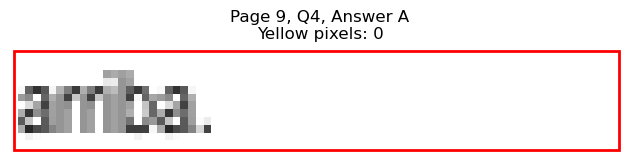

Page 9, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=112.1, y1=362.9
Page 9, Q4, B: Yellow pixels: 911
Page 9, Q4, B: Total non-white pixels: 1027
Page 9, Q4, B: Yellow percentage: 88.7%


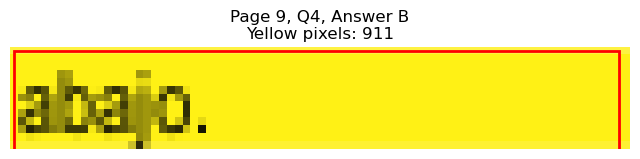

Page 9, Q4 - C: Detected box: x0=85.0, y0=362.8, x1=132.1, y1=375.5
Page 9, Q4, C: Yellow pixels: 96
Page 9, Q4, C: Total non-white pixels: 323
Page 9, Q4, C: Yellow percentage: 29.7%


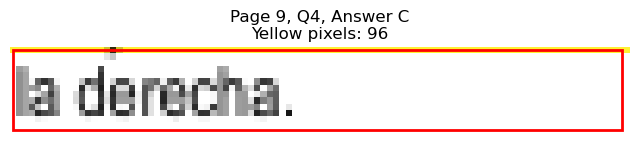

Page 9, Q4 - D: Detected box: x0=336.7, y0=337.5, x1=387.8, y1=350.1
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 259
Page 9, Q4, D: Yellow percentage: 0.0%


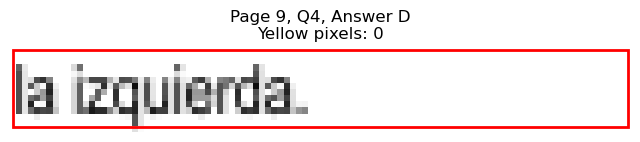

Page 9, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=376.3, y1=362.9
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 175
Page 9, Q4, E: Yellow percentage: 0.0%


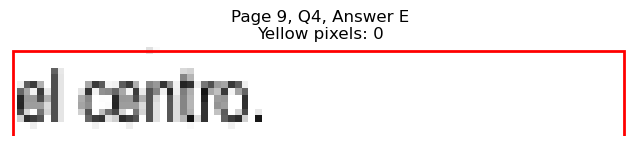


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=400.6, x1=153.1, y1=413.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 341
Page 9, Q5, A: Yellow percentage: 0.0%


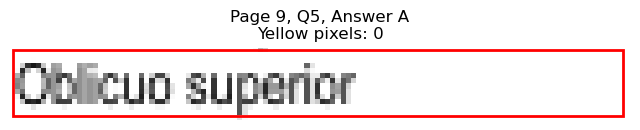

Page 9, Q5 - B: Detected box: x0=85.0, y0=413.3, x1=140.2, y1=426.0
Page 9, Q5, B: Yellow pixels: 1185
Page 9, Q5, B: Total non-white pixels: 1391
Page 9, Q5, B: Yellow percentage: 85.2%


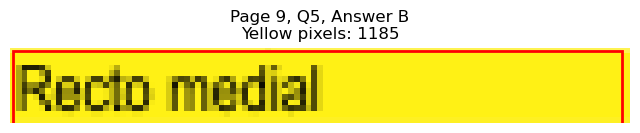

Page 9, Q5 - C: Detected box: x0=85.0, y0=425.9, x1=138.1, y1=438.6
Page 9, Q5, C: Yellow pixels: 105
Page 9, Q5, C: Total non-white pixels: 387
Page 9, Q5, C: Yellow percentage: 27.1%


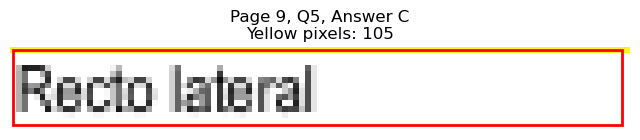

Page 9, Q5 - D: Detected box: x0=336.7, y0=400.6, x1=397.9, y1=413.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 303
Page 9, Q5, D: Yellow percentage: 0.0%


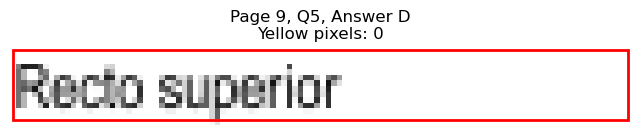

Page 9, Q5 - E: Detected box: x0=336.7, y0=413.3, x1=392.8, y1=426.0
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 285
Page 9, Q5, E: Yellow percentage: 0.0%


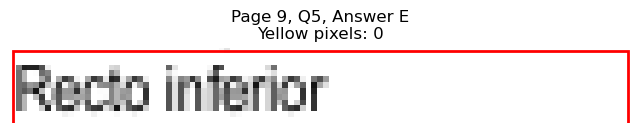


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=476.3, x1=161.2, y1=489.0
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 407
Page 9, Q6, A: Yellow percentage: 0.0%


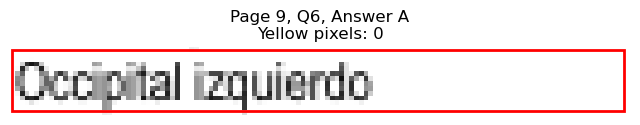

Page 9, Q6 - B: Detected box: x0=85.0, y0=489.1, x1=157.2, y1=501.7
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 387
Page 9, Q6, B: Yellow percentage: 0.0%


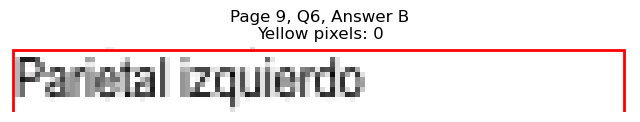

Page 9, Q6 - C: Detected box: x0=85.0, y0=501.7, x1=160.7, y1=514.3
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 379
Page 9, Q6, C: Yellow percentage: 0.0%


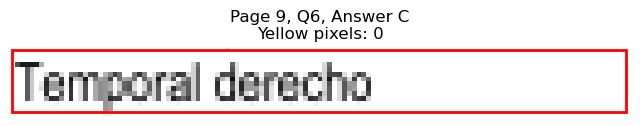

Page 9, Q6 - D: Detected box: x0=336.7, y0=476.3, x1=416.3, y1=489.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 410
Page 9, Q6, D: Yellow percentage: 0.0%


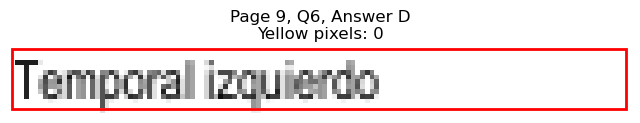

Page 9, Q6 - E: Detected box: x0=336.7, y0=489.1, x1=404.8, y1=501.7
Page 9, Q6, E: Yellow pixels: 1267
Page 9, Q6, E: Total non-white pixels: 1547
Page 9, Q6, E: Yellow percentage: 81.9%


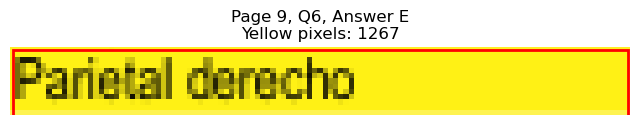


Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=552.2, x1=146.2, y1=564.8
Page 9, Q7, A: Yellow pixels: 1228
Page 9, Q7, A: Total non-white pixels: 1469
Page 9, Q7, A: Yellow percentage: 83.6%


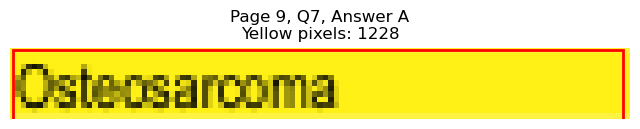

Page 9, Q7 - B: Detected box: x0=85.0, y0=564.8, x1=168.7, y1=577.4
Page 9, Q7, B: Yellow pixels: 135
Page 9, Q7, B: Total non-white pixels: 544
Page 9, Q7, B: Yellow percentage: 24.8%


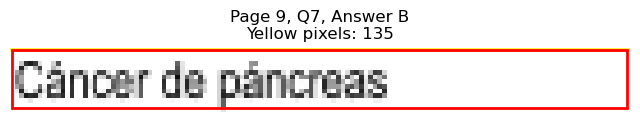

Page 9, Q7 - C: Detected box: x0=85.0, y0=577.4, x1=189.3, y1=590.0
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 551
Page 9, Q7, C: Yellow percentage: 0.0%


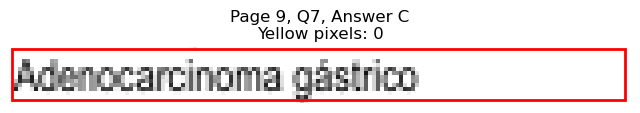

Page 9, Q7 - D: Detected box: x0=336.7, y0=552.2, x1=404.8, y1=564.8
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 317
Page 9, Q7, D: Yellow percentage: 0.0%


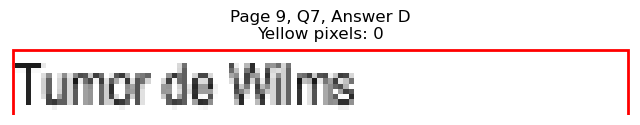

Page 9, Q7 - E: Detected box: x0=336.7, y0=564.8, x1=410.8, y1=577.4
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 393
Page 9, Q7, E: Yellow percentage: 0.0%


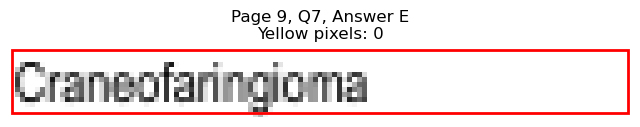


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=144.6, y1=627.8
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 292
Page 9, Q8, A: Yellow percentage: 0.0%


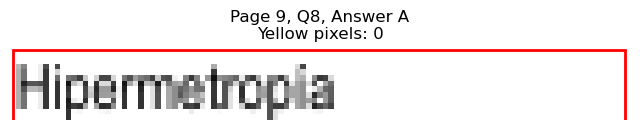

Page 9, Q8 - B: Detected box: x0=85.0, y0=627.9, x1=165.7, y1=640.6
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 429
Page 9, Q8, B: Yellow percentage: 0.0%


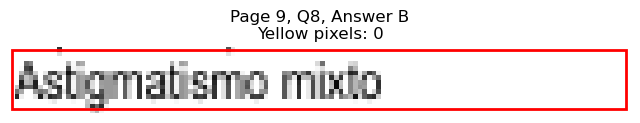

Page 9, Q8 - C: Detected box: x0=85.0, y0=640.5, x1=190.8, y1=653.2
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 553
Page 9, Q8, C: Yellow percentage: 0.0%


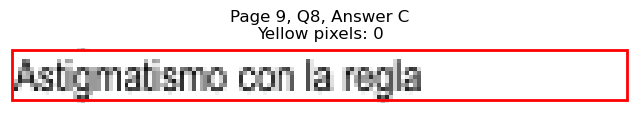

Page 9, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=366.3, y1=627.8
Page 9, Q8, D: Yellow pixels: 922
Page 9, Q8, D: Total non-white pixels: 1053
Page 9, Q8, D: Yellow percentage: 87.6%


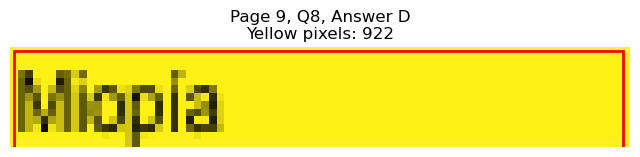

Page 9, Q8 - E: Detected box: x0=336.7, y0=627.9, x1=453.1, y1=640.6
Page 9, Q8, E: Yellow pixels: 166
Page 9, Q8, E: Total non-white pixels: 741
Page 9, Q8, E: Yellow percentage: 22.4%


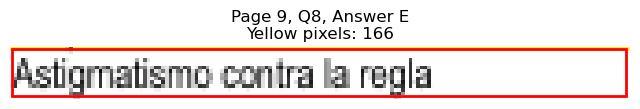


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=678.3, x1=124.6, y1=691.0
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 219
Page 9, Q9, A: Yellow percentage: 0.0%


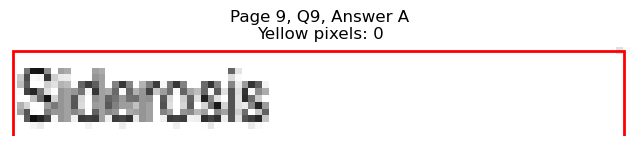

Page 9, Q9 - B: Detected box: x0=85.0, y0=691.1, x1=120.1, y1=703.7
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 196
Page 9, Q9, B: Yellow percentage: 0.0%


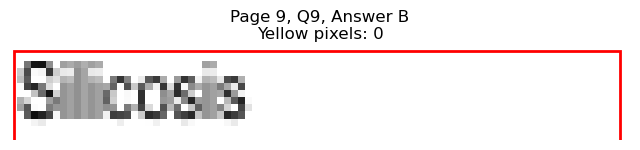

Page 9, Q9 - C: Detected box: x0=85.0, y0=703.7, x1=142.7, y1=716.3
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 312
Page 9, Q9, C: Yellow percentage: 0.0%


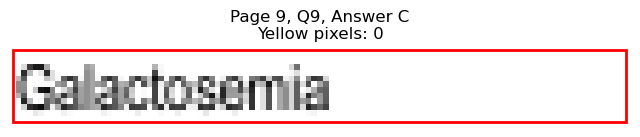

Page 9, Q9 - D: Detected box: x0=336.7, y0=678.3, x1=398.8, y1=691.0
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 335
Page 9, Q9, D: Yellow percentage: 0.0%


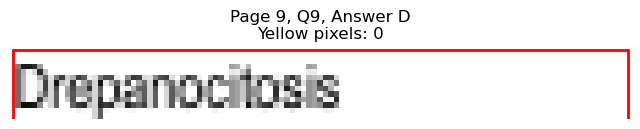

Page 9, Q9 - E: Detected box: x0=336.7, y0=691.1, x1=370.8, y1=703.7
Page 9, Q9, E: Yellow pixels: 960
Page 9, Q9, E: Total non-white pixels: 1105
Page 9, Q9, E: Yellow percentage: 86.9%


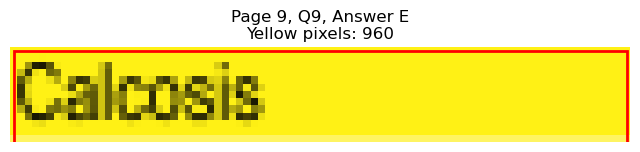


Page 9, Q9 - Selected Answer: E (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=110.3, x1=128.1, y1=123.0
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 286
Page 10, Q1, A: Yellow percentage: 0.0%


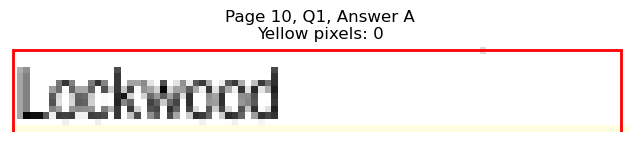

Page 10, Q1 - B: Detected box: x0=85.0, y0=122.9, x1=119.5, y1=135.6
Page 10, Q1, B: Yellow pixels: 962
Page 10, Q1, B: Total non-white pixels: 1204
Page 10, Q1, B: Yellow percentage: 79.9%


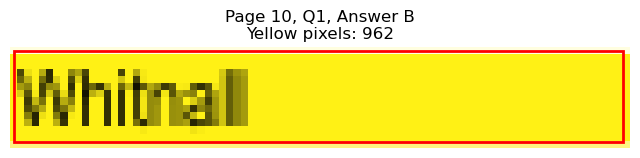

Page 10, Q1 - C: Detected box: x0=85.0, y0=135.5, x1=138.6, y1=148.2
Page 10, Q1, C: Yellow pixels: 105
Page 10, Q1, C: Total non-white pixels: 384
Page 10, Q1, C: Yellow percentage: 27.3%


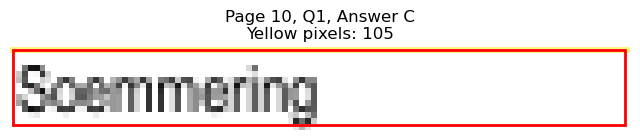

Page 10, Q1 - D: Detected box: x0=336.7, y0=110.3, x1=369.8, y1=123.0
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 171
Page 10, Q1, D: Yellow percentage: 0.0%


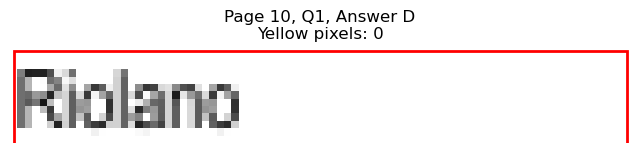

Page 10, Q1 - E: Detected box: x0=336.7, y0=122.9, x1=379.7, y1=135.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 233
Page 10, Q1, E: Yellow percentage: 0.0%


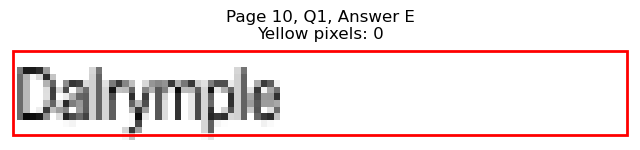


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=173.4, x1=167.2, y1=186.1
Page 10, Q2, A: Yellow pixels: 1401
Page 10, Q2, A: Total non-white pixels: 1876
Page 10, Q2, A: Yellow percentage: 74.7%


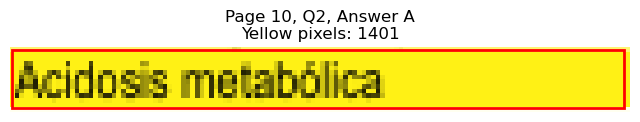

Page 10, Q2 - B: Detected box: x0=85.0, y0=186.0, x1=150.1, y1=198.7
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 431
Page 10, Q2, B: Yellow percentage: 0.0%


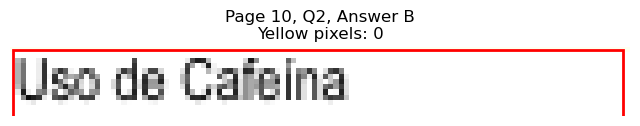

Page 10, Q2 - C: Detected box: x0=85.0, y0=198.6, x1=168.3, y1=211.3
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 426
Page 10, Q2, C: Yellow percentage: 0.0%


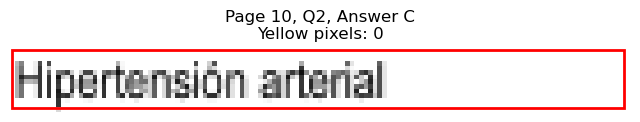

Page 10, Q2 - D: Detected box: x0=336.7, y0=173.4, x1=385.7, y1=186.1
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 260
Page 10, Q2, D: Yellow percentage: 0.0%


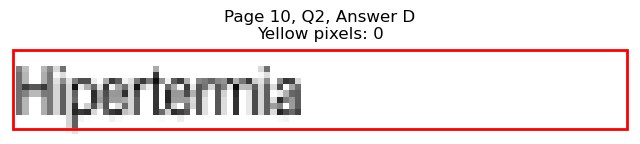

Page 10, Q2 - E: Detected box: x0=336.7, y0=186.0, x1=396.3, y1=198.7
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 325
Page 10, Q2, E: Yellow percentage: 0.0%


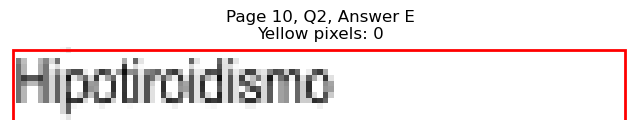


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=236.5, x1=160.7, y1=249.2
Page 10, Q3, A: Yellow pixels: 1327
Page 10, Q3, A: Total non-white pixels: 1778
Page 10, Q3, A: Yellow percentage: 74.6%


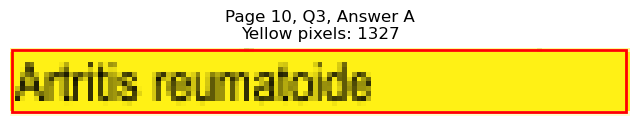

Page 10, Q3 - B: Detected box: x0=85.0, y0=249.1, x1=198.3, y1=261.8
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 731
Page 10, Q3, B: Yellow percentage: 0.0%


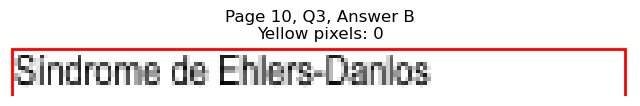

Page 10, Q3 - C: Detected box: x0=85.0, y0=261.7, x1=162.3, y1=274.4
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 407
Page 10, Q3, C: Yellow percentage: 0.0%


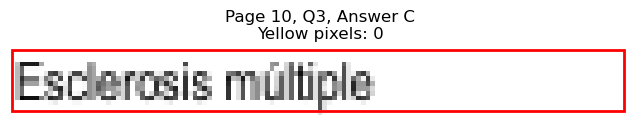

Page 10, Q3 - D: Detected box: x0=336.7, y0=236.5, x1=451.0, y1=249.2
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 614
Page 10, Q3, D: Yellow percentage: 0.0%


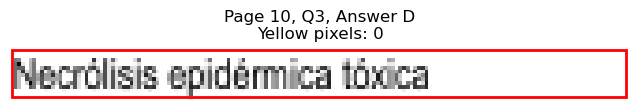

Page 10, Q3 - E: Detected box: x0=336.7, y0=249.1, x1=371.2, y1=261.8
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 172
Page 10, Q3, E: Yellow percentage: 0.0%


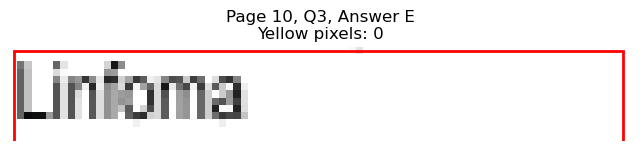


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=299.7, x1=117.1, y1=312.3
Page 10, Q4, A: Yellow pixels: 84
Page 10, Q4, A: Total non-white pixels: 233
Page 10, Q4, A: Yellow percentage: 36.1%


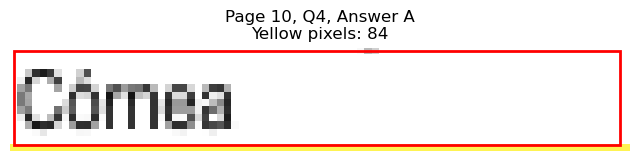

Page 10, Q4 - B: Detected box: x0=85.0, y0=312.3, x1=125.1, y1=324.9
Page 10, Q4, B: Yellow pixels: 1052
Page 10, Q4, B: Total non-white pixels: 1196
Page 10, Q4, B: Yellow percentage: 88.0%


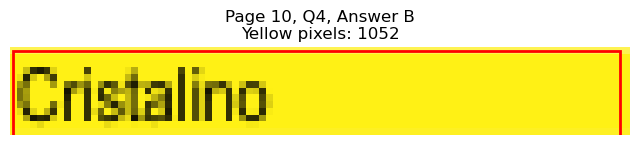

Page 10, Q4 - C: Detected box: x0=85.0, y0=324.9, x1=139.6, y1=337.5
Page 10, Q4, C: Yellow pixels: 106
Page 10, Q4, C: Total non-white pixels: 349
Page 10, Q4, C: Yellow percentage: 30.4%


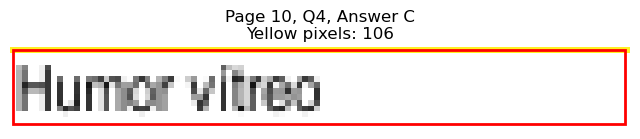

Page 10, Q4 - D: Detected box: x0=336.7, y0=299.7, x1=397.9, y1=312.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 291
Page 10, Q4, D: Yellow percentage: 0.0%


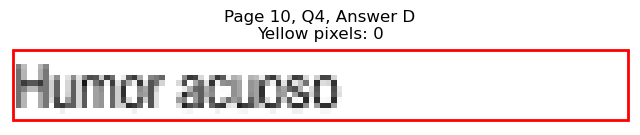

Page 10, Q4 - E: Detected box: x0=336.7, y0=312.3, x1=360.3, y1=324.9
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 118
Page 10, Q4, E: Yellow percentage: 0.0%


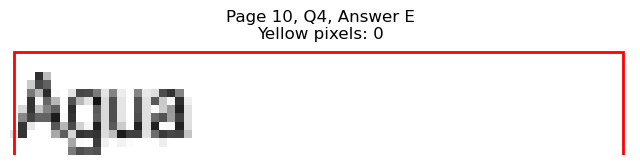


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=362.8, x1=228.4, y1=375.5
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 729
Page 10, Q5, A: Yellow percentage: 0.0%


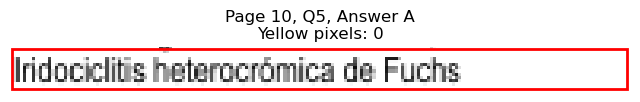

Page 10, Q5 - B: Detected box: x0=85.0, y0=375.4, x1=135.6, y1=388.1
Page 10, Q5, B: Yellow pixels: 102
Page 10, Q5, B: Total non-white pixels: 375
Page 10, Q5, B: Yellow percentage: 27.2%


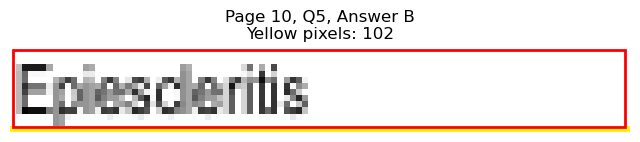

Page 10, Q5 - C: Detected box: x0=85.0, y0=388.0, x1=187.3, y1=400.7
Page 10, Q5, C: Yellow pixels: 1578
Page 10, Q5, C: Total non-white pixels: 2002
Page 10, Q5, C: Yellow percentage: 78.8%


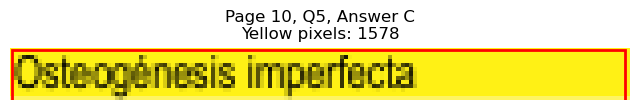

Page 10, Q5 - D: Detected box: x0=336.7, y0=362.8, x1=468.7, y1=375.5
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 704
Page 10, Q5, D: Yellow percentage: 0.0%


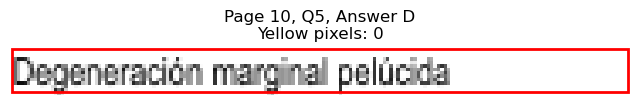

Page 10, Q5 - E: Detected box: x0=336.7, y0=375.4, x1=401.8, y1=388.1
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 311
Page 10, Q5, E: Yellow percentage: 0.0%


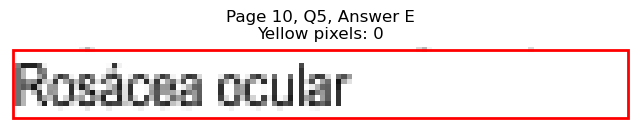


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=425.9, x1=137.2, y1=438.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 281
Page 10, Q6, A: Yellow percentage: 0.0%


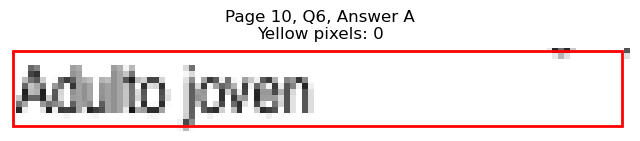

Page 10, Q6 - B: Detected box: x0=85.0, y0=438.5, x1=190.8, y1=451.2
Page 10, Q6, B: Yellow pixels: 157
Page 10, Q6, B: Total non-white pixels: 693
Page 10, Q6, B: Yellow percentage: 22.7%


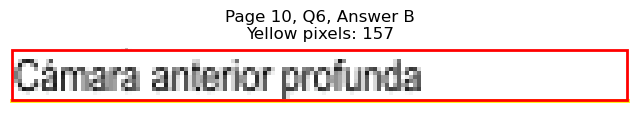

Page 10, Q6 - C: Detected box: x0=85.0, y0=451.1, x1=147.7, y1=463.8
Page 10, Q6, C: Yellow pixels: 1235
Page 10, Q6, C: Total non-white pixels: 1482
Page 10, Q6, C: Yellow percentage: 83.3%


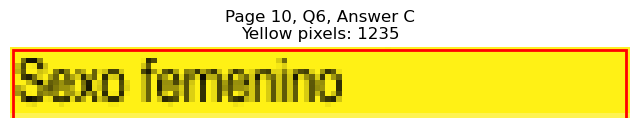

Page 10, Q6 - D: Detected box: x0=336.7, y0=425.9, x1=366.3, y1=438.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 163
Page 10, Q6, D: Yellow percentage: 0.0%


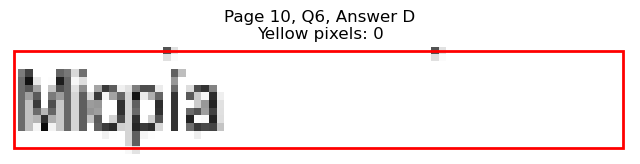

Page 10, Q6 - E: Detected box: x0=336.7, y0=438.5, x1=432.5, y1=451.2
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 500
Page 10, Q6, E: Yellow percentage: 0.0%


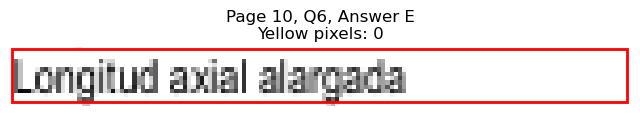


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=489.1, x1=193.8, y1=501.7
Page 10, Q7, A: Yellow pixels: 1634
Page 10, Q7, A: Total non-white pixels: 2080
Page 10, Q7, A: Yellow percentage: 78.6%


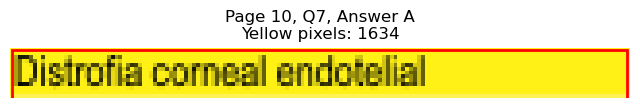

Page 10, Q7 - B: Detected box: x0=85.0, y0=501.7, x1=187.2, y1=514.3
Page 10, Q7, B: Yellow pixels: 154
Page 10, Q7, B: Total non-white pixels: 670
Page 10, Q7, B: Yellow percentage: 23.0%


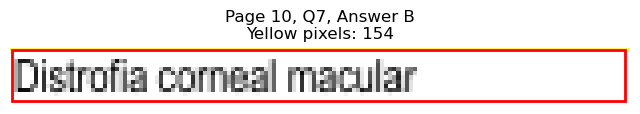

Page 10, Q7 - C: Detected box: x0=85.0, y0=514.3, x1=160.2, y1=526.9
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 381
Page 10, Q7, C: Yellow percentage: 0.0%


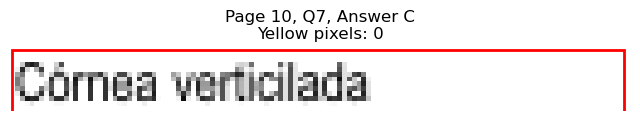

Page 10, Q7 - D: Detected box: x0=336.7, y0=489.1, x1=422.5, y1=501.7
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 462
Page 10, Q7, D: Yellow percentage: 0.0%


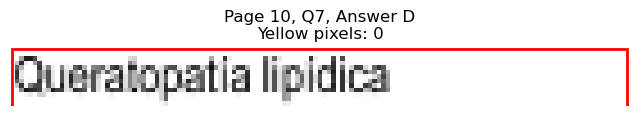

Page 10, Q7 - E: Detected box: x0=336.7, y0=501.7, x1=391.4, y1=514.3
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 284
Page 10, Q7, E: Yellow percentage: 0.0%


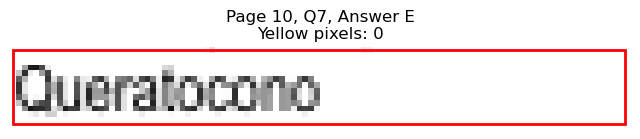


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=552.2, x1=174.3, y1=564.8
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 491
Page 10, Q8, A: Yellow percentage: 0.0%


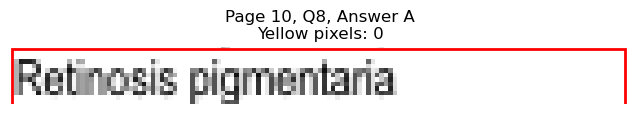

Page 10, Q8 - B: Detected box: x0=85.0, y0=564.8, x1=156.7, y1=577.4
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 387
Page 10, Q8, B: Yellow percentage: 0.0%


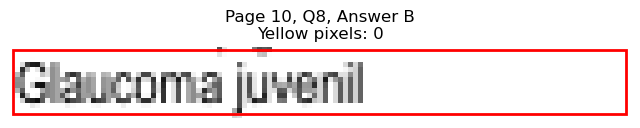

Page 10, Q8 - C: Detected box: x0=85.0, y0=577.4, x1=196.8, y1=590.0
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 545
Page 10, Q8, C: Yellow percentage: 0.0%


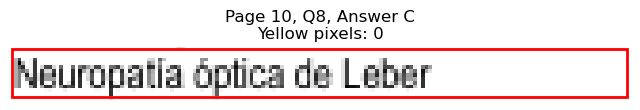

Page 10, Q8 - D: Detected box: x0=336.7, y0=552.2, x1=420.9, y1=564.8
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 561
Page 10, Q8, D: Yellow percentage: 0.0%


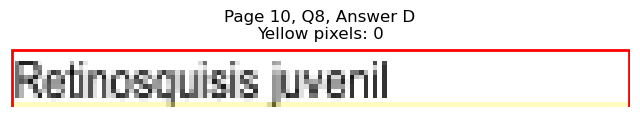

Page 10, Q8 - E: Detected box: x0=336.7, y0=564.8, x1=440.5, y1=577.4
Page 10, Q8, E: Yellow pixels: 1442
Page 10, Q8, E: Total non-white pixels: 2170
Page 10, Q8, E: Yellow percentage: 66.5%


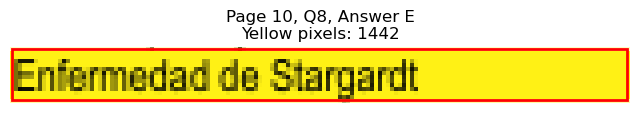


Page 10, Q8 - Selected Answer: E (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=615.2, x1=136.1, y1=627.8
Page 10, Q9, A: Yellow pixels: 1116
Page 10, Q9, A: Total non-white pixels: 1339
Page 10, Q9, A: Yellow percentage: 83.3%


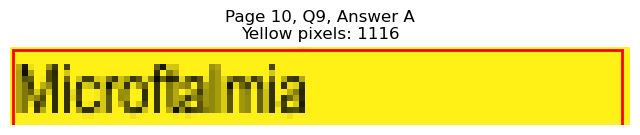

Page 10, Q9 - B: Detected box: x0=85.0, y0=627.9, x1=139.7, y1=640.6
Page 10, Q9, B: Yellow pixels: 106
Page 10, Q9, B: Total non-white pixels: 379
Page 10, Q9, B: Yellow percentage: 28.0%


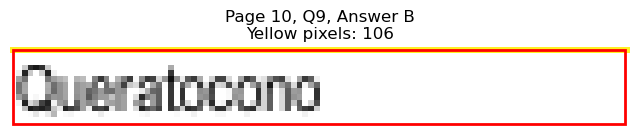

Page 10, Q9 - C: Detected box: x0=85.0, y0=640.5, x1=122.7, y1=653.2
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 200
Page 10, Q9, C: Yellow percentage: 0.0%


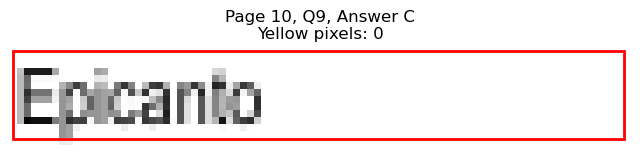

Page 10, Q9 - D: Detected box: x0=336.7, y0=615.2, x1=377.3, y1=627.8
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 200
Page 10, Q9, D: Yellow percentage: 0.0%


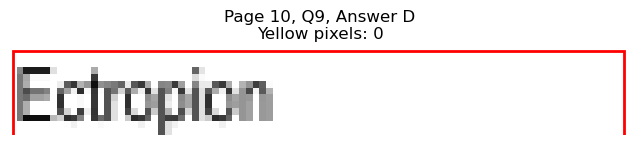

Page 10, Q9 - E: Detected box: x0=336.7, y0=627.9, x1=378.3, y1=640.6
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 220
Page 10, Q9, E: Yellow percentage: 0.0%


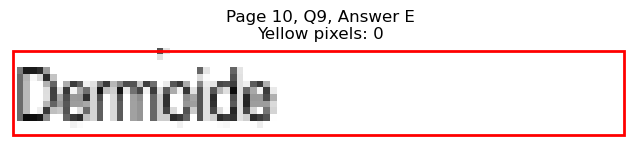


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=85.0, y0=691.1, x1=157.7, y1=703.7
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 360
Page 10, Q10, A: Yellow percentage: 0.0%


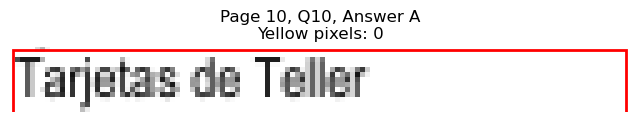

Page 10, Q10 - B: Detected box: x0=85.0, y0=703.7, x1=157.2, y1=716.3
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 373
Page 10, Q10, B: Yellow percentage: 0.0%


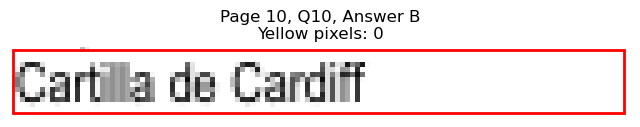

Page 10, Q10 - C: Detected box: x0=85.0, y0=716.3, x1=197.3, y1=728.9
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 579
Page 10, Q10, C: Yellow percentage: 0.0%


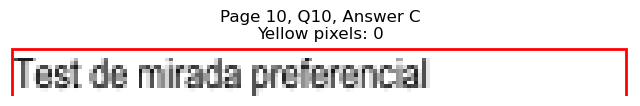

Page 10, Q10 - D: Detected box: x0=336.7, y0=691.1, x1=443.1, y1=703.7
Page 10, Q10, D: Yellow pixels: 1633
Page 10, Q10, D: Total non-white pixels: 2054
Page 10, Q10, D: Yellow percentage: 79.5%


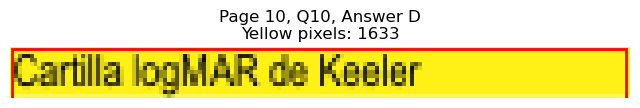

Page 10, Q10 - E: Detected box: x0=336.7, y0=703.7, x1=462.1, y1=716.3
Page 10, Q10, E: Yellow pixels: 176
Page 10, Q10, E: Total non-white pixels: 835
Page 10, Q10, E: Yellow percentage: 21.1%


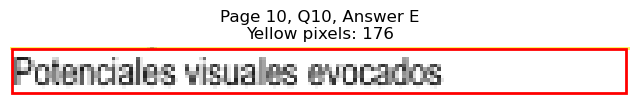


Page 10, Q10 - Selected Answer: D (based on yellow pixel count)





Page 11: Found 2 questions
Page 11, Q1 - A: Detected box: x0=85.0, y0=135.5, x1=148.2, y1=148.2
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 343
Page 11, Q1, A: Yellow percentage: 0.0%


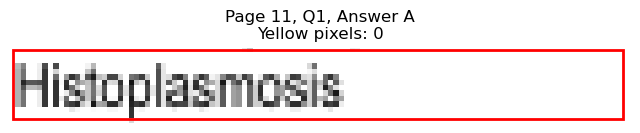

Page 11, Q1 - B: Detected box: x0=85.0, y0=148.2, x1=142.1, y1=160.9
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 286
Page 11, Q1, B: Yellow percentage: 0.0%


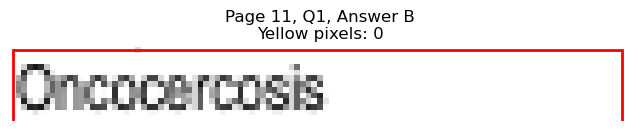

Page 11, Q1 - C: Detected box: x0=85.0, y0=160.8, x1=138.1, y1=173.5
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 276
Page 11, Q1, C: Yellow percentage: 0.0%


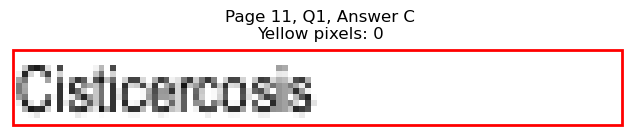

Page 11, Q1 - D: Detected box: x0=336.7, y0=135.5, x1=385.9, y1=148.2
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 261
Page 11, Q1, D: Yellow percentage: 0.0%


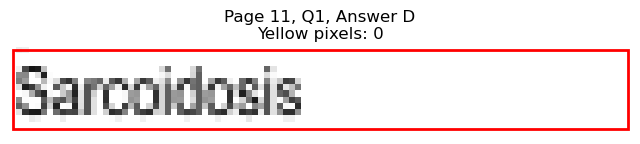

Page 11, Q1 - E: Detected box: x0=336.7, y0=148.2, x1=389.8, y1=160.9
Page 11, Q1, E: Yellow pixels: 1158
Page 11, Q1, E: Total non-white pixels: 1352
Page 11, Q1, E: Yellow percentage: 85.7%


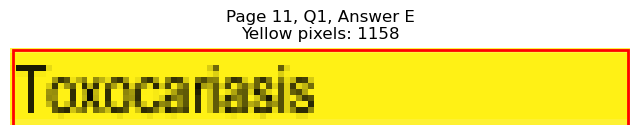


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=85.0, y0=198.6, x1=266.1, y1=211.3
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 885
Page 11, Q2, A: Yellow percentage: 0.0%


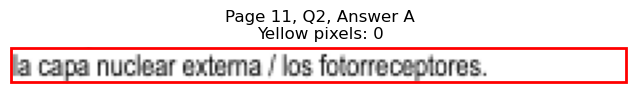

Page 11, Q2 - B: Detected box: x0=85.0, y0=211.3, x1=307.1, y1=224.0
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 1143
Page 11, Q2, B: Yellow percentage: 0.0%


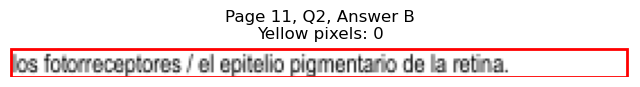

Page 11, Q2 - C: Detected box: x0=85.0, y0=223.9, x1=232.5, y1=236.6
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 709
Page 11, Q2, C: Yellow percentage: 0.0%


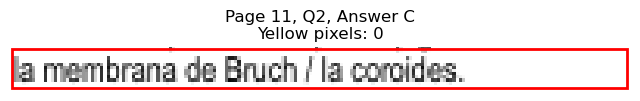

Page 11, Q2 - D: Detected box: x0=85.0, y0=236.5, x1=296.1, y1=249.2
Page 11, Q2, D: Yellow pixels: 263
Page 11, Q2, D: Total non-white pixels: 1265
Page 11, Q2, D: Yellow percentage: 20.8%


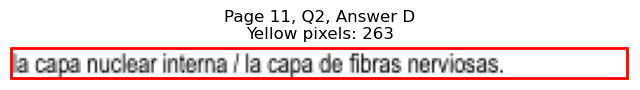

Page 11, Q2 - E: Detected box: x0=85.0, y0=249.1, x1=323.7, y1=261.8
Page 11, Q2, E: Yellow pixels: 2864
Page 11, Q2, E: Total non-white pixels: 3770
Page 11, Q2, E: Yellow percentage: 76.0%


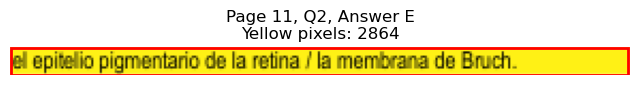


Page 11, Q2 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál de los siguientes es el patógeno más aso...
1   Varón de 75 años, con antecedente de quimioter...
2   ¿Cuál es el agente etiológico de la queratitis...
3   ¿Cuál es la disgenesia del segmento anterior q...
4                    Las estrías de Siegrist indican:
..                                                ...
95  ¿Cuál de las siguientes presenta una mutación ...
96  ¿Cuál de las siguientes es la manifestación oc...
97  Niño de 3 años con diagnóstico de ambliopía. ¿...
98  Niño de 8 años con leucocoria y estrabismo en ...
99  En la degeneración macular asociada a la edad,...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                  Citomegalovirus   
1                                         Impétigo   
2                                     Acanthamoeba   
3                               Anomalía de Peters   
4                             Degeneración corneal   
..                                             ...   
95                           Retinosis pigmentaria   
96                                    Microftalmia   
97                              Tarjetas de Teller   
98                                  Histoplasmosis   
99  la capa nuclear externa / los fotorreceptores.   

                                             option_B  \
0                               Virus de Epstein-Barr   
1                                       Herpes zóster   
2                                          Adenovirus   
3                                        Iris plateau   
4                                Degeneración macular   
..                                                ...   
95                                   Glaucoma juvenil   
96                                        Queratocono   
97                                Cartilla de Cardiff   
98                                       Oncocercosis   
99  los fotorreceptores / el epitelio pigmentario ...   

                               option_C  \
0                     Toxoplasma gondii   
1                               Pénfigo   
2                               Cándida   
3                              Aniridia   
4          Necrosis fibrinoide coroidea   
..                                  ...   
95           Neuropatía óptica de Leber   
96                             Epicanto   
97          Test de mirada preferencial   
98                        Cisticercosis   
99  la membrana de Bruch / la coroides.   

                                             option_D  \
0                        Virus de la varicella-zoster   
1                                     Stevens Johnson   
2                                  Treponema pallidum   
3                                    Síndrome de Lowe   
4                          Degeneración en empalizada   
..                                                ...   
95                              Retinosquisis juvenil   
96                                          Ectropion   
97                          Cartilla logMAR de Keeler   
98                                        Sarcoidosis   
99  la capa nuclear interna / la capa de fibras ne...   

                                             option_E  
0                                      Toxocara canis  
1                                           Erisipela  
2                                 Onchocerca volvulus  
3                                Anomalía de Axenfeld  
4                                   Necrosis escleral  
..                                                ...  
95                            Enfermedad de Stargardt  
96                                           Dermoide  
97                      Potenciales visuales evocados  
98                                       Toxocariasis  
99  el epitelio pigmentario de la retina / la memb...  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál de los siguientes es el patógeno más aso...   
1   Varón de 75 años, con antecedente de quimioter...   
2   ¿Cuál es el agente etiológico de la queratitis...   
3   ¿Cuál es la disgenesia del segmento anterior q...   
4                    Las estrías de Siegrist indican:   
..                                                ...   
95  ¿Cuál de las siguientes presenta una mutación ...   
96  ¿Cuál de las siguientes es la manifestación oc...   
97  Niño de 3 años con diagnóstico de ambliopía. ¿...   
98  Niño de 8 años con leucocoria y estrabismo en ...   
99  En la degeneración macular asociada a la edad,...   

                                          option_A  \
0                                  Citomegalovirus   
1                                         Impétigo   
2                                     Acanthamoeba   
3                               Anomalía de Peters   
4                             Degeneración corneal   
..                                             ...   
95                           Retinosis pigmentaria   
96                                    Microftalmia   
97                              Tarjetas de Teller   
98                                  Histoplasmosis   
99  la capa nuclear externa / los fotorreceptores.   

                                             option_B  \
0                               Virus de Epstein-Barr   
1                                       Herpes zóster   
2                                          Adenovirus   
3                                        Iris plateau   
4                                Degeneración macular   
..                                                ...   
95                                   Glaucoma juvenil   
96                                        Queratocono   
97                                Cartilla de Cardiff   
98                                       Oncocercosis   
99  los fotorreceptores / el epitelio pigmentario ...   

                               option_C  \
0                     Toxoplasma gondii   
1                               Pénfigo   
2                               Cándida   
3                              Aniridia   
4          Necrosis fibrinoide coroidea   
..                                  ...   
95           Neuropatía óptica de Leber   
96                             Epicanto   
97          Test de mirada preferencial   
98                        Cisticercosis   
99  la membrana de Bruch / la coroides.   

                                             option_D  \
0                        Virus de la varicella-zoster   
1                                     Stevens Johnson   
2                                  Treponema pallidum   
3                                    Síndrome de Lowe   
4                          Degeneración en empalizada   
..                                                ...   
95                              Retinosquisis juvenil   
96                                          Ectropion   
97                          Cartilla logMAR de Keeler   
98                                        Sarcoidosis   
99  la capa nuclear interna / la capa de fibras ne...   

                                             option_E correct_answer  
0                                      Toxocara canis              D  
1                                           Erisipela              B  
2                                 Onchocerca volvulus              A  
3                                Anomalía de Axenfeld              E  
4                                   Necrosis escleral              C  
..                                                ...            ...  
95                            Enfermedad de Stargardt              E  
96                                           Dermoide              A  
97                      Potenciales visuales evocados              D  
98                                       Toxocariasis              E  
99  el epitelio pigmentario de la retina /

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/OFTALMOLOGIA.csv
